# Rossmann Store Sales

### Background
##### This Project is built to conduct the data from Featured Prediction Competition „Rossmann Store Sales“  hosted at Kaggle. https://www.kaggle.com/c/rossmann-store-sales/overview 

In [ ]:
!unzip rossmann-store-sales

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LinearRegression

# Visulization
import seaborn as sns
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

In [2]:
# importing train data to learn
train = pd.read_csv("./train.csv", parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv("./store.csv", low_memory = False)
# time series as indexes
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

## 1. Exploratory data cleaning

### 1.1   Analysis in _train_ dataset

Firstly let's take a look at the train Set. As we can see from the cell below there is no null value in __train__ Set

In [314]:
print('The size of train Set:', train.shape)
print('\n')
print(train.info())
train.head().append(train.tail())

The size of train Set: (1017209, 8)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB
None


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


In [3]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


Feature description:
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- Promo - indicates whether a store is running a promo on that day
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

'Time' is a very important feature for a time series. Next we do some work on `Date`

In [5]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

/home/hzj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  after removing the cwd from sys.path.


In [5]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31


Glance at the distribution of `Sales` and `Customers` by plotting ECDF (empirical cumulative distribution function)

<AxesSubplot:xlabel='Customers', ylabel='Proportion'>

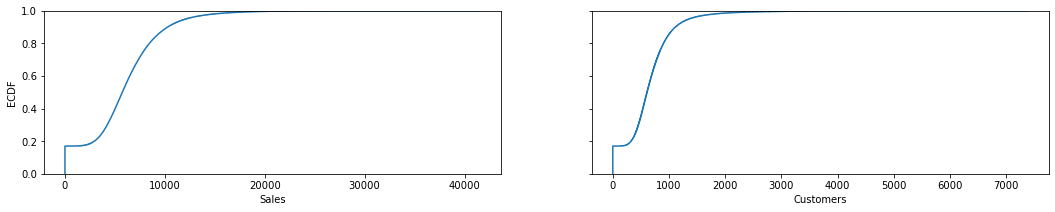

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,3), sharey=True)
sns.ecdfplot(data=train, x="Sales", ax=ax1)
ax1.set_ylabel('ECDF')
sns.ecdfplot(data=train, x="Customers", ax=ax2)

There are about 20% values in `Sales`/`Customers` equals zero. These values should be excluded from model training. Let's do some survey about the zeros. Is the closing a store the only reason to cause that?

In [280]:
_ = train.query('Open == 1 & Sales == 0')
print('open store with no sale:', _.shape)
_.head()

open store with no sale: (54, 12)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39


Interestingly, 54 records match. Are those days all caused by no customers?

In [68]:
_ = train.query('Open == 1 & Customers != 0 & Sales == 0')
print('open store with no sale:', _.shape)
_.head()

open store with no sale: (2, 12)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,,
2014-04-29,1100,2,0,3,1,1,0,0,2014,4,29,18
2013-04-25,948,4,0,5,1,1,0,0,2013,4,25,17


No. Two records have several customers but bought nothing.

We only take the records with no zero `Sales` into our modeling.

In [6]:
train = train[train['Sales'] != 0]
print('Days with Sales:', train.shape[0])

Days with Sales: 844338


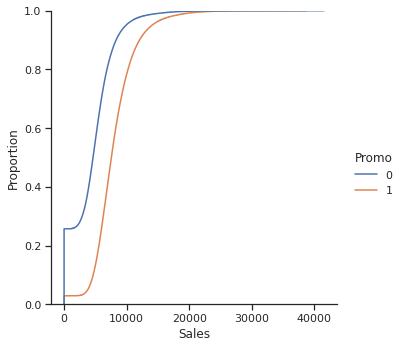

In [24]:
sns.displot(data=train,x='Sales', kind="ecdf", hue="Promo")

### 1.2   Analysis in _store_ dataset

Now we take a look at __store__ dataset

In [7]:
print('The size of store Set:', store.shape)
print('\n')
print(store.info())
store.head().append(store.tail())

The size of store Set: (1115, 10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


Feature Description:
- Store: a unique Id for each store
- StoreType: differentiates between 4 different store models: a, b, c, d
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance: distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
- Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

There are missing values in __store__. Print the detail about _NaN's_.

In [8]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Only 3 `CompetitionDistance` are missing, but much more missing values in the CompetitionOpen time. We assume that they are just not recorded in dataset. So we replace these missing values with mode(). 
Now glance at these three missing records in `CompetitionDistance`.

In [60]:
store[pd.isnull(store['CompetitionDistance'])]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


And missing records in `CompetitionOpenSinceMonth` and `CompetitionOpenSinceYear`

In [9]:
CompetitionOpenMissing = store[pd.isnull(store.CompetitionOpenSinceMonth) & pd.isnull(store.CompetitionOpenSinceYear)]
CompetitionOpenMissing

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [10]:
store.CompetitionDistance.fillna(store.CompetitionDistance.mode()[0], inplace=True)

In [11]:
store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].mode()[0], inplace=True)

In [12]:
store['CompetitionOpenSinceYear'].fillna(store['CompetitionOpenSinceYear'].mode()[0], inplace=True)

Check the replaced __Competition__ infos

In [65]:
# CompetitionDistance
store.iloc[[290, 621, 878]]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,250.0,9.0,2013.0,0,NaN,NaN,NaN
621,622,a,c,250.0,9.0,2013.0,0,NaN,NaN,NaN
878,879,d,a,250.0,9.0,2013.0,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [321]:
# CompetitionOpenSinceMonth, CompetitionOpenSinceYear
store.iloc[CompetitionOpenMissing.index]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,9.0,2013.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,9.0,2013.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,9.0,2013.0,0,NaN,NaN,NaN
18,19,a,c,3240.0,9.0,2013.0,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,9.0,2013.0,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,9.0,2013.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,9.0,2013.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,9.0,2013.0,0,NaN,NaN,NaN
1113,1114,a,c,870.0,9.0,2013.0,0,NaN,NaN,NaN


Now we handle the Promo2 related features.
are there some stores open but no `Promo2` info (missing values)?

In [322]:
(store[(store.Promo2 == 1) & store.Promo2SinceYear.isnull()]).shape

(0, 10)

No. That means, if there's no `Promo2` then there's no info about it. and reverse?

In [289]:
(store[(store.Promo2 == 0) & store.Promo2SinceYear.notna()]).shape

(0, 10)

No. It's good. This means there is no mistaken info. Then we replace this values with zeros.

In [13]:
store.fillna(0, inplace=True)

In [339]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [14]:
# Check NaN's
store.isna().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

### 1.3   Analysis in joined _train_store_ dataset 

Join __train__ with __store__ information

In [15]:
# preserve `Date` in train DataSet
# train['Date'] = train.index
train_store = pd.merge(train, store, how='inner', on='Store')

In [16]:
print('train_store size: ', train_store.shape)
train_store.head().append(train_store.tail())

train_store size:  (844338, 21)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
844333,292,1,9291,1002,1,1,0,0,2013,1,...,2,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844334,292,6,2748,340,1,0,0,0,2013,1,...,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844335,292,5,4202,560,1,0,0,1,2013,1,...,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844336,292,4,4580,662,1,0,0,1,2013,1,...,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844337,292,3,5076,672,1,0,0,1,2013,1,...,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0


How is the `Sales` per `Customer`?

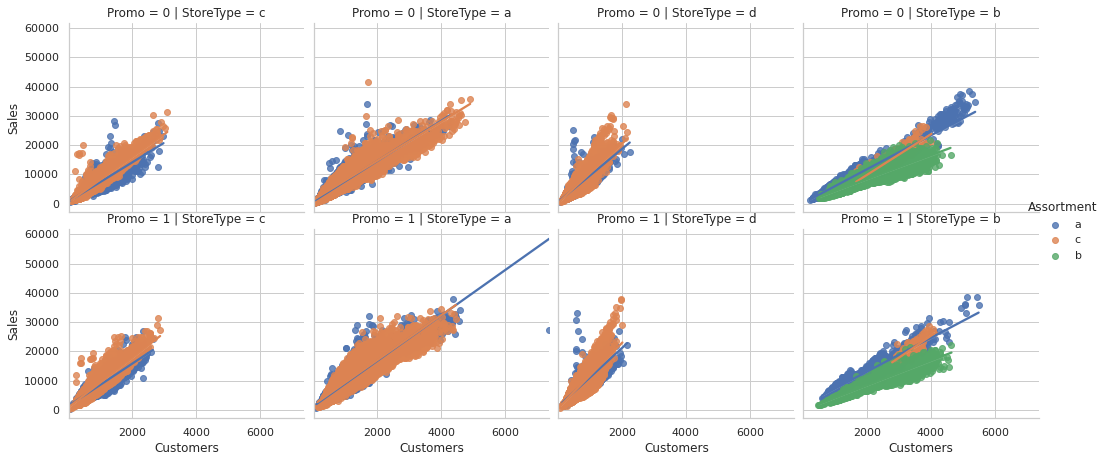

In [108]:
sns.set(style="whitegrid")
f = sns.lmplot(data=train_store,x='Customers', y='Sales', col='StoreType', row='Promo', hue='Assortment')
f.fig.set_size_inches(15,6)

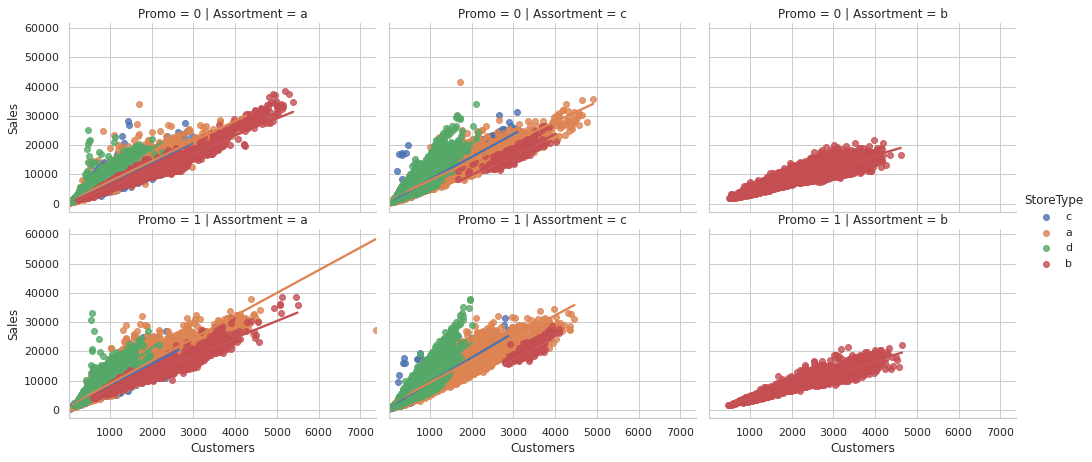

In [107]:
sns.set(style="whitegrid")
f = sns.lmplot(data=train_store,x='Customers', y='Sales', col='Assortment', row='Promo', hue='StoreType')
f.fig.set_size_inches(15,6)

we could have a general inference that for Assortment a and c different StoreType displays a different average Sale per Customer. Besides on Promo day people intend to pay more. 

Does the `Sales` have a seasonal trend?

/home/hzj/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


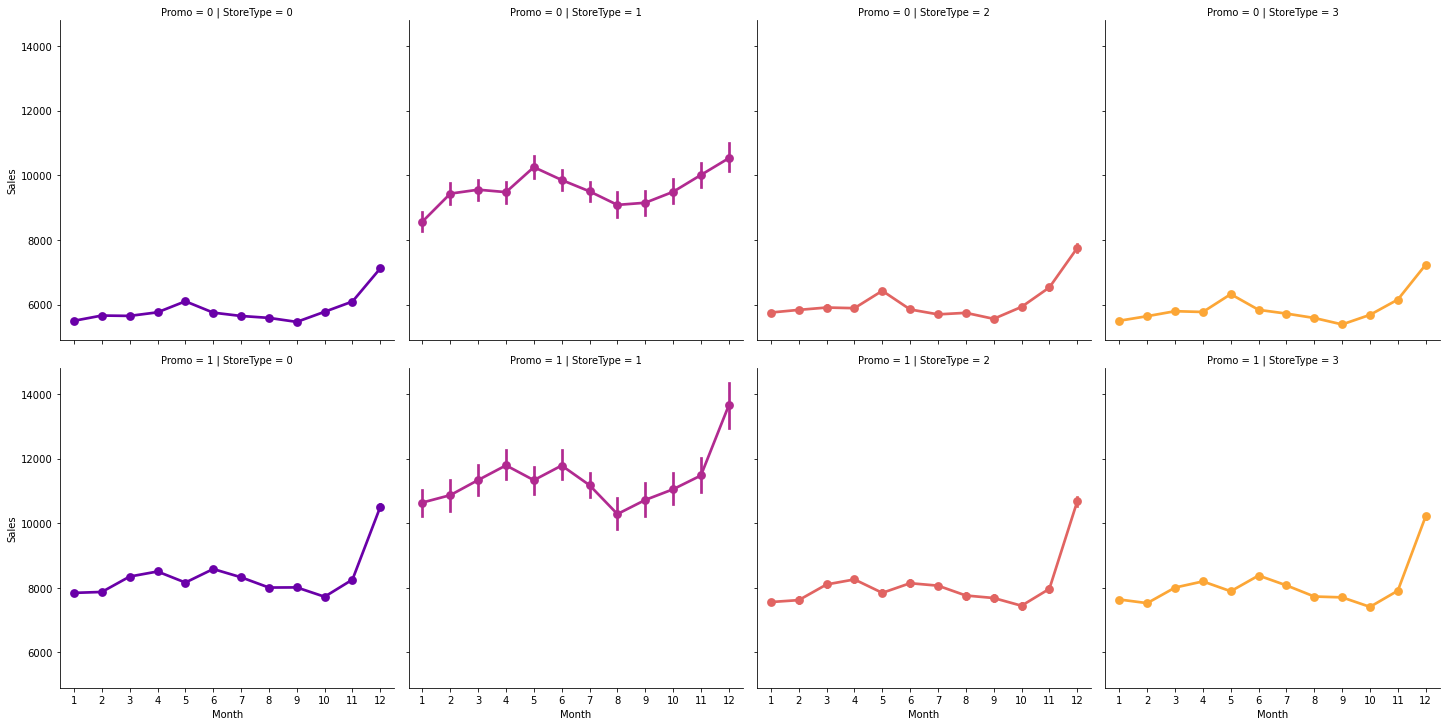

In [113]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo') 

All store types despite of the runing promotion follow the same trend but at different scales depending on the presence of ‚Promo‘ and `StoreType` itself. Already at this point, we can see that Sales escalate towards Christmas holidays and reach a peak at the year end. 

Does `DayOfWeek` have an effect on `Sales` ?

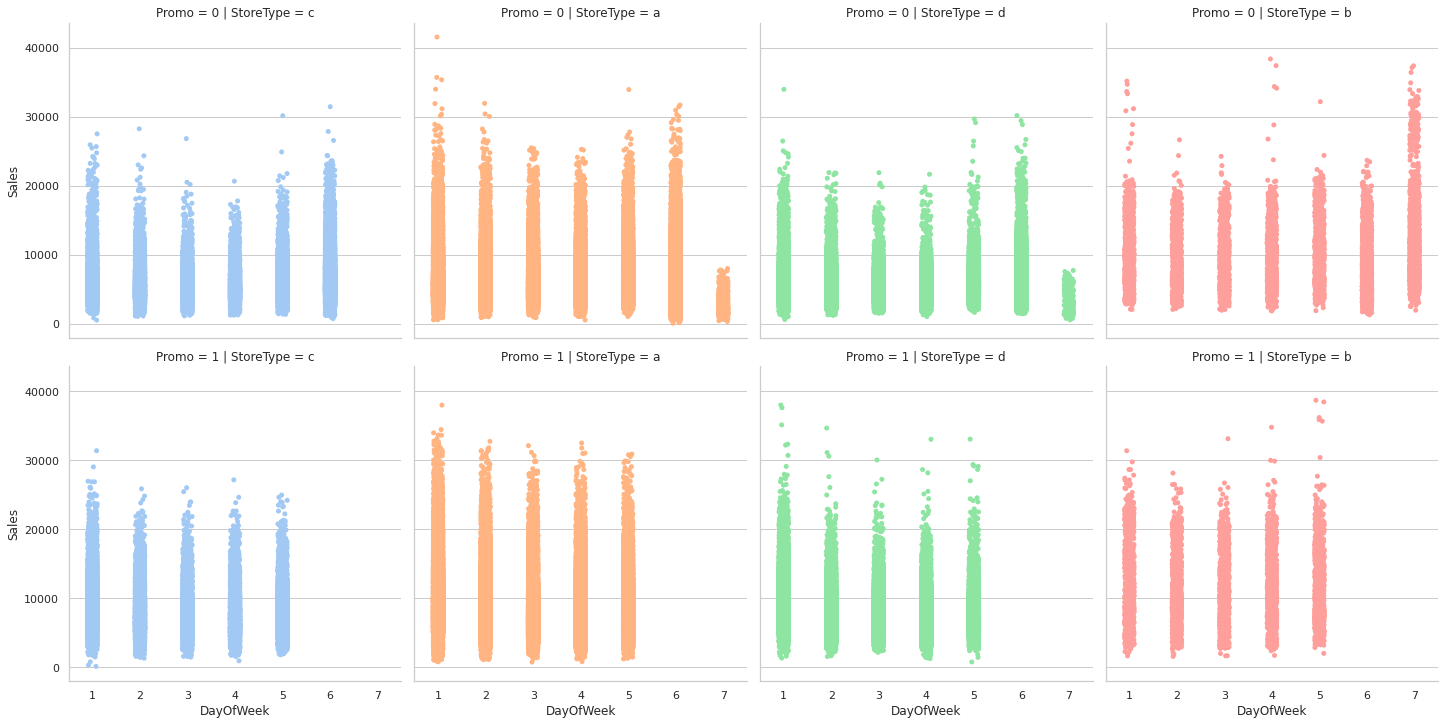

In [123]:
sns.catplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'pastel',
               hue = 'StoreType',
               row = 'Promo') # per promo in the store in rows

All Store type don‘t open on weekend in case of  a `Promo` (equals 1).  For `StoreType` d `Sales` tends to peak on Sunday under no ‚Promo‘.

Does `CompetitionDistance` matter?

<AxesSubplot:xlabel='CompetitionDistance', ylabel='Sales'>

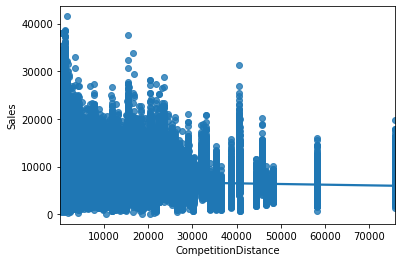

In [35]:
sns.regplot(data=train_store, x="CompetitionDistance", y="Sales")

we can see that `CompetitionDistance` has a negative impact on the `Sales`, but the trend is not obvious. 

How does the 'holiday' impact on 'Customers`?

/home/hzj/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


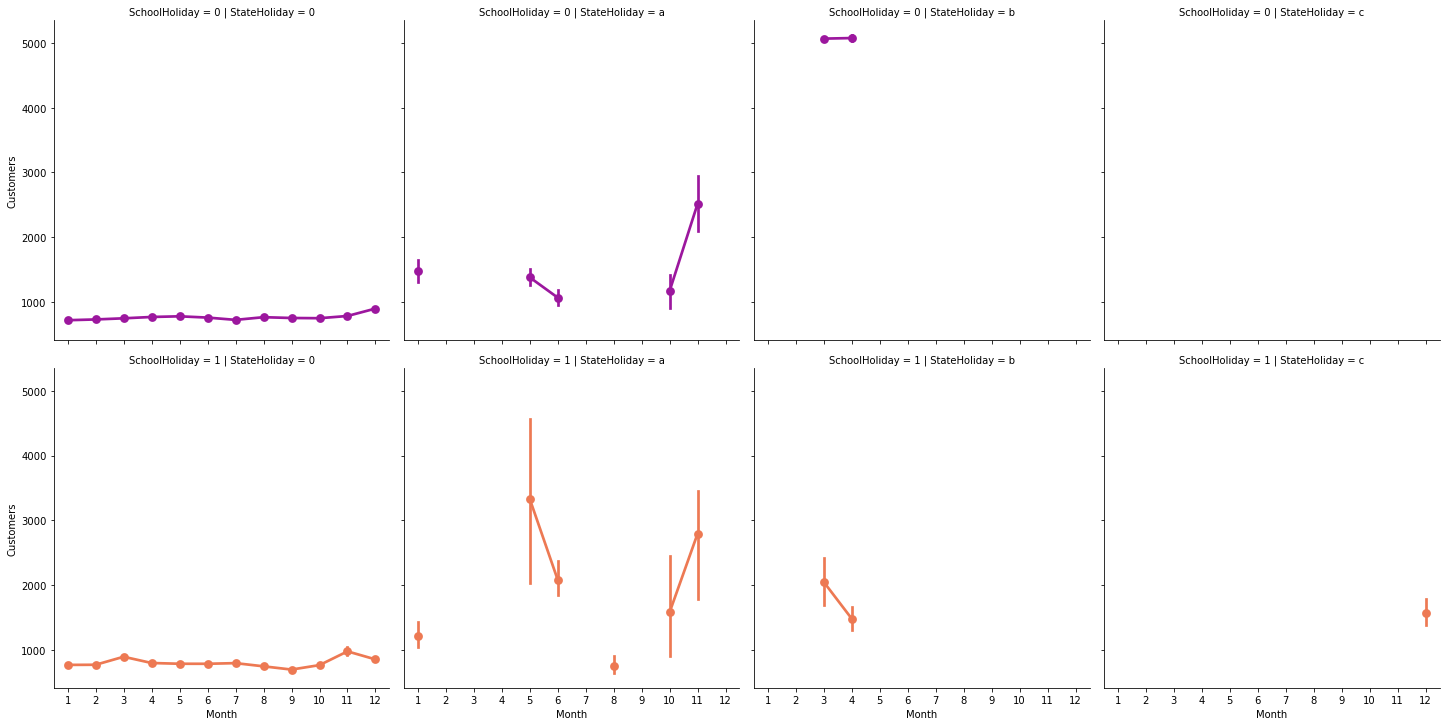

In [56]:
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StateHoliday', 
               row = 'SchoolHoliday',
               palette = 'plasma',
               hue = 'SchoolHoliday')
             #  hue = 'StoreType',

Now I'm very interested in these `Open` days how many and which type of `StateHoliday` are there.

In [123]:
train_store[train_store.StateHoliday != 0].StateHoliday.value_counts()

1    694
2    145
3     71
Name: StateHoliday, dtype: int64

/home/hzj/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


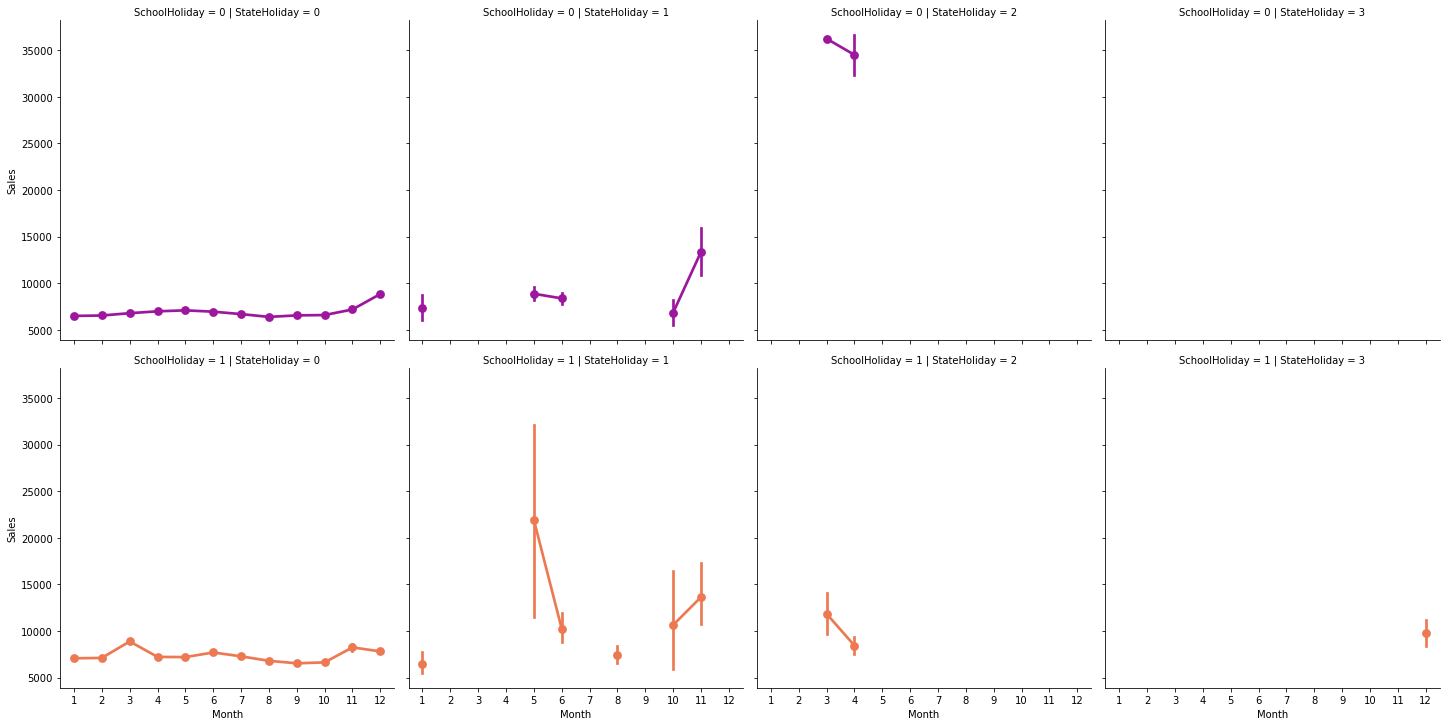

In [112]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StateHoliday', 
               row = 'SchoolHoliday',
               palette = 'plasma',
               hue = 'SchoolHoliday')
             #  hue = 'StoreType',

/home/hzj/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


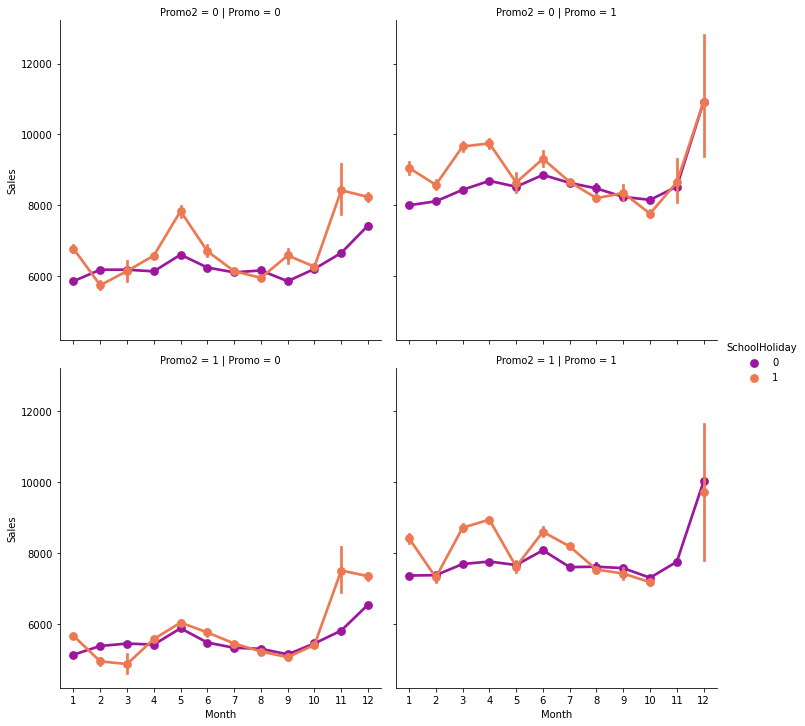

In [114]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               palette = 'plasma',
               hue = 'SchoolHoliday')

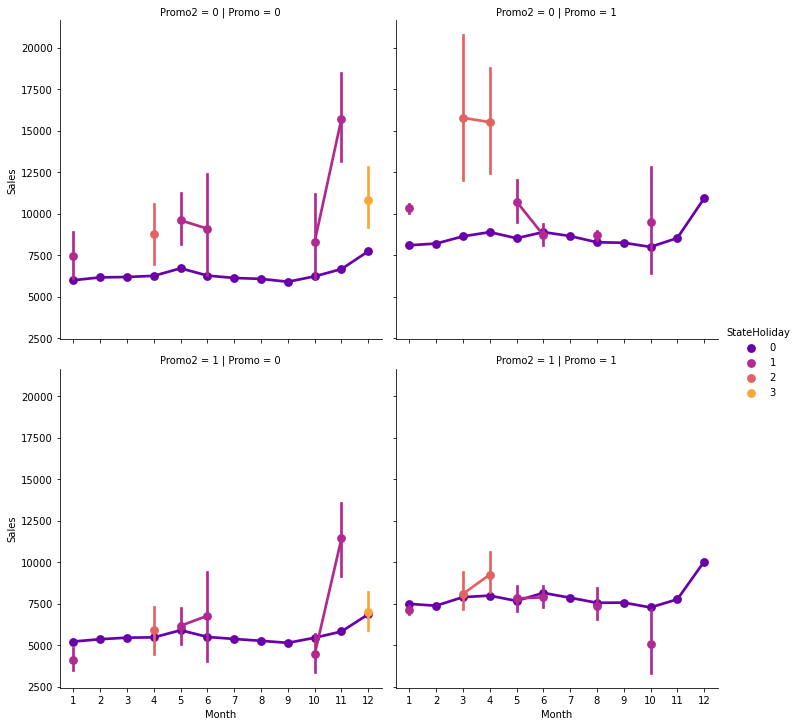

In [116]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               palette = 'plasma',
               hue = 'StateHoliday')

In [17]:
train_store.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

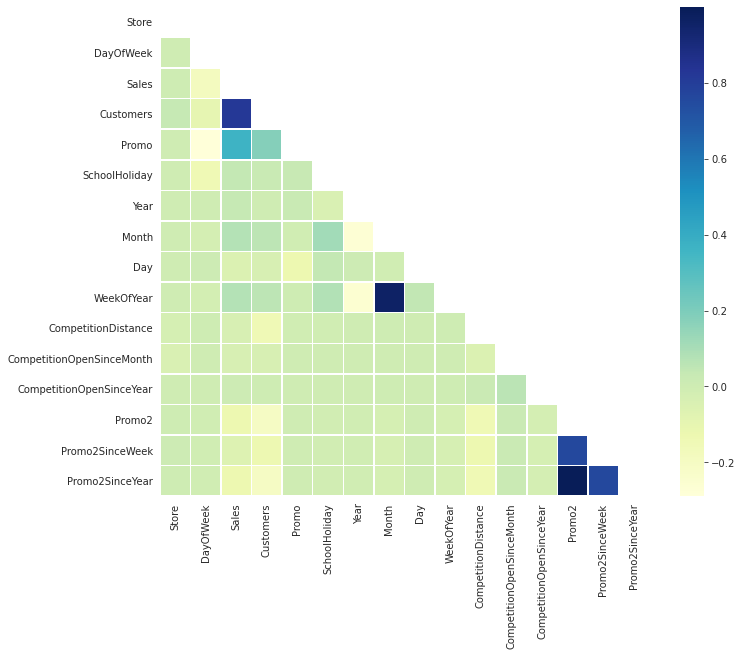

In [20]:
corr_all = train_store.drop(['Open'], axis=1).corr()

# generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize = (11, 9))
    ax = sns.heatmap(corr_all, mask=mask, linewidth=.5, square=True, cmap="YlGnBu")

s mentioned before, we have a strong positive correlation between the amount of Sales and Customers of a store. We can also observe a positive correlation between the fact that the store had a running promotion (`Promo` equal to 1) and amount of `Customers`. 

However, as soon as the store continues a consecutive promotion (`Promo2` equal to 1) the number of `Customers` and `Sales` seems to stay the same or even decrease, which is described by the pale negative correlation on the heatmap. The same negative correlation is observed between the presence of the promotion in the store and the day of a week.

## 2. Feature Engineering

Since the promo is a active factor for sale we create a new feature about it: how many promo days per week for each store.

In [95]:
train_store

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,292,1,9291,1002,1,1,0,0,2013,1,...,2,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844334,292,6,2748,340,1,0,0,0,2013,1,...,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844335,292,5,4202,560,1,0,0,1,2013,1,...,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844336,292,4,4580,662,1,0,0,1,2013,1,...,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0


In [45]:
'''
promoCount_df = pd.DataFrame({'PromoDaysperWeek': train_store['Promo'], 'Store': train_store['Store'], \
                              'Year': train_store['Year'], 'WeekOfYear': train_store['WeekOfYear'], \
                              'DayOfWeek': train_store['DayOfWeek']})
promoCount_df = promoCount_df.drop_duplicates()
promoCount_df.drop(['DayOfWeek'], axis=1, inplace=True)
promoCount_df = promoCount_df.groupby(['Store', 'Year', 'WeekOfYear']).sum()
train_store = train_store.merge(promoCount_df, how='inner', on=['Store', 'Year', 'WeekOfYear'])
train_store
'''

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,PromoDaysperWeek
0,1,5,5263,555,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,5
1,1,4,5020,546,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,5
2,1,3,4782,523,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,5
3,1,2,5011,560,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,5
4,1,1,6102,612,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,5,5142,351,1,1,0,1,2013,1,...,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5
1017205,1115,4,5007,339,1,1,0,1,2013,1,...,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5
1017206,1115,3,4649,324,1,1,0,1,2013,1,...,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5
1017207,1115,2,5243,341,1,1,0,1,2013,1,...,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5


In [96]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

train_store['CompetitionOpen'] = train_store.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
train_store['PromoOpen'] = train_store.PromoOpen.apply(lambda x: x if x > 0 else 0)

In [97]:
# 
month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct',\
             11:'Nov', 12:'Dec'}
train_store['monthStr'] = train_store.Month.map(month2str)
train_store.loc[train_store.PromoInterval == 0, 'PromoInterval'] = ''
train_store['IsPromoMonth'] = 0
for interval in train_store.PromoInterval.unique():
    if interval != '':
        for month in interval.split(','):
            train_store.loc[(train_store.monthStr == month) & (train_store.PromoInterval == interval), \
                            'IsPromoMonth'] = 1

In [48]:
train_store.PromoInterval.unique()

array(['', 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [98]:
train_store.IsPromoMonth.value_counts()

0    699125
1    145213
Name: IsPromoMonth, dtype: int64

In [99]:
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
train_store.StoreType.replace(mappings, inplace=True)
train_store.Assortment.replace(mappings, inplace=True)
train_store.StateHoliday.replace(mappings, inplace=True)

In [100]:
train_store["StateHoliday"].unique()

array([0, 1, 2, 3])

In [18]:
train_store["StoreType"].unique()

array([3, 1, 4, 2])

In [19]:
train_store["Assortment"].unique()

array([1, 3, 2])

In [20]:
train_store.dtypes

Store                                 int64
DayOfWeek                             int64
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                          int64
SchoolHoliday                         int64
Year                                  int64
Month                                 int64
Day                                   int64
WeekOfYear                            int64
Date                         datetime64[ns]
StoreType                             int64
Assortment                            int64
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
CompetitionOpen                 

## 3. Model training

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [101]:
X = train_store.drop(['Customers', 'Open', 'monthStr', 'Sales', 'PromoInterval'], axis=1)
y = np.log(train_store["Sales"])

In [102]:
# split the data into train/test set
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size = 0.3, # 30% for the evaluation set
                                                    random_state = 42)

In [52]:
# split the last 6 weeks data as hold-out set (idea from Gert https://www.kaggle.com/c/rossmann-store-sales/discussion/18024)
'''
train_store = train_store.sort_values(['Date'],ascending = False)
X = train_store.drop(['Customers', 'Open', 'monthStr', 'Sales', 'PromoInterval', 'Date'], axis=1)
y = np.log(train_store["Sales"])
X_val = X[:6*7*1115]
y_val = y[:6*7*1115]
X_train = X[6*7*1115:]
y_train = y[6*7*1115:]
'''

/home/hzj/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [53]:
'''
val_Set = train_store[:6*7*1115]
train_Set = train_store[6*7*1115:]
val_Set = val_Set[val_Set['Sales'] !=0]
train_Set = train_Set[train_Set['Sales'] !=0]
X_val = val_Set.drop(['Customers', 'Open', 'monthStr', 'Sales', 'PromoInterval', 'Date'], axis=1)
y_val = np.log(val_Set["Sales"])
X_train = train_Set.drop(['Customers', 'Open', 'monthStr', 'Sales', 'PromoInterval', 'Date'], axis=1)
y_train = np.log(train_Set["Sales"])
'''

### 3.1 XGboost

In [24]:
# define rmspe for xgb(code from https://www.kaggle.com/cast42/xgboost-in-python-with-rmspe-v2/code)
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

In [103]:
# base parameters
params = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.1, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results
# xgboost model without tuning
#Private score: 0.13347
#Public score: 0.12467

In [104]:
params_1 = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.045,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 10
          }

In [105]:
from time import time
start = time()

dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)

watchlist = [(dtrain, 'train'), (dval, 'validation')]

xgb_model = xgb.train(params_1, dtrain, 6000, evals = watchlist,
                      early_stopping_rounds = 100, feval = rmspe_xg, verbose_eval = True)

end = time()
print('Training time is {:2f} s.'.format(end-start))

[23:26:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[23:26:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:7.89731	validation-rmse:7.89699	train-rmspe:0.99976	validation-rmspe:0.99976
Multiple eval metrics have been passed: 'validation-rmspe' will be used for early stopping.

Will train until validation-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.54267	validation-rmse:7.54235	train-rmspe:0.99959	validation-rmspe:0.99959
[2]	train-rmse:7.20401	validation-rmse:7.20372	train-rmspe:0.99935	validation-r

[81]	train-rmse:0.30184	validation-rmse:0.30205	train-rmspe:0.29087	validation-rmspe:0.26008
[82]	train-rmse:0.29580	validation-rmse:0.29604	train-rmspe:0.28851	validation-rmspe:0.25690
[83]	train-rmse:0.28992	validation-rmse:0.29019	train-rmspe:0.28616	validation-rmspe:0.25376
[84]	train-rmse:0.28420	validation-rmse:0.28449	train-rmspe:0.28364	validation-rmspe:0.25057
[85]	train-rmse:0.27938	validation-rmse:0.27970	train-rmspe:0.28221	validation-rmspe:0.24825
[86]	train-rmse:0.27511	validation-rmse:0.27546	train-rmspe:0.28095	validation-rmspe:0.24634
[87]	train-rmse:0.27036	validation-rmse:0.27074	train-rmspe:0.27920	validation-rmspe:0.24386
[88]	train-rmse:0.26421	validation-rmse:0.26458	train-rmspe:0.27611	validation-rmspe:0.23989
[89]	train-rmse:0.25912	validation-rmse:0.25953	train-rmspe:0.27400	validation-rmspe:0.23701
[90]	train-rmse:0.25580	validation-rmse:0.25626	train-rmspe:0.27304	validation-rmspe:0.23563
[91]	train-rmse:0.25211	validation-rmse:0.25261	train-rmspe:0.27188	va

[169]	train-rmse:0.16703	validation-rmse:0.16894	train-rmspe:0.22871	validation-rmspe:0.18391
[170]	train-rmse:0.16672	validation-rmse:0.16863	train-rmspe:0.22833	validation-rmspe:0.18360
[171]	train-rmse:0.16653	validation-rmse:0.16847	train-rmspe:0.22818	validation-rmspe:0.18344
[172]	train-rmse:0.16608	validation-rmse:0.16803	train-rmspe:0.22788	validation-rmspe:0.18305
[173]	train-rmse:0.16462	validation-rmse:0.16661	train-rmspe:0.22664	validation-rmspe:0.18154
[174]	train-rmse:0.16440	validation-rmse:0.16639	train-rmspe:0.22649	validation-rmspe:0.18132
[175]	train-rmse:0.16410	validation-rmse:0.16609	train-rmspe:0.22459	validation-rmspe:0.18102
[176]	train-rmse:0.16345	validation-rmse:0.16547	train-rmspe:0.22256	validation-rmspe:0.18031
[177]	train-rmse:0.16287	validation-rmse:0.16491	train-rmspe:0.22210	validation-rmspe:0.17972
[178]	train-rmse:0.16263	validation-rmse:0.16470	train-rmspe:0.22168	validation-rmspe:0.17953
[179]	train-rmse:0.16235	validation-rmse:0.16444	train-rmspe

[257]	train-rmse:0.13739	validation-rmse:0.14054	train-rmspe:0.18796	validation-rmspe:0.15402
[258]	train-rmse:0.13723	validation-rmse:0.14041	train-rmspe:0.18734	validation-rmspe:0.15388
[259]	train-rmse:0.13693	validation-rmse:0.14013	train-rmspe:0.18698	validation-rmspe:0.15356
[260]	train-rmse:0.13667	validation-rmse:0.13988	train-rmspe:0.18658	validation-rmspe:0.15327
[261]	train-rmse:0.13636	validation-rmse:0.13958	train-rmspe:0.18636	validation-rmspe:0.15294
[262]	train-rmse:0.13587	validation-rmse:0.13912	train-rmspe:0.18593	validation-rmspe:0.15243
[263]	train-rmse:0.13583	validation-rmse:0.13908	train-rmspe:0.18553	validation-rmspe:0.15240
[264]	train-rmse:0.13550	validation-rmse:0.13877	train-rmspe:0.18515	validation-rmspe:0.15205
[265]	train-rmse:0.13504	validation-rmse:0.13832	train-rmspe:0.18475	validation-rmspe:0.15156
[266]	train-rmse:0.13495	validation-rmse:0.13823	train-rmspe:0.18473	validation-rmspe:0.15147
[267]	train-rmse:0.13462	validation-rmse:0.13791	train-rmspe

[345]	train-rmse:0.11768	validation-rmse:0.12213	train-rmspe:0.15770	validation-rmspe:0.13442
[346]	train-rmse:0.11746	validation-rmse:0.12194	train-rmspe:0.15766	validation-rmspe:0.13421
[347]	train-rmse:0.11735	validation-rmse:0.12185	train-rmspe:0.15739	validation-rmspe:0.13413
[348]	train-rmse:0.11724	validation-rmse:0.12178	train-rmspe:0.15721	validation-rmspe:0.13403
[349]	train-rmse:0.11705	validation-rmse:0.12162	train-rmspe:0.15688	validation-rmspe:0.13386
[350]	train-rmse:0.11689	validation-rmse:0.12147	train-rmspe:0.15673	validation-rmspe:0.13371
[351]	train-rmse:0.11674	validation-rmse:0.12134	train-rmspe:0.15659	validation-rmspe:0.13357
[352]	train-rmse:0.11645	validation-rmse:0.12106	train-rmspe:0.15634	validation-rmspe:0.13328
[353]	train-rmse:0.11638	validation-rmse:0.12101	train-rmspe:0.15626	validation-rmspe:0.13323
[354]	train-rmse:0.11629	validation-rmse:0.12093	train-rmspe:0.15613	validation-rmspe:0.13314
[355]	train-rmse:0.11611	validation-rmse:0.12076	train-rmspe

[433]	train-rmse:0.10617	validation-rmse:0.11196	train-rmspe:0.14180	validation-rmspe:0.12379
[434]	train-rmse:0.10613	validation-rmse:0.11193	train-rmspe:0.14177	validation-rmspe:0.12375
[435]	train-rmse:0.10610	validation-rmse:0.11190	train-rmspe:0.14177	validation-rmspe:0.12372
[436]	train-rmse:0.10604	validation-rmse:0.11186	train-rmspe:0.14169	validation-rmspe:0.12365
[437]	train-rmse:0.10589	validation-rmse:0.11173	train-rmspe:0.14151	validation-rmspe:0.12351
[438]	train-rmse:0.10576	validation-rmse:0.11162	train-rmspe:0.14137	validation-rmspe:0.12338
[439]	train-rmse:0.10557	validation-rmse:0.11146	train-rmspe:0.14122	validation-rmspe:0.12321
[440]	train-rmse:0.10555	validation-rmse:0.11144	train-rmspe:0.14119	validation-rmspe:0.12319
[441]	train-rmse:0.10542	validation-rmse:0.11133	train-rmspe:0.14106	validation-rmspe:0.12308
[442]	train-rmse:0.10533	validation-rmse:0.11125	train-rmspe:0.14098	validation-rmspe:0.12299
[443]	train-rmse:0.10523	validation-rmse:0.11116	train-rmspe

[521]	train-rmse:0.09898	validation-rmse:0.10596	train-rmspe:0.13499	validation-rmspe:0.11743
[522]	train-rmse:0.09892	validation-rmse:0.10591	train-rmspe:0.13493	validation-rmspe:0.11738
[523]	train-rmse:0.09884	validation-rmse:0.10584	train-rmspe:0.13485	validation-rmspe:0.11730
[524]	train-rmse:0.09879	validation-rmse:0.10580	train-rmspe:0.13481	validation-rmspe:0.11726
[525]	train-rmse:0.09874	validation-rmse:0.10576	train-rmspe:0.13476	validation-rmspe:0.11722
[526]	train-rmse:0.09872	validation-rmse:0.10575	train-rmspe:0.13475	validation-rmspe:0.11721
[527]	train-rmse:0.09861	validation-rmse:0.10566	train-rmspe:0.13464	validation-rmspe:0.11711
[528]	train-rmse:0.09859	validation-rmse:0.10565	train-rmspe:0.13462	validation-rmspe:0.11711
[529]	train-rmse:0.09859	validation-rmse:0.10564	train-rmspe:0.13462	validation-rmspe:0.11710
[530]	train-rmse:0.09852	validation-rmse:0.10560	train-rmspe:0.13454	validation-rmspe:0.11705
[531]	train-rmse:0.09845	validation-rmse:0.10554	train-rmspe

[609]	train-rmse:0.09402	validation-rmse:0.10221	train-rmspe:0.12943	validation-rmspe:0.11359
[610]	train-rmse:0.09399	validation-rmse:0.10218	train-rmspe:0.12940	validation-rmspe:0.11357
[611]	train-rmse:0.09393	validation-rmse:0.10214	train-rmspe:0.12936	validation-rmspe:0.11353
[612]	train-rmse:0.09390	validation-rmse:0.10212	train-rmspe:0.12932	validation-rmspe:0.11351
[613]	train-rmse:0.09387	validation-rmse:0.10209	train-rmspe:0.12925	validation-rmspe:0.11347
[614]	train-rmse:0.09384	validation-rmse:0.10207	train-rmspe:0.12922	validation-rmspe:0.11344
[615]	train-rmse:0.09378	validation-rmse:0.10202	train-rmspe:0.12909	validation-rmspe:0.11339
[616]	train-rmse:0.09372	validation-rmse:0.10197	train-rmspe:0.12904	validation-rmspe:0.11334
[617]	train-rmse:0.09365	validation-rmse:0.10192	train-rmspe:0.12898	validation-rmspe:0.11328
[618]	train-rmse:0.09356	validation-rmse:0.10184	train-rmspe:0.12890	validation-rmspe:0.11320
[619]	train-rmse:0.09350	validation-rmse:0.10180	train-rmspe

[697]	train-rmse:0.09027	validation-rmse:0.09957	train-rmspe:0.11627	validation-rmspe:0.11087
[698]	train-rmse:0.09024	validation-rmse:0.09955	train-rmspe:0.11376	validation-rmspe:0.11086
[699]	train-rmse:0.09017	validation-rmse:0.09950	train-rmspe:0.11369	validation-rmspe:0.11081
[700]	train-rmse:0.09013	validation-rmse:0.09948	train-rmspe:0.11364	validation-rmspe:0.11079
[701]	train-rmse:0.09011	validation-rmse:0.09946	train-rmspe:0.11361	validation-rmspe:0.11077
[702]	train-rmse:0.09010	validation-rmse:0.09946	train-rmspe:0.11360	validation-rmspe:0.11077
[703]	train-rmse:0.09003	validation-rmse:0.09942	train-rmspe:0.11354	validation-rmspe:0.11073
[704]	train-rmse:0.08998	validation-rmse:0.09939	train-rmspe:0.11340	validation-rmspe:0.11070
[705]	train-rmse:0.08996	validation-rmse:0.09938	train-rmspe:0.11338	validation-rmspe:0.11069
[706]	train-rmse:0.08992	validation-rmse:0.09935	train-rmspe:0.11329	validation-rmspe:0.11066
[707]	train-rmse:0.08987	validation-rmse:0.09932	train-rmspe

[785]	train-rmse:0.08709	validation-rmse:0.09751	train-rmspe:0.10769	validation-rmspe:0.10875
[786]	train-rmse:0.08704	validation-rmse:0.09748	train-rmspe:0.10765	validation-rmspe:0.10872
[787]	train-rmse:0.08701	validation-rmse:0.09746	train-rmspe:0.10761	validation-rmspe:0.10871
[788]	train-rmse:0.08697	validation-rmse:0.09743	train-rmspe:0.10757	validation-rmspe:0.10868
[789]	train-rmse:0.08692	validation-rmse:0.09739	train-rmspe:0.10750	validation-rmspe:0.10864
[790]	train-rmse:0.08689	validation-rmse:0.09738	train-rmspe:0.10748	validation-rmspe:0.10863
[791]	train-rmse:0.08686	validation-rmse:0.09736	train-rmspe:0.10745	validation-rmspe:0.10860
[792]	train-rmse:0.08678	validation-rmse:0.09729	train-rmspe:0.10738	validation-rmspe:0.10854
[793]	train-rmse:0.08672	validation-rmse:0.09724	train-rmspe:0.10732	validation-rmspe:0.10849
[794]	train-rmse:0.08667	validation-rmse:0.09721	train-rmspe:0.10727	validation-rmspe:0.10846
[795]	train-rmse:0.08665	validation-rmse:0.09720	train-rmspe

[873]	train-rmse:0.08402	validation-rmse:0.09563	train-rmspe:0.10275	validation-rmspe:0.10681
[874]	train-rmse:0.08400	validation-rmse:0.09562	train-rmspe:0.10274	validation-rmspe:0.10680
[875]	train-rmse:0.08396	validation-rmse:0.09560	train-rmspe:0.10271	validation-rmspe:0.10678
[876]	train-rmse:0.08391	validation-rmse:0.09557	train-rmspe:0.10265	validation-rmspe:0.10675
[877]	train-rmse:0.08390	validation-rmse:0.09556	train-rmspe:0.10264	validation-rmspe:0.10675
[878]	train-rmse:0.08388	validation-rmse:0.09555	train-rmspe:0.10262	validation-rmspe:0.10674
[879]	train-rmse:0.08386	validation-rmse:0.09555	train-rmspe:0.10260	validation-rmspe:0.10673
[880]	train-rmse:0.08383	validation-rmse:0.09553	train-rmspe:0.10256	validation-rmspe:0.10672
[881]	train-rmse:0.08381	validation-rmse:0.09553	train-rmspe:0.10247	validation-rmspe:0.10670
[882]	train-rmse:0.08379	validation-rmse:0.09552	train-rmspe:0.10241	validation-rmspe:0.10669
[883]	train-rmse:0.08377	validation-rmse:0.09551	train-rmspe

[961]	train-rmse:0.08175	validation-rmse:0.09442	train-rmspe:0.09419	validation-rmspe:0.10558
[962]	train-rmse:0.08173	validation-rmse:0.09441	train-rmspe:0.09417	validation-rmspe:0.10557
[963]	train-rmse:0.08169	validation-rmse:0.09439	train-rmspe:0.09413	validation-rmspe:0.10554
[964]	train-rmse:0.08167	validation-rmse:0.09437	train-rmspe:0.09410	validation-rmspe:0.10552
[965]	train-rmse:0.08164	validation-rmse:0.09435	train-rmspe:0.09408	validation-rmspe:0.10550
[966]	train-rmse:0.08159	validation-rmse:0.09431	train-rmspe:0.09403	validation-rmspe:0.10547
[967]	train-rmse:0.08157	validation-rmse:0.09431	train-rmspe:0.09401	validation-rmspe:0.10546
[968]	train-rmse:0.08155	validation-rmse:0.09430	train-rmspe:0.09396	validation-rmspe:0.10544
[969]	train-rmse:0.08151	validation-rmse:0.09428	train-rmspe:0.09391	validation-rmspe:0.10543
[970]	train-rmse:0.08148	validation-rmse:0.09426	train-rmspe:0.09387	validation-rmspe:0.10541
[971]	train-rmse:0.08145	validation-rmse:0.09424	train-rmspe

[1048]	train-rmse:0.07941	validation-rmse:0.09314	train-rmspe:0.09123	validation-rmspe:0.10433
[1049]	train-rmse:0.07940	validation-rmse:0.09313	train-rmspe:0.09122	validation-rmspe:0.10433
[1050]	train-rmse:0.07937	validation-rmse:0.09312	train-rmspe:0.09119	validation-rmspe:0.10431
[1051]	train-rmse:0.07934	validation-rmse:0.09311	train-rmspe:0.09116	validation-rmspe:0.10430
[1052]	train-rmse:0.07933	validation-rmse:0.09310	train-rmspe:0.09112	validation-rmspe:0.10430
[1053]	train-rmse:0.07931	validation-rmse:0.09310	train-rmspe:0.09111	validation-rmspe:0.10429
[1054]	train-rmse:0.07930	validation-rmse:0.09309	train-rmspe:0.09109	validation-rmspe:0.10429
[1055]	train-rmse:0.07926	validation-rmse:0.09308	train-rmspe:0.09103	validation-rmspe:0.10426
[1056]	train-rmse:0.07924	validation-rmse:0.09307	train-rmspe:0.09099	validation-rmspe:0.10426
[1057]	train-rmse:0.07921	validation-rmse:0.09306	train-rmspe:0.09096	validation-rmspe:0.10425
[1058]	train-rmse:0.07919	validation-rmse:0.09306	

[1135]	train-rmse:0.07748	validation-rmse:0.09225	train-rmspe:0.08740	validation-rmspe:0.10346
[1136]	train-rmse:0.07746	validation-rmse:0.09225	train-rmspe:0.08702	validation-rmspe:0.10345
[1137]	train-rmse:0.07745	validation-rmse:0.09224	train-rmspe:0.08700	validation-rmspe:0.10345
[1138]	train-rmse:0.07742	validation-rmse:0.09223	train-rmspe:0.08651	validation-rmspe:0.10344
[1139]	train-rmse:0.07740	validation-rmse:0.09222	train-rmspe:0.08647	validation-rmspe:0.10343
[1140]	train-rmse:0.07737	validation-rmse:0.09221	train-rmspe:0.08644	validation-rmspe:0.10342
[1141]	train-rmse:0.07735	validation-rmse:0.09220	train-rmspe:0.08642	validation-rmspe:0.10341
[1142]	train-rmse:0.07733	validation-rmse:0.09218	train-rmspe:0.08639	validation-rmspe:0.10339
[1143]	train-rmse:0.07730	validation-rmse:0.09216	train-rmspe:0.08636	validation-rmspe:0.10338
[1144]	train-rmse:0.07728	validation-rmse:0.09216	train-rmspe:0.08635	validation-rmspe:0.10337
[1145]	train-rmse:0.07727	validation-rmse:0.09215	

[1222]	train-rmse:0.07575	validation-rmse:0.09152	train-rmspe:0.08397	validation-rmspe:0.10268
[1223]	train-rmse:0.07572	validation-rmse:0.09151	train-rmspe:0.08394	validation-rmspe:0.10267
[1224]	train-rmse:0.07570	validation-rmse:0.09150	train-rmspe:0.08392	validation-rmspe:0.10267
[1225]	train-rmse:0.07568	validation-rmse:0.09150	train-rmspe:0.08390	validation-rmspe:0.10267
[1226]	train-rmse:0.07566	validation-rmse:0.09149	train-rmspe:0.08387	validation-rmspe:0.10266
[1227]	train-rmse:0.07565	validation-rmse:0.09148	train-rmspe:0.08385	validation-rmspe:0.10265
[1228]	train-rmse:0.07563	validation-rmse:0.09147	train-rmspe:0.08383	validation-rmspe:0.10264
[1229]	train-rmse:0.07562	validation-rmse:0.09147	train-rmspe:0.08382	validation-rmspe:0.10264
[1230]	train-rmse:0.07560	validation-rmse:0.09146	train-rmspe:0.08379	validation-rmspe:0.10263
[1231]	train-rmse:0.07558	validation-rmse:0.09145	train-rmspe:0.08377	validation-rmspe:0.10262
[1232]	train-rmse:0.07556	validation-rmse:0.09145	

[1309]	train-rmse:0.07411	validation-rmse:0.09090	train-rmspe:0.08190	validation-rmspe:0.10205
[1310]	train-rmse:0.07409	validation-rmse:0.09090	train-rmspe:0.08188	validation-rmspe:0.10204
[1311]	train-rmse:0.07407	validation-rmse:0.09089	train-rmspe:0.08186	validation-rmspe:0.10203
[1312]	train-rmse:0.07406	validation-rmse:0.09089	train-rmspe:0.08184	validation-rmspe:0.10203
[1313]	train-rmse:0.07404	validation-rmse:0.09088	train-rmspe:0.08180	validation-rmspe:0.10202
[1314]	train-rmse:0.07403	validation-rmse:0.09088	train-rmspe:0.08179	validation-rmspe:0.10202
[1315]	train-rmse:0.07402	validation-rmse:0.09087	train-rmspe:0.08178	validation-rmspe:0.10202
[1316]	train-rmse:0.07400	validation-rmse:0.09087	train-rmspe:0.08174	validation-rmspe:0.10202
[1317]	train-rmse:0.07398	validation-rmse:0.09087	train-rmspe:0.08172	validation-rmspe:0.10202
[1318]	train-rmse:0.07396	validation-rmse:0.09087	train-rmspe:0.08170	validation-rmspe:0.10202
[1319]	train-rmse:0.07393	validation-rmse:0.09086	

[1396]	train-rmse:0.07267	validation-rmse:0.09041	train-rmspe:0.07944	validation-rmspe:0.10158
[1397]	train-rmse:0.07266	validation-rmse:0.09041	train-rmspe:0.07943	validation-rmspe:0.10158
[1398]	train-rmse:0.07264	validation-rmse:0.09040	train-rmspe:0.07942	validation-rmspe:0.10157
[1399]	train-rmse:0.07263	validation-rmse:0.09040	train-rmspe:0.07940	validation-rmspe:0.10157
[1400]	train-rmse:0.07262	validation-rmse:0.09039	train-rmspe:0.07939	validation-rmspe:0.10156
[1401]	train-rmse:0.07260	validation-rmse:0.09039	train-rmspe:0.07937	validation-rmspe:0.10155
[1402]	train-rmse:0.07258	validation-rmse:0.09038	train-rmspe:0.07932	validation-rmspe:0.10154
[1403]	train-rmse:0.07255	validation-rmse:0.09037	train-rmspe:0.07928	validation-rmspe:0.10153
[1404]	train-rmse:0.07254	validation-rmse:0.09037	train-rmspe:0.07927	validation-rmspe:0.10153
[1405]	train-rmse:0.07253	validation-rmse:0.09036	train-rmspe:0.07925	validation-rmspe:0.10152
[1406]	train-rmse:0.07251	validation-rmse:0.09036	

[1483]	train-rmse:0.07129	validation-rmse:0.08993	train-rmspe:0.07743	validation-rmspe:0.10111
[1484]	train-rmse:0.07128	validation-rmse:0.08992	train-rmspe:0.07742	validation-rmspe:0.10110
[1485]	train-rmse:0.07125	validation-rmse:0.08991	train-rmspe:0.07739	validation-rmspe:0.10110
[1486]	train-rmse:0.07124	validation-rmse:0.08991	train-rmspe:0.07737	validation-rmspe:0.10109
[1487]	train-rmse:0.07121	validation-rmse:0.08990	train-rmspe:0.07734	validation-rmspe:0.10108
[1488]	train-rmse:0.07120	validation-rmse:0.08989	train-rmspe:0.07733	validation-rmspe:0.10108
[1489]	train-rmse:0.07119	validation-rmse:0.08989	train-rmspe:0.07732	validation-rmspe:0.10107
[1490]	train-rmse:0.07118	validation-rmse:0.08989	train-rmspe:0.07731	validation-rmspe:0.10107
[1491]	train-rmse:0.07117	validation-rmse:0.08988	train-rmspe:0.07730	validation-rmspe:0.10107
[1492]	train-rmse:0.07115	validation-rmse:0.08987	train-rmspe:0.07727	validation-rmspe:0.10105
[1493]	train-rmse:0.07113	validation-rmse:0.08986	

[1570]	train-rmse:0.07006	validation-rmse:0.08954	train-rmspe:0.07511	validation-rmspe:0.10075
[1571]	train-rmse:0.07004	validation-rmse:0.08954	train-rmspe:0.07509	validation-rmspe:0.10075
[1572]	train-rmse:0.07003	validation-rmse:0.08954	train-rmspe:0.07508	validation-rmspe:0.10075
[1573]	train-rmse:0.07002	validation-rmse:0.08954	train-rmspe:0.07507	validation-rmspe:0.10074
[1574]	train-rmse:0.07000	validation-rmse:0.08953	train-rmspe:0.07505	validation-rmspe:0.10074
[1575]	train-rmse:0.06998	validation-rmse:0.08953	train-rmspe:0.07503	validation-rmspe:0.10073
[1576]	train-rmse:0.06997	validation-rmse:0.08952	train-rmspe:0.07501	validation-rmspe:0.10072
[1577]	train-rmse:0.06996	validation-rmse:0.08952	train-rmspe:0.07500	validation-rmspe:0.10072
[1578]	train-rmse:0.06993	validation-rmse:0.08951	train-rmspe:0.07496	validation-rmspe:0.10072
[1579]	train-rmse:0.06992	validation-rmse:0.08951	train-rmspe:0.07495	validation-rmspe:0.10071
[1580]	train-rmse:0.06990	validation-rmse:0.08950	

[1657]	train-rmse:0.06886	validation-rmse:0.08921	train-rmspe:0.07339	validation-rmspe:0.10040
[1658]	train-rmse:0.06884	validation-rmse:0.08921	train-rmspe:0.07337	validation-rmspe:0.10040
[1659]	train-rmse:0.06883	validation-rmse:0.08921	train-rmspe:0.07336	validation-rmspe:0.10040
[1660]	train-rmse:0.06882	validation-rmse:0.08920	train-rmspe:0.07335	validation-rmspe:0.10040
[1661]	train-rmse:0.06881	validation-rmse:0.08920	train-rmspe:0.07334	validation-rmspe:0.10040
[1662]	train-rmse:0.06880	validation-rmse:0.08920	train-rmspe:0.07333	validation-rmspe:0.10040
[1663]	train-rmse:0.06879	validation-rmse:0.08919	train-rmspe:0.07331	validation-rmspe:0.10039
[1664]	train-rmse:0.06877	validation-rmse:0.08919	train-rmspe:0.07328	validation-rmspe:0.10039
[1665]	train-rmse:0.06875	validation-rmse:0.08919	train-rmspe:0.07326	validation-rmspe:0.10039
[1666]	train-rmse:0.06873	validation-rmse:0.08918	train-rmspe:0.07324	validation-rmspe:0.10038
[1667]	train-rmse:0.06872	validation-rmse:0.08918	

[1744]	train-rmse:0.06768	validation-rmse:0.08890	train-rmspe:0.07191	validation-rmspe:0.10010
[1745]	train-rmse:0.06766	validation-rmse:0.08890	train-rmspe:0.07189	validation-rmspe:0.10009
[1746]	train-rmse:0.06765	validation-rmse:0.08890	train-rmspe:0.07187	validation-rmspe:0.10009
[1747]	train-rmse:0.06763	validation-rmse:0.08889	train-rmspe:0.07185	validation-rmspe:0.10008
[1748]	train-rmse:0.06761	validation-rmse:0.08888	train-rmspe:0.07183	validation-rmspe:0.10008
[1749]	train-rmse:0.06760	validation-rmse:0.08888	train-rmspe:0.07182	validation-rmspe:0.10007
[1750]	train-rmse:0.06759	validation-rmse:0.08888	train-rmspe:0.07181	validation-rmspe:0.10007
[1751]	train-rmse:0.06758	validation-rmse:0.08887	train-rmspe:0.07179	validation-rmspe:0.10007
[1752]	train-rmse:0.06757	validation-rmse:0.08887	train-rmspe:0.07178	validation-rmspe:0.10007
[1753]	train-rmse:0.06756	validation-rmse:0.08886	train-rmspe:0.07176	validation-rmspe:0.10007
[1754]	train-rmse:0.06754	validation-rmse:0.08886	

[1831]	train-rmse:0.06662	validation-rmse:0.08864	train-rmspe:0.07055	validation-rmspe:0.09985
[1832]	train-rmse:0.06659	validation-rmse:0.08863	train-rmspe:0.07051	validation-rmspe:0.09985
[1833]	train-rmse:0.06658	validation-rmse:0.08863	train-rmspe:0.07050	validation-rmspe:0.09984
[1834]	train-rmse:0.06656	validation-rmse:0.08862	train-rmspe:0.07048	validation-rmspe:0.09984
[1835]	train-rmse:0.06656	validation-rmse:0.08862	train-rmspe:0.07047	validation-rmspe:0.09984
[1836]	train-rmse:0.06655	validation-rmse:0.08862	train-rmspe:0.07046	validation-rmspe:0.09983
[1837]	train-rmse:0.06653	validation-rmse:0.08862	train-rmspe:0.07044	validation-rmspe:0.09983
[1838]	train-rmse:0.06652	validation-rmse:0.08861	train-rmspe:0.07043	validation-rmspe:0.09983
[1839]	train-rmse:0.06651	validation-rmse:0.08861	train-rmspe:0.07041	validation-rmspe:0.09983
[1840]	train-rmse:0.06650	validation-rmse:0.08861	train-rmspe:0.07041	validation-rmspe:0.09983
[1841]	train-rmse:0.06648	validation-rmse:0.08861	

[1918]	train-rmse:0.06554	validation-rmse:0.08841	train-rmspe:0.06921	validation-rmspe:0.09965
[1919]	train-rmse:0.06553	validation-rmse:0.08840	train-rmspe:0.06919	validation-rmspe:0.09965
[1920]	train-rmse:0.06552	validation-rmse:0.08840	train-rmspe:0.06918	validation-rmspe:0.09965
[1921]	train-rmse:0.06551	validation-rmse:0.08840	train-rmspe:0.06916	validation-rmspe:0.09965
[1922]	train-rmse:0.06549	validation-rmse:0.08840	train-rmspe:0.06915	validation-rmspe:0.09964
[1923]	train-rmse:0.06548	validation-rmse:0.08840	train-rmspe:0.06911	validation-rmspe:0.09965
[1924]	train-rmse:0.06547	validation-rmse:0.08840	train-rmspe:0.06910	validation-rmspe:0.09965
[1925]	train-rmse:0.06546	validation-rmse:0.08840	train-rmspe:0.06908	validation-rmspe:0.09965
[1926]	train-rmse:0.06545	validation-rmse:0.08839	train-rmspe:0.06907	validation-rmspe:0.09964
[1927]	train-rmse:0.06544	validation-rmse:0.08839	train-rmspe:0.06906	validation-rmspe:0.09964
[1928]	train-rmse:0.06542	validation-rmse:0.08839	

[2005]	train-rmse:0.06451	validation-rmse:0.08818	train-rmspe:0.06785	validation-rmspe:0.09944
[2006]	train-rmse:0.06450	validation-rmse:0.08818	train-rmspe:0.06784	validation-rmspe:0.09944
[2007]	train-rmse:0.06450	validation-rmse:0.08818	train-rmspe:0.06784	validation-rmspe:0.09944
[2008]	train-rmse:0.06449	validation-rmse:0.08818	train-rmspe:0.06782	validation-rmspe:0.09944
[2009]	train-rmse:0.06447	validation-rmse:0.08818	train-rmspe:0.06781	validation-rmspe:0.09944
[2010]	train-rmse:0.06446	validation-rmse:0.08817	train-rmspe:0.06779	validation-rmspe:0.09943
[2011]	train-rmse:0.06445	validation-rmse:0.08817	train-rmspe:0.06778	validation-rmspe:0.09943
[2012]	train-rmse:0.06445	validation-rmse:0.08817	train-rmspe:0.06777	validation-rmspe:0.09943
[2013]	train-rmse:0.06443	validation-rmse:0.08816	train-rmspe:0.06775	validation-rmspe:0.09942
[2014]	train-rmse:0.06442	validation-rmse:0.08816	train-rmspe:0.06774	validation-rmspe:0.09942
[2015]	train-rmse:0.06441	validation-rmse:0.08816	

[2092]	train-rmse:0.06360	validation-rmse:0.08802	train-rmspe:0.06678	validation-rmspe:0.09929
[2093]	train-rmse:0.06358	validation-rmse:0.08802	train-rmspe:0.06677	validation-rmspe:0.09928
[2094]	train-rmse:0.06357	validation-rmse:0.08801	train-rmspe:0.06676	validation-rmspe:0.09928
[2095]	train-rmse:0.06356	validation-rmse:0.08801	train-rmspe:0.06675	validation-rmspe:0.09928
[2096]	train-rmse:0.06355	validation-rmse:0.08801	train-rmspe:0.06674	validation-rmspe:0.09928
[2097]	train-rmse:0.06354	validation-rmse:0.08800	train-rmspe:0.06672	validation-rmspe:0.09927
[2098]	train-rmse:0.06353	validation-rmse:0.08800	train-rmspe:0.06671	validation-rmspe:0.09927
[2099]	train-rmse:0.06352	validation-rmse:0.08800	train-rmspe:0.06669	validation-rmspe:0.09927
[2100]	train-rmse:0.06351	validation-rmse:0.08800	train-rmspe:0.06668	validation-rmspe:0.09927
[2101]	train-rmse:0.06350	validation-rmse:0.08800	train-rmspe:0.06667	validation-rmspe:0.09926
[2102]	train-rmse:0.06349	validation-rmse:0.08800	

[2179]	train-rmse:0.06271	validation-rmse:0.08788	train-rmspe:0.06566	validation-rmspe:0.09918
[2180]	train-rmse:0.06270	validation-rmse:0.08788	train-rmspe:0.06565	validation-rmspe:0.09918
[2181]	train-rmse:0.06269	validation-rmse:0.08788	train-rmspe:0.06565	validation-rmspe:0.09918
[2182]	train-rmse:0.06268	validation-rmse:0.08788	train-rmspe:0.06563	validation-rmspe:0.09919
[2183]	train-rmse:0.06268	validation-rmse:0.08788	train-rmspe:0.06563	validation-rmspe:0.09919
[2184]	train-rmse:0.06267	validation-rmse:0.08788	train-rmspe:0.06562	validation-rmspe:0.09918
[2185]	train-rmse:0.06266	validation-rmse:0.08788	train-rmspe:0.06560	validation-rmspe:0.09918
[2186]	train-rmse:0.06265	validation-rmse:0.08787	train-rmspe:0.06559	validation-rmspe:0.09918
[2187]	train-rmse:0.06264	validation-rmse:0.08787	train-rmspe:0.06558	validation-rmspe:0.09918
[2188]	train-rmse:0.06263	validation-rmse:0.08787	train-rmspe:0.06558	validation-rmspe:0.09918
[2189]	train-rmse:0.06262	validation-rmse:0.08787	

[2266]	train-rmse:0.06188	validation-rmse:0.08778	train-rmspe:0.06470	validation-rmspe:0.09910
[2267]	train-rmse:0.06187	validation-rmse:0.08778	train-rmspe:0.06469	validation-rmspe:0.09911
[2268]	train-rmse:0.06186	validation-rmse:0.08777	train-rmspe:0.06468	validation-rmspe:0.09910
[2269]	train-rmse:0.06185	validation-rmse:0.08777	train-rmspe:0.06466	validation-rmspe:0.09910
[2270]	train-rmse:0.06184	validation-rmse:0.08777	train-rmspe:0.06466	validation-rmspe:0.09910
[2271]	train-rmse:0.06184	validation-rmse:0.08777	train-rmspe:0.06465	validation-rmspe:0.09910
[2272]	train-rmse:0.06183	validation-rmse:0.08777	train-rmspe:0.06464	validation-rmspe:0.09910
[2273]	train-rmse:0.06182	validation-rmse:0.08777	train-rmspe:0.06463	validation-rmspe:0.09910
[2274]	train-rmse:0.06181	validation-rmse:0.08777	train-rmspe:0.06462	validation-rmspe:0.09910
[2275]	train-rmse:0.06180	validation-rmse:0.08777	train-rmspe:0.06461	validation-rmspe:0.09910
[2276]	train-rmse:0.06179	validation-rmse:0.08776	

[2353]	train-rmse:0.06103	validation-rmse:0.08765	train-rmspe:0.06366	validation-rmspe:0.09900
[2354]	train-rmse:0.06102	validation-rmse:0.08765	train-rmspe:0.06364	validation-rmspe:0.09900
[2355]	train-rmse:0.06101	validation-rmse:0.08765	train-rmspe:0.06363	validation-rmspe:0.09900
[2356]	train-rmse:0.06100	validation-rmse:0.08765	train-rmspe:0.06362	validation-rmspe:0.09900
[2357]	train-rmse:0.06099	validation-rmse:0.08765	train-rmspe:0.06361	validation-rmspe:0.09900
[2358]	train-rmse:0.06098	validation-rmse:0.08765	train-rmspe:0.06360	validation-rmspe:0.09900
[2359]	train-rmse:0.06097	validation-rmse:0.08765	train-rmspe:0.06359	validation-rmspe:0.09899
[2360]	train-rmse:0.06096	validation-rmse:0.08765	train-rmspe:0.06356	validation-rmspe:0.09900
[2361]	train-rmse:0.06095	validation-rmse:0.08765	train-rmspe:0.06356	validation-rmspe:0.09900
[2362]	train-rmse:0.06093	validation-rmse:0.08765	train-rmspe:0.06353	validation-rmspe:0.09901
[2363]	train-rmse:0.06092	validation-rmse:0.08765	

[2440]	train-rmse:0.06019	validation-rmse:0.08753	train-rmspe:0.06261	validation-rmspe:0.09890
[2441]	train-rmse:0.06018	validation-rmse:0.08753	train-rmspe:0.06260	validation-rmspe:0.09889
[2442]	train-rmse:0.06017	validation-rmse:0.08753	train-rmspe:0.06258	validation-rmspe:0.09889
[2443]	train-rmse:0.06016	validation-rmse:0.08753	train-rmspe:0.06257	validation-rmspe:0.09889
[2444]	train-rmse:0.06015	validation-rmse:0.08753	train-rmspe:0.06256	validation-rmspe:0.09889
[2445]	train-rmse:0.06014	validation-rmse:0.08752	train-rmspe:0.06255	validation-rmspe:0.09889
[2446]	train-rmse:0.06013	validation-rmse:0.08752	train-rmspe:0.06254	validation-rmspe:0.09889
[2447]	train-rmse:0.06012	validation-rmse:0.08752	train-rmspe:0.06253	validation-rmspe:0.09888
[2448]	train-rmse:0.06011	validation-rmse:0.08752	train-rmspe:0.06252	validation-rmspe:0.09888
[2449]	train-rmse:0.06010	validation-rmse:0.08752	train-rmspe:0.06250	validation-rmspe:0.09888
[2450]	train-rmse:0.06009	validation-rmse:0.08752	

[2527]	train-rmse:0.05936	validation-rmse:0.08743	train-rmspe:0.06164	validation-rmspe:0.09881
[2528]	train-rmse:0.05935	validation-rmse:0.08743	train-rmspe:0.06163	validation-rmspe:0.09881
[2529]	train-rmse:0.05934	validation-rmse:0.08743	train-rmspe:0.06162	validation-rmspe:0.09881
[2530]	train-rmse:0.05933	validation-rmse:0.08743	train-rmspe:0.06161	validation-rmspe:0.09881
[2531]	train-rmse:0.05932	validation-rmse:0.08742	train-rmspe:0.06159	validation-rmspe:0.09881
[2532]	train-rmse:0.05931	validation-rmse:0.08742	train-rmspe:0.06158	validation-rmspe:0.09881
[2533]	train-rmse:0.05930	validation-rmse:0.08742	train-rmspe:0.06157	validation-rmspe:0.09882
[2534]	train-rmse:0.05929	validation-rmse:0.08742	train-rmspe:0.06156	validation-rmspe:0.09881
[2535]	train-rmse:0.05928	validation-rmse:0.08742	train-rmspe:0.06154	validation-rmspe:0.09881
[2536]	train-rmse:0.05926	validation-rmse:0.08742	train-rmspe:0.06152	validation-rmspe:0.09881
[2537]	train-rmse:0.05926	validation-rmse:0.08742	

[2614]	train-rmse:0.05857	validation-rmse:0.08736	train-rmspe:0.06068	validation-rmspe:0.09878
[2615]	train-rmse:0.05856	validation-rmse:0.08736	train-rmspe:0.06067	validation-rmspe:0.09878
[2616]	train-rmse:0.05855	validation-rmse:0.08736	train-rmspe:0.06067	validation-rmspe:0.09878
[2617]	train-rmse:0.05854	validation-rmse:0.08736	train-rmspe:0.06066	validation-rmspe:0.09878
[2618]	train-rmse:0.05854	validation-rmse:0.08736	train-rmspe:0.06065	validation-rmspe:0.09878
[2619]	train-rmse:0.05853	validation-rmse:0.08736	train-rmspe:0.06064	validation-rmspe:0.09878
[2620]	train-rmse:0.05852	validation-rmse:0.08736	train-rmspe:0.06063	validation-rmspe:0.09878
[2621]	train-rmse:0.05851	validation-rmse:0.08736	train-rmspe:0.06062	validation-rmspe:0.09878
[2622]	train-rmse:0.05851	validation-rmse:0.08736	train-rmspe:0.06062	validation-rmspe:0.09878
[2623]	train-rmse:0.05850	validation-rmse:0.08736	train-rmspe:0.06061	validation-rmspe:0.09878
[2624]	train-rmse:0.05849	validation-rmse:0.08736	

[2701]	train-rmse:0.05781	validation-rmse:0.08730	train-rmspe:0.05982	validation-rmspe:0.09870
[2702]	train-rmse:0.05780	validation-rmse:0.08730	train-rmspe:0.05981	validation-rmspe:0.09870
[2703]	train-rmse:0.05779	validation-rmse:0.08729	train-rmspe:0.05979	validation-rmspe:0.09870
[2704]	train-rmse:0.05778	validation-rmse:0.08729	train-rmspe:0.05978	validation-rmspe:0.09870
[2705]	train-rmse:0.05777	validation-rmse:0.08729	train-rmspe:0.05976	validation-rmspe:0.09870
[2706]	train-rmse:0.05776	validation-rmse:0.08729	train-rmspe:0.05976	validation-rmspe:0.09870
[2707]	train-rmse:0.05775	validation-rmse:0.08729	train-rmspe:0.05975	validation-rmspe:0.09869
[2708]	train-rmse:0.05775	validation-rmse:0.08729	train-rmspe:0.05974	validation-rmspe:0.09869
[2709]	train-rmse:0.05774	validation-rmse:0.08729	train-rmspe:0.05973	validation-rmspe:0.09870
[2710]	train-rmse:0.05773	validation-rmse:0.08729	train-rmspe:0.05973	validation-rmspe:0.09870
[2711]	train-rmse:0.05772	validation-rmse:0.08729	

[2788]	train-rmse:0.05707	validation-rmse:0.08723	train-rmspe:0.05893	validation-rmspe:0.09865
[2789]	train-rmse:0.05706	validation-rmse:0.08723	train-rmspe:0.05892	validation-rmspe:0.09865
[2790]	train-rmse:0.05705	validation-rmse:0.08722	train-rmspe:0.05891	validation-rmspe:0.09865
[2791]	train-rmse:0.05705	validation-rmse:0.08722	train-rmspe:0.05890	validation-rmspe:0.09865
[2792]	train-rmse:0.05704	validation-rmse:0.08722	train-rmspe:0.05889	validation-rmspe:0.09865
[2793]	train-rmse:0.05703	validation-rmse:0.08722	train-rmspe:0.05888	validation-rmspe:0.09865
[2794]	train-rmse:0.05702	validation-rmse:0.08722	train-rmspe:0.05887	validation-rmspe:0.09865
[2795]	train-rmse:0.05702	validation-rmse:0.08722	train-rmspe:0.05886	validation-rmspe:0.09864
[2796]	train-rmse:0.05701	validation-rmse:0.08722	train-rmspe:0.05885	validation-rmspe:0.09864
[2797]	train-rmse:0.05700	validation-rmse:0.08722	train-rmspe:0.05885	validation-rmspe:0.09865
[2798]	train-rmse:0.05699	validation-rmse:0.08722	

[2875]	train-rmse:0.05637	validation-rmse:0.08717	train-rmspe:0.05811	validation-rmspe:0.09859
[2876]	train-rmse:0.05637	validation-rmse:0.08717	train-rmspe:0.05811	validation-rmspe:0.09859
[2877]	train-rmse:0.05635	validation-rmse:0.08717	train-rmspe:0.05809	validation-rmspe:0.09858
[2878]	train-rmse:0.05634	validation-rmse:0.08717	train-rmspe:0.05808	validation-rmspe:0.09858
[2879]	train-rmse:0.05634	validation-rmse:0.08717	train-rmspe:0.05807	validation-rmspe:0.09858
[2880]	train-rmse:0.05633	validation-rmse:0.08717	train-rmspe:0.05806	validation-rmspe:0.09858
[2881]	train-rmse:0.05632	validation-rmse:0.08717	train-rmspe:0.05805	validation-rmspe:0.09858
[2882]	train-rmse:0.05631	validation-rmse:0.08717	train-rmspe:0.05805	validation-rmspe:0.09858
[2883]	train-rmse:0.05630	validation-rmse:0.08716	train-rmspe:0.05804	validation-rmspe:0.09858
[2884]	train-rmse:0.05629	validation-rmse:0.08716	train-rmspe:0.05802	validation-rmspe:0.09857
[2885]	train-rmse:0.05629	validation-rmse:0.08716	

[2962]	train-rmse:0.05569	validation-rmse:0.08713	train-rmspe:0.05732	validation-rmspe:0.09853
[2963]	train-rmse:0.05569	validation-rmse:0.08713	train-rmspe:0.05731	validation-rmspe:0.09852
[2964]	train-rmse:0.05568	validation-rmse:0.08713	train-rmspe:0.05730	validation-rmspe:0.09853
[2965]	train-rmse:0.05567	validation-rmse:0.08713	train-rmspe:0.05729	validation-rmspe:0.09853
[2966]	train-rmse:0.05566	validation-rmse:0.08713	train-rmspe:0.05728	validation-rmspe:0.09853
[2967]	train-rmse:0.05566	validation-rmse:0.08713	train-rmspe:0.05728	validation-rmspe:0.09853
[2968]	train-rmse:0.05565	validation-rmse:0.08713	train-rmspe:0.05727	validation-rmspe:0.09853
[2969]	train-rmse:0.05564	validation-rmse:0.08713	train-rmspe:0.05726	validation-rmspe:0.09853
[2970]	train-rmse:0.05563	validation-rmse:0.08713	train-rmspe:0.05725	validation-rmspe:0.09853
[2971]	train-rmse:0.05562	validation-rmse:0.08713	train-rmspe:0.05724	validation-rmspe:0.09854
[2972]	train-rmse:0.05562	validation-rmse:0.08713	

[3049]	train-rmse:0.05501	validation-rmse:0.08710	train-rmspe:0.05654	validation-rmspe:0.09851
[3050]	train-rmse:0.05500	validation-rmse:0.08710	train-rmspe:0.05653	validation-rmspe:0.09851
[3051]	train-rmse:0.05499	validation-rmse:0.08710	train-rmspe:0.05652	validation-rmspe:0.09851
[3052]	train-rmse:0.05499	validation-rmse:0.08710	train-rmspe:0.05651	validation-rmspe:0.09851
[3053]	train-rmse:0.05498	validation-rmse:0.08710	train-rmspe:0.05650	validation-rmspe:0.09851
[3054]	train-rmse:0.05497	validation-rmse:0.08710	train-rmspe:0.05649	validation-rmspe:0.09851
[3055]	train-rmse:0.05496	validation-rmse:0.08710	train-rmspe:0.05648	validation-rmspe:0.09851
[3056]	train-rmse:0.05495	validation-rmse:0.08710	train-rmspe:0.05647	validation-rmspe:0.09851
[3057]	train-rmse:0.05494	validation-rmse:0.08710	train-rmspe:0.05646	validation-rmspe:0.09851
[3058]	train-rmse:0.05493	validation-rmse:0.08710	train-rmspe:0.05645	validation-rmspe:0.09851
[3059]	train-rmse:0.05493	validation-rmse:0.08710	

[3136]	train-rmse:0.05438	validation-rmse:0.08709	train-rmspe:0.05582	validation-rmspe:0.09849
[3137]	train-rmse:0.05437	validation-rmse:0.08708	train-rmspe:0.05581	validation-rmspe:0.09849
[3138]	train-rmse:0.05437	validation-rmse:0.08709	train-rmspe:0.05580	validation-rmspe:0.09849
[3139]	train-rmse:0.05436	validation-rmse:0.08708	train-rmspe:0.05580	validation-rmspe:0.09848
[3140]	train-rmse:0.05435	validation-rmse:0.08708	train-rmspe:0.05579	validation-rmspe:0.09848
[3141]	train-rmse:0.05434	validation-rmse:0.08708	train-rmspe:0.05577	validation-rmspe:0.09848
[3142]	train-rmse:0.05434	validation-rmse:0.08708	train-rmspe:0.05577	validation-rmspe:0.09848
[3143]	train-rmse:0.05433	validation-rmse:0.08708	train-rmspe:0.05576	validation-rmspe:0.09848
[3144]	train-rmse:0.05432	validation-rmse:0.08708	train-rmspe:0.05575	validation-rmspe:0.09849
[3145]	train-rmse:0.05432	validation-rmse:0.08708	train-rmspe:0.05574	validation-rmspe:0.09849
[3146]	train-rmse:0.05430	validation-rmse:0.08708	

[3223]	train-rmse:0.05376	validation-rmse:0.08706	train-rmspe:0.05513	validation-rmspe:0.09849
[3224]	train-rmse:0.05375	validation-rmse:0.08706	train-rmspe:0.05512	validation-rmspe:0.09849
[3225]	train-rmse:0.05375	validation-rmse:0.08706	train-rmspe:0.05512	validation-rmspe:0.09849
[3226]	train-rmse:0.05374	validation-rmse:0.08706	train-rmspe:0.05511	validation-rmspe:0.09849
[3227]	train-rmse:0.05373	validation-rmse:0.08706	train-rmspe:0.05510	validation-rmspe:0.09849
[3228]	train-rmse:0.05373	validation-rmse:0.08706	train-rmspe:0.05510	validation-rmspe:0.09849
[3229]	train-rmse:0.05372	validation-rmse:0.08706	train-rmspe:0.05509	validation-rmspe:0.09849
[3230]	train-rmse:0.05371	validation-rmse:0.08706	train-rmspe:0.05508	validation-rmspe:0.09849
[3231]	train-rmse:0.05370	validation-rmse:0.08706	train-rmspe:0.05507	validation-rmspe:0.09849
[3232]	train-rmse:0.05370	validation-rmse:0.08706	train-rmspe:0.05507	validation-rmspe:0.09849
[3233]	train-rmse:0.05369	validation-rmse:0.08706	

[3310]	train-rmse:0.05316	validation-rmse:0.08704	train-rmspe:0.05447	validation-rmspe:0.09849
[3311]	train-rmse:0.05315	validation-rmse:0.08704	train-rmspe:0.05446	validation-rmspe:0.09849
[3312]	train-rmse:0.05314	validation-rmse:0.08704	train-rmspe:0.05446	validation-rmspe:0.09849
Stopping. Best iteration:
[3212]	train-rmse:0.05383	validation-rmse:0.08706	train-rmspe:0.05521	validation-rmspe:0.09847

[00:08:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
Training time is 2517.763466 s.


In [121]:
yhat = xgb_model.predict(xgb.DMatrix(X_val))
error = rmspe(np.exp(y_val), np.exp(yhat))

print('XGboost RMSPE: {:.6f}'.format(error))

XGboost RMSPE: 0.098462


Private score: 0.12993
Public score: 0.11396

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

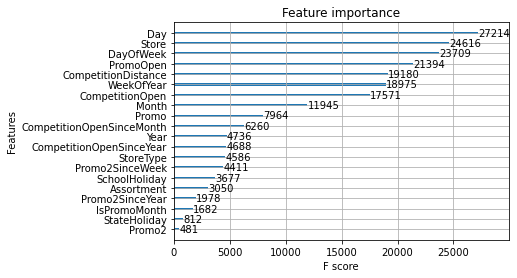

In [44]:
xgb.plot_importance(xgb_model)

In [240]:
'''
# Mit Feature `PromoDaysperWeek`
from time import time
start = time()

dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)

watchlist = [(dtrain, 'train'), (dval, 'eval')]

xgb_model = xgb.train(params, dtrain, 300, evals = watchlist,
                      early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

end = time()
print('Training time is {:2f} s.'.format(end-start))
'''

[21:12:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:7.44353	eval-rmse:7.44255	train-rmspe:0.99953	eval-rmspe:0.99953
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 50 rounds.
[1]	train-rmse:6.70096	eval-rmse:6.70003	train-rmspe:0.99882	eval-rmspe:0.99882
[2]	train-rmse:6.03273	eval-rmse:6.03184	train-rmspe:0.99755	eval-rmspe:0.99755
[3]	train-rmse:5.43147	eval-rmse:5.43062	train-rmspe:0.99541	eval-rmspe:0.99541
[4]	train-rmse:4.89053	eval-rmse:4.88971	train-rmspe:0.99201	eval-rmspe:0.99201
[5]	train-rmse:4.40370	eval-rmse:4.40289	train-rmspe:0.98694	eval-rmspe:0.98694
[6]	train-rmse:3.96585	eval-rmse:3.96505	train-rmspe:0.97972	eval-rmspe:0.97972
[7]	train-rmse:3.57192	eval-rmse:3.57115	train-rmspe:0.96993	eval-rmspe:0.96992
[8]	train-rmse:3.21750	eval-r

[98]	train-rmse:0.13844	eval-rmse:0.14301	train-rmspe:0.16853	eval-rmspe:0.25883
[99]	train-rmse:0.13765	eval-rmse:0.14222	train-rmspe:0.16776	eval-rmspe:0.25828
[100]	train-rmse:0.13682	eval-rmse:0.14142	train-rmspe:0.16686	eval-rmspe:0.25775
[101]	train-rmse:0.13657	eval-rmse:0.14118	train-rmspe:0.16663	eval-rmspe:0.25762
[102]	train-rmse:0.13594	eval-rmse:0.14058	train-rmspe:0.16571	eval-rmspe:0.25722
[103]	train-rmse:0.13533	eval-rmse:0.14004	train-rmspe:0.16490	eval-rmspe:0.25651
[104]	train-rmse:0.13498	eval-rmse:0.13972	train-rmspe:0.16457	eval-rmspe:0.25632
[105]	train-rmse:0.13472	eval-rmse:0.13952	train-rmspe:0.16432	eval-rmspe:0.25636
[106]	train-rmse:0.13403	eval-rmse:0.13884	train-rmspe:0.16361	eval-rmspe:0.25597
[107]	train-rmse:0.13318	eval-rmse:0.13800	train-rmspe:0.16278	eval-rmspe:0.25537
[108]	train-rmse:0.13286	eval-rmse:0.13774	train-rmspe:0.16234	eval-rmspe:0.25511
[109]	train-rmse:0.13261	eval-rmse:0.13750	train-rmspe:0.15854	eval-rmspe:0.25501
[110]	train-rmse:0

[198]	train-rmse:0.10335	eval-rmse:0.11120	train-rmspe:0.11976	eval-rmspe:0.24729
[199]	train-rmse:0.10320	eval-rmse:0.11107	train-rmspe:0.11961	eval-rmspe:0.24722
[200]	train-rmse:0.10297	eval-rmse:0.11087	train-rmspe:0.11937	eval-rmspe:0.24706
[201]	train-rmse:0.10286	eval-rmse:0.11077	train-rmspe:0.11920	eval-rmspe:0.24700
[202]	train-rmse:0.10268	eval-rmse:0.11062	train-rmspe:0.11902	eval-rmspe:0.24694
[203]	train-rmse:0.10260	eval-rmse:0.11057	train-rmspe:0.11893	eval-rmspe:0.24692
[204]	train-rmse:0.10223	eval-rmse:0.11024	train-rmspe:0.11856	eval-rmspe:0.24676
[205]	train-rmse:0.10206	eval-rmse:0.11010	train-rmspe:0.11840	eval-rmspe:0.24649
[206]	train-rmse:0.10175	eval-rmse:0.10982	train-rmspe:0.11810	eval-rmspe:0.24651
[207]	train-rmse:0.10154	eval-rmse:0.10966	train-rmspe:0.11786	eval-rmspe:0.24642
[208]	train-rmse:0.10122	eval-rmse:0.10937	train-rmspe:0.11751	eval-rmspe:0.24630
[209]	train-rmse:0.10092	eval-rmse:0.10911	train-rmspe:0.11724	eval-rmspe:0.24707
[210]	train-rmse

[298]	train-rmse:0.08953	eval-rmse:0.10062	train-rmspe:0.09987	eval-rmspe:0.24419
[299]	train-rmse:0.08946	eval-rmse:0.10056	train-rmspe:0.09978	eval-rmspe:0.24417
[21:16:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
Training time is 258.933487 s.


In [132]:
yhat = xgb_model.predict(xgb.DMatrix(X_val))
error = rmspe(np.exp(y_val), np.exp(yhat))

print('XGboost RMSPE: {:.6f}'.format(error))

XGboost RMSPE: 0.111644


### 3.2 Linear Regression

In [103]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [104]:
linear_model.score(X_val, y_val)

0.21900992972159616

In [105]:
yhat_l = linear_model.predict(X_val)
error = rmspe(np.exp(y_test), np.exp(yhat_l))

print('Linear Model RMSPE: {:.6f}'.format(error))

Linear Model RMSPE: 0.439822


### 3.3 LightGBM

In [123]:
import lightgbm as lgb

In [124]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [156]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
}

In [126]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

def rmspe_lgb(preds, train_data):
    labels = np.expm1(train_data.get_label())
    preds = np.expm1(preds)
    return "rmspe", rmspe(labels, preds), False

In [157]:
start = time()
gbm = lgb.train(params, lgb_train, num_boost_round=20000, valid_sets=lgb_eval, feval=rmspe_lgb,
                early_stopping_rounds=100)
end = time()
print('Training time is: {:2f}s'.format(end-start))

yhat = gbm.predict(X_val)
error = rmspe(np.exp(y_val), np.exp(yhat))

print('LightGBM RMSPE: {:.6f}'.format(error))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's l2: 0.170408	valid_0's rmspe: 0.512027
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.162074	valid_0's rmspe: 0.49349
[3]	valid_0's l2: 0.154876	valid_0's rmspe: 0.477066
[4]	valid_0's l2: 0.148943	valid_0's rmspe: 0.463359
[5]	valid_0's l2: 0.144119	valid_0's rmspe: 0.452867
[6]	valid_0's l2: 0.139518	valid_0's rmspe: 0.443097
[7]	valid_0's l2: 0.135839	valid_0's rmspe: 0.434784
[8]	valid_0's l2: 0.132741	valid_0's rmspe: 0.428162
[9]	valid_0's l2: 0.129903	valid_0's rmspe: 0.422942
[10]	valid_0's l2: 0.127617	valid_0's rmspe: 0.418114
[11]	valid_0's l2: 0.12554	valid_0's rmspe: 0.414441
[12]	valid_0's l2: 0.123614	valid_0's rmspe: 0.41032
[13]	valid_0's l2: 0.121994	valid_0's rmspe: 0.407537
[14]	valid_0's l2: 

[148]	valid_0's l2: 0.0448043	valid_0's rmspe: 0.234557
[149]	valid_0's l2: 0.0446993	valid_0's rmspe: 0.234291
[150]	valid_0's l2: 0.0444899	valid_0's rmspe: 0.23374
[151]	valid_0's l2: 0.044394	valid_0's rmspe: 0.233501
[152]	valid_0's l2: 0.0441207	valid_0's rmspe: 0.232811
[153]	valid_0's l2: 0.0440098	valid_0's rmspe: 0.232403
[154]	valid_0's l2: 0.043905	valid_0's rmspe: 0.232128
[155]	valid_0's l2: 0.0434964	valid_0's rmspe: 0.230988
[156]	valid_0's l2: 0.0433112	valid_0's rmspe: 0.230529
[157]	valid_0's l2: 0.043244	valid_0's rmspe: 0.230373
[158]	valid_0's l2: 0.0430063	valid_0's rmspe: 0.229697
[159]	valid_0's l2: 0.0428366	valid_0's rmspe: 0.229239
[160]	valid_0's l2: 0.0427301	valid_0's rmspe: 0.228937
[161]	valid_0's l2: 0.0424908	valid_0's rmspe: 0.228237
[162]	valid_0's l2: 0.0422969	valid_0's rmspe: 0.227558
[163]	valid_0's l2: 0.0418891	valid_0's rmspe: 0.226374
[164]	valid_0's l2: 0.0417428	valid_0's rmspe: 0.225978
[165]	valid_0's l2: 0.0416515	valid_0's rmspe: 0.225

[295]	valid_0's l2: 0.0269573	valid_0's rmspe: 0.180539
[296]	valid_0's l2: 0.0268785	valid_0's rmspe: 0.1803
[297]	valid_0's l2: 0.026801	valid_0's rmspe: 0.180055
[298]	valid_0's l2: 0.0267418	valid_0's rmspe: 0.179879
[299]	valid_0's l2: 0.0266603	valid_0's rmspe: 0.179591
[300]	valid_0's l2: 0.0265781	valid_0's rmspe: 0.179253
[301]	valid_0's l2: 0.0264734	valid_0's rmspe: 0.178887
[302]	valid_0's l2: 0.0263966	valid_0's rmspe: 0.178629
[303]	valid_0's l2: 0.0263504	valid_0's rmspe: 0.178421
[304]	valid_0's l2: 0.0262819	valid_0's rmspe: 0.178156
[305]	valid_0's l2: 0.0262036	valid_0's rmspe: 0.17789
[306]	valid_0's l2: 0.0260658	valid_0's rmspe: 0.177423
[307]	valid_0's l2: 0.0259965	valid_0's rmspe: 0.177202
[308]	valid_0's l2: 0.0259369	valid_0's rmspe: 0.176966
[309]	valid_0's l2: 0.0258764	valid_0's rmspe: 0.176719
[310]	valid_0's l2: 0.0258057	valid_0's rmspe: 0.176466
[311]	valid_0's l2: 0.0257516	valid_0's rmspe: 0.176237
[312]	valid_0's l2: 0.0257292	valid_0's rmspe: 0.176

[446]	valid_0's l2: 0.0203915	valid_0's rmspe: 0.156506
[447]	valid_0's l2: 0.0203732	valid_0's rmspe: 0.156429
[448]	valid_0's l2: 0.0203571	valid_0's rmspe: 0.156363
[449]	valid_0's l2: 0.0203353	valid_0's rmspe: 0.156244
[450]	valid_0's l2: 0.0203186	valid_0's rmspe: 0.156179
[451]	valid_0's l2: 0.0202894	valid_0's rmspe: 0.156081
[452]	valid_0's l2: 0.0202671	valid_0's rmspe: 0.155985
[453]	valid_0's l2: 0.0202482	valid_0's rmspe: 0.155919
[454]	valid_0's l2: 0.0202193	valid_0's rmspe: 0.155824
[455]	valid_0's l2: 0.0202097	valid_0's rmspe: 0.1558
[456]	valid_0's l2: 0.0201968	valid_0's rmspe: 0.155746
[457]	valid_0's l2: 0.0201839	valid_0's rmspe: 0.155662
[458]	valid_0's l2: 0.0201666	valid_0's rmspe: 0.155556
[459]	valid_0's l2: 0.0201508	valid_0's rmspe: 0.155503
[460]	valid_0's l2: 0.0201318	valid_0's rmspe: 0.155438
[461]	valid_0's l2: 0.0200819	valid_0's rmspe: 0.155232
[462]	valid_0's l2: 0.0200542	valid_0's rmspe: 0.155121
[463]	valid_0's l2: 0.0200403	valid_0's rmspe: 0.1

[597]	valid_0's l2: 0.0173518	valid_0's rmspe: 0.144176
[598]	valid_0's l2: 0.0173297	valid_0's rmspe: 0.1441
[599]	valid_0's l2: 0.0173232	valid_0's rmspe: 0.14408
[600]	valid_0's l2: 0.0173049	valid_0's rmspe: 0.14401
[601]	valid_0's l2: 0.0172846	valid_0's rmspe: 0.143927
[602]	valid_0's l2: 0.0172667	valid_0's rmspe: 0.143858
[603]	valid_0's l2: 0.0172447	valid_0's rmspe: 0.143767
[604]	valid_0's l2: 0.0172333	valid_0's rmspe: 0.14372
[605]	valid_0's l2: 0.0171999	valid_0's rmspe: 0.143583
[606]	valid_0's l2: 0.0171879	valid_0's rmspe: 0.143504
[607]	valid_0's l2: 0.0171663	valid_0's rmspe: 0.143425
[608]	valid_0's l2: 0.0171601	valid_0's rmspe: 0.143407
[609]	valid_0's l2: 0.0171557	valid_0's rmspe: 0.143391
[610]	valid_0's l2: 0.0171465	valid_0's rmspe: 0.143356
[611]	valid_0's l2: 0.0171355	valid_0's rmspe: 0.14329
[612]	valid_0's l2: 0.0171224	valid_0's rmspe: 0.143239
[613]	valid_0's l2: 0.0171062	valid_0's rmspe: 0.143177
[614]	valid_0's l2: 0.0170849	valid_0's rmspe: 0.14307

[746]	valid_0's l2: 0.015293	valid_0's rmspe: 0.135434
[747]	valid_0's l2: 0.0152718	valid_0's rmspe: 0.135344
[748]	valid_0's l2: 0.0152653	valid_0's rmspe: 0.135322
[749]	valid_0's l2: 0.0152552	valid_0's rmspe: 0.135275
[750]	valid_0's l2: 0.0152401	valid_0's rmspe: 0.135214
[751]	valid_0's l2: 0.015227	valid_0's rmspe: 0.135159
[752]	valid_0's l2: 0.0152218	valid_0's rmspe: 0.135122
[753]	valid_0's l2: 0.015214	valid_0's rmspe: 0.135092
[754]	valid_0's l2: 0.0152105	valid_0's rmspe: 0.135077
[755]	valid_0's l2: 0.0151999	valid_0's rmspe: 0.135034
[756]	valid_0's l2: 0.015193	valid_0's rmspe: 0.135003
[757]	valid_0's l2: 0.0151846	valid_0's rmspe: 0.134968
[758]	valid_0's l2: 0.0151729	valid_0's rmspe: 0.13492
[759]	valid_0's l2: 0.0151607	valid_0's rmspe: 0.134877
[760]	valid_0's l2: 0.0151501	valid_0's rmspe: 0.134836
[761]	valid_0's l2: 0.0151387	valid_0's rmspe: 0.13479
[762]	valid_0's l2: 0.0151279	valid_0's rmspe: 0.134744
[763]	valid_0's l2: 0.0151016	valid_0's rmspe: 0.13463

[895]	valid_0's l2: 0.0140786	valid_0's rmspe: 0.130143
[896]	valid_0's l2: 0.0140726	valid_0's rmspe: 0.130117
[897]	valid_0's l2: 0.0140636	valid_0's rmspe: 0.130061
[898]	valid_0's l2: 0.0140602	valid_0's rmspe: 0.130047
[899]	valid_0's l2: 0.0140463	valid_0's rmspe: 0.129985
[900]	valid_0's l2: 0.0140442	valid_0's rmspe: 0.129975
[901]	valid_0's l2: 0.0140395	valid_0's rmspe: 0.129957
[902]	valid_0's l2: 0.0140344	valid_0's rmspe: 0.129937
[903]	valid_0's l2: 0.0140277	valid_0's rmspe: 0.129906
[904]	valid_0's l2: 0.0140239	valid_0's rmspe: 0.129891
[905]	valid_0's l2: 0.014017	valid_0's rmspe: 0.129865
[906]	valid_0's l2: 0.014013	valid_0's rmspe: 0.129847
[907]	valid_0's l2: 0.0140066	valid_0's rmspe: 0.129755
[908]	valid_0's l2: 0.0140001	valid_0's rmspe: 0.129718
[909]	valid_0's l2: 0.0139955	valid_0's rmspe: 0.129701
[910]	valid_0's l2: 0.0139905	valid_0's rmspe: 0.129677
[911]	valid_0's l2: 0.0139847	valid_0's rmspe: 0.129648
[912]	valid_0's l2: 0.0139749	valid_0's rmspe: 0.1

[1043]	valid_0's l2: 0.0131579	valid_0's rmspe: 0.12576
[1044]	valid_0's l2: 0.0131559	valid_0's rmspe: 0.125752
[1045]	valid_0's l2: 0.0131491	valid_0's rmspe: 0.125721
[1046]	valid_0's l2: 0.013137	valid_0's rmspe: 0.125665
[1047]	valid_0's l2: 0.0131334	valid_0's rmspe: 0.125652
[1048]	valid_0's l2: 0.0131281	valid_0's rmspe: 0.12563
[1049]	valid_0's l2: 0.0131255	valid_0's rmspe: 0.125617
[1050]	valid_0's l2: 0.0131228	valid_0's rmspe: 0.125606
[1051]	valid_0's l2: 0.0131196	valid_0's rmspe: 0.125594
[1052]	valid_0's l2: 0.0131167	valid_0's rmspe: 0.125581
[1053]	valid_0's l2: 0.0131056	valid_0's rmspe: 0.12553
[1054]	valid_0's l2: 0.0131006	valid_0's rmspe: 0.12551
[1055]	valid_0's l2: 0.0130986	valid_0's rmspe: 0.125478
[1056]	valid_0's l2: 0.0130944	valid_0's rmspe: 0.125459
[1057]	valid_0's l2: 0.013091	valid_0's rmspe: 0.125445
[1058]	valid_0's l2: 0.0130852	valid_0's rmspe: 0.125419
[1059]	valid_0's l2: 0.013081	valid_0's rmspe: 0.1254
[1060]	valid_0's l2: 0.0130786	valid_0's

[1191]	valid_0's l2: 0.012457	valid_0's rmspe: 0.122542
[1192]	valid_0's l2: 0.0124503	valid_0's rmspe: 0.122508
[1193]	valid_0's l2: 0.0124484	valid_0's rmspe: 0.122497
[1194]	valid_0's l2: 0.0124459	valid_0's rmspe: 0.122483
[1195]	valid_0's l2: 0.012443	valid_0's rmspe: 0.122471
[1196]	valid_0's l2: 0.0124418	valid_0's rmspe: 0.122469
[1197]	valid_0's l2: 0.0124332	valid_0's rmspe: 0.122435
[1198]	valid_0's l2: 0.0124257	valid_0's rmspe: 0.122413
[1199]	valid_0's l2: 0.0124244	valid_0's rmspe: 0.12241
[1200]	valid_0's l2: 0.012416	valid_0's rmspe: 0.12237
[1201]	valid_0's l2: 0.0124147	valid_0's rmspe: 0.122362
[1202]	valid_0's l2: 0.0123982	valid_0's rmspe: 0.122283
[1203]	valid_0's l2: 0.0123974	valid_0's rmspe: 0.122278
[1204]	valid_0's l2: 0.0123953	valid_0's rmspe: 0.122265
[1205]	valid_0's l2: 0.012394	valid_0's rmspe: 0.122257
[1206]	valid_0's l2: 0.0123914	valid_0's rmspe: 0.122243
[1207]	valid_0's l2: 0.012388	valid_0's rmspe: 0.122228
[1208]	valid_0's l2: 0.0123817	valid_0

[1339]	valid_0's l2: 0.0119537	valid_0's rmspe: 0.120123
[1340]	valid_0's l2: 0.0119526	valid_0's rmspe: 0.120119
[1341]	valid_0's l2: 0.0119496	valid_0's rmspe: 0.120106
[1342]	valid_0's l2: 0.0119477	valid_0's rmspe: 0.120098
[1343]	valid_0's l2: 0.0119431	valid_0's rmspe: 0.12003
[1344]	valid_0's l2: 0.0119386	valid_0's rmspe: 0.120012
[1345]	valid_0's l2: 0.0119317	valid_0's rmspe: 0.119982
[1346]	valid_0's l2: 0.0119301	valid_0's rmspe: 0.119966
[1347]	valid_0's l2: 0.0119271	valid_0's rmspe: 0.11995
[1348]	valid_0's l2: 0.0119257	valid_0's rmspe: 0.119948
[1349]	valid_0's l2: 0.011924	valid_0's rmspe: 0.119942
[1350]	valid_0's l2: 0.0119158	valid_0's rmspe: 0.119907
[1351]	valid_0's l2: 0.0119149	valid_0's rmspe: 0.119904
[1352]	valid_0's l2: 0.0119135	valid_0's rmspe: 0.119899
[1353]	valid_0's l2: 0.0119117	valid_0's rmspe: 0.119891
[1354]	valid_0's l2: 0.011911	valid_0's rmspe: 0.119888
[1355]	valid_0's l2: 0.0119094	valid_0's rmspe: 0.119883
[1356]	valid_0's l2: 0.0119086	vali

[1488]	valid_0's l2: 0.0115424	valid_0's rmspe: 0.117969
[1489]	valid_0's l2: 0.0115398	valid_0's rmspe: 0.117958
[1490]	valid_0's l2: 0.0115377	valid_0's rmspe: 0.117943
[1491]	valid_0's l2: 0.0115352	valid_0's rmspe: 0.117935
[1492]	valid_0's l2: 0.0115344	valid_0's rmspe: 0.117933
[1493]	valid_0's l2: 0.0115308	valid_0's rmspe: 0.117915
[1494]	valid_0's l2: 0.0115291	valid_0's rmspe: 0.117909
[1495]	valid_0's l2: 0.0115245	valid_0's rmspe: 0.117886
[1496]	valid_0's l2: 0.0115215	valid_0's rmspe: 0.117871
[1497]	valid_0's l2: 0.0115204	valid_0's rmspe: 0.117867
[1498]	valid_0's l2: 0.0115175	valid_0's rmspe: 0.117855
[1499]	valid_0's l2: 0.0115161	valid_0's rmspe: 0.117845
[1500]	valid_0's l2: 0.0115135	valid_0's rmspe: 0.117837
[1501]	valid_0's l2: 0.01151	valid_0's rmspe: 0.117823
[1502]	valid_0's l2: 0.0115055	valid_0's rmspe: 0.117801
[1503]	valid_0's l2: 0.0115026	valid_0's rmspe: 0.117789
[1504]	valid_0's l2: 0.0115014	valid_0's rmspe: 0.117784
[1505]	valid_0's l2: 0.0115005	va

[1636]	valid_0's l2: 0.011217	valid_0's rmspe: 0.11626
[1637]	valid_0's l2: 0.0112103	valid_0's rmspe: 0.116229
[1638]	valid_0's l2: 0.0112083	valid_0's rmspe: 0.116218
[1639]	valid_0's l2: 0.0112054	valid_0's rmspe: 0.116203
[1640]	valid_0's l2: 0.0112044	valid_0's rmspe: 0.116198
[1641]	valid_0's l2: 0.0112008	valid_0's rmspe: 0.116181
[1642]	valid_0's l2: 0.0111969	valid_0's rmspe: 0.116165
[1643]	valid_0's l2: 0.0111923	valid_0's rmspe: 0.116144
[1644]	valid_0's l2: 0.0111904	valid_0's rmspe: 0.116132
[1645]	valid_0's l2: 0.01119	valid_0's rmspe: 0.11613
[1646]	valid_0's l2: 0.0111892	valid_0's rmspe: 0.116127
[1647]	valid_0's l2: 0.0111867	valid_0's rmspe: 0.116116
[1648]	valid_0's l2: 0.0111834	valid_0's rmspe: 0.116099
[1649]	valid_0's l2: 0.0111812	valid_0's rmspe: 0.116086
[1650]	valid_0's l2: 0.0111789	valid_0's rmspe: 0.116077
[1651]	valid_0's l2: 0.0111775	valid_0's rmspe: 0.116068
[1652]	valid_0's l2: 0.0111751	valid_0's rmspe: 0.116041
[1653]	valid_0's l2: 0.0111735	valid

[1783]	valid_0's l2: 0.0109215	valid_0's rmspe: 0.114832
[1784]	valid_0's l2: 0.0109207	valid_0's rmspe: 0.114829
[1785]	valid_0's l2: 0.0109183	valid_0's rmspe: 0.114819
[1786]	valid_0's l2: 0.0109169	valid_0's rmspe: 0.114806
[1787]	valid_0's l2: 0.0109155	valid_0's rmspe: 0.114794
[1788]	valid_0's l2: 0.0109141	valid_0's rmspe: 0.114786
[1789]	valid_0's l2: 0.0109128	valid_0's rmspe: 0.114778
[1790]	valid_0's l2: 0.0109126	valid_0's rmspe: 0.114775
[1791]	valid_0's l2: 0.010912	valid_0's rmspe: 0.114775
[1792]	valid_0's l2: 0.0109113	valid_0's rmspe: 0.114776
[1793]	valid_0's l2: 0.0109106	valid_0's rmspe: 0.114776
[1794]	valid_0's l2: 0.0109101	valid_0's rmspe: 0.114778
[1795]	valid_0's l2: 0.0109091	valid_0's rmspe: 0.114776
[1796]	valid_0's l2: 0.0109058	valid_0's rmspe: 0.114763
[1797]	valid_0's l2: 0.0109053	valid_0's rmspe: 0.114762
[1798]	valid_0's l2: 0.0109039	valid_0's rmspe: 0.114758
[1799]	valid_0's l2: 0.010903	valid_0's rmspe: 0.114756
[1800]	valid_0's l2: 0.0109002	va

[1932]	valid_0's l2: 0.0106813	valid_0's rmspe: 0.113611
[1933]	valid_0's l2: 0.0106781	valid_0's rmspe: 0.113587
[1934]	valid_0's l2: 0.0106776	valid_0's rmspe: 0.113586
[1935]	valid_0's l2: 0.0106767	valid_0's rmspe: 0.113581
[1936]	valid_0's l2: 0.0106762	valid_0's rmspe: 0.11358
[1937]	valid_0's l2: 0.0106755	valid_0's rmspe: 0.113576
[1938]	valid_0's l2: 0.0106744	valid_0's rmspe: 0.113573
[1939]	valid_0's l2: 0.0106732	valid_0's rmspe: 0.11356
[1940]	valid_0's l2: 0.0106726	valid_0's rmspe: 0.113558
[1941]	valid_0's l2: 0.0106721	valid_0's rmspe: 0.113557
[1942]	valid_0's l2: 0.0106719	valid_0's rmspe: 0.113556
[1943]	valid_0's l2: 0.0106718	valid_0's rmspe: 0.113556
[1944]	valid_0's l2: 0.0106706	valid_0's rmspe: 0.113551
[1945]	valid_0's l2: 0.0106692	valid_0's rmspe: 0.113545
[1946]	valid_0's l2: 0.0106683	valid_0's rmspe: 0.113544
[1947]	valid_0's l2: 0.0106671	valid_0's rmspe: 0.113541
[1948]	valid_0's l2: 0.010666	valid_0's rmspe: 0.113536
[1949]	valid_0's l2: 0.0106654	val

[2077]	valid_0's l2: 0.010468	valid_0's rmspe: 0.112535
[2078]	valid_0's l2: 0.0104673	valid_0's rmspe: 0.11253
[2079]	valid_0's l2: 0.0104659	valid_0's rmspe: 0.112522
[2080]	valid_0's l2: 0.0104647	valid_0's rmspe: 0.112516
[2081]	valid_0's l2: 0.0104566	valid_0's rmspe: 0.112477
[2082]	valid_0's l2: 0.0104556	valid_0's rmspe: 0.11247
[2083]	valid_0's l2: 0.0104544	valid_0's rmspe: 0.112466
[2084]	valid_0's l2: 0.0104509	valid_0's rmspe: 0.112454
[2085]	valid_0's l2: 0.0104496	valid_0's rmspe: 0.112448
[2086]	valid_0's l2: 0.0104483	valid_0's rmspe: 0.112441
[2087]	valid_0's l2: 0.0104474	valid_0's rmspe: 0.112438
[2088]	valid_0's l2: 0.010445	valid_0's rmspe: 0.112428
[2089]	valid_0's l2: 0.0104434	valid_0's rmspe: 0.112419
[2090]	valid_0's l2: 0.010443	valid_0's rmspe: 0.112418
[2091]	valid_0's l2: 0.0104409	valid_0's rmspe: 0.112408
[2092]	valid_0's l2: 0.0104401	valid_0's rmspe: 0.112404
[2093]	valid_0's l2: 0.0104398	valid_0's rmspe: 0.112401
[2094]	valid_0's l2: 0.0104368	valid

[2223]	valid_0's l2: 0.0102435	valid_0's rmspe: 0.111401
[2224]	valid_0's l2: 0.0102426	valid_0's rmspe: 0.111397
[2225]	valid_0's l2: 0.0102416	valid_0's rmspe: 0.11139
[2226]	valid_0's l2: 0.0102412	valid_0's rmspe: 0.111388
[2227]	valid_0's l2: 0.0102407	valid_0's rmspe: 0.111387
[2228]	valid_0's l2: 0.0102402	valid_0's rmspe: 0.111385
[2229]	valid_0's l2: 0.0102399	valid_0's rmspe: 0.111384
[2230]	valid_0's l2: 0.0102396	valid_0's rmspe: 0.111383
[2231]	valid_0's l2: 0.0102389	valid_0's rmspe: 0.111381
[2232]	valid_0's l2: 0.0102383	valid_0's rmspe: 0.111379
[2233]	valid_0's l2: 0.0102369	valid_0's rmspe: 0.111373
[2234]	valid_0's l2: 0.0102362	valid_0's rmspe: 0.111371
[2235]	valid_0's l2: 0.010235	valid_0's rmspe: 0.111366
[2236]	valid_0's l2: 0.0102329	valid_0's rmspe: 0.111349
[2237]	valid_0's l2: 0.010232	valid_0's rmspe: 0.111344
[2238]	valid_0's l2: 0.0102301	valid_0's rmspe: 0.111334
[2239]	valid_0's l2: 0.0102282	valid_0's rmspe: 0.111317
[2240]	valid_0's l2: 0.0102268	val

[2370]	valid_0's l2: 0.0100919	valid_0's rmspe: 0.110654
[2371]	valid_0's l2: 0.0100915	valid_0's rmspe: 0.110653
[2372]	valid_0's l2: 0.0100901	valid_0's rmspe: 0.110648
[2373]	valid_0's l2: 0.0100893	valid_0's rmspe: 0.110646
[2374]	valid_0's l2: 0.0100879	valid_0's rmspe: 0.11064
[2375]	valid_0's l2: 0.010087	valid_0's rmspe: 0.110637
[2376]	valid_0's l2: 0.0100861	valid_0's rmspe: 0.110633
[2377]	valid_0's l2: 0.0100854	valid_0's rmspe: 0.11063
[2378]	valid_0's l2: 0.0100851	valid_0's rmspe: 0.11063
[2379]	valid_0's l2: 0.0100834	valid_0's rmspe: 0.110619
[2380]	valid_0's l2: 0.0100832	valid_0's rmspe: 0.110618
[2381]	valid_0's l2: 0.0100802	valid_0's rmspe: 0.110602
[2382]	valid_0's l2: 0.0100796	valid_0's rmspe: 0.110598
[2383]	valid_0's l2: 0.0100791	valid_0's rmspe: 0.110595
[2384]	valid_0's l2: 0.0100775	valid_0's rmspe: 0.110586
[2385]	valid_0's l2: 0.0100754	valid_0's rmspe: 0.110573
[2386]	valid_0's l2: 0.0100751	valid_0's rmspe: 0.110572
[2387]	valid_0's l2: 0.0100748	vali

[2515]	valid_0's l2: 0.00992248	valid_0's rmspe: 0.109845
[2516]	valid_0's l2: 0.00992126	valid_0's rmspe: 0.109842
[2517]	valid_0's l2: 0.00992073	valid_0's rmspe: 0.109841
[2518]	valid_0's l2: 0.00992043	valid_0's rmspe: 0.109841
[2519]	valid_0's l2: 0.0099201	valid_0's rmspe: 0.10984
[2520]	valid_0's l2: 0.00991806	valid_0's rmspe: 0.109832
[2521]	valid_0's l2: 0.00991767	valid_0's rmspe: 0.10983
[2522]	valid_0's l2: 0.00991746	valid_0's rmspe: 0.109828
[2523]	valid_0's l2: 0.00991756	valid_0's rmspe: 0.109827
[2524]	valid_0's l2: 0.00991384	valid_0's rmspe: 0.109807
[2525]	valid_0's l2: 0.00990982	valid_0's rmspe: 0.109785
[2526]	valid_0's l2: 0.00990945	valid_0's rmspe: 0.109783
[2527]	valid_0's l2: 0.00990754	valid_0's rmspe: 0.109774
[2528]	valid_0's l2: 0.0099068	valid_0's rmspe: 0.109769
[2529]	valid_0's l2: 0.00990626	valid_0's rmspe: 0.109766
[2530]	valid_0's l2: 0.00990542	valid_0's rmspe: 0.109762
[2531]	valid_0's l2: 0.00990492	valid_0's rmspe: 0.109758
[2532]	valid_0's l

[2657]	valid_0's l2: 0.00977395	valid_0's rmspe: 0.109021
[2658]	valid_0's l2: 0.00977307	valid_0's rmspe: 0.109018
[2659]	valid_0's l2: 0.00977271	valid_0's rmspe: 0.109017
[2660]	valid_0's l2: 0.00977187	valid_0's rmspe: 0.108995
[2661]	valid_0's l2: 0.00977128	valid_0's rmspe: 0.108991
[2662]	valid_0's l2: 0.00977046	valid_0's rmspe: 0.108988
[2663]	valid_0's l2: 0.00977009	valid_0's rmspe: 0.108986
[2664]	valid_0's l2: 0.00976926	valid_0's rmspe: 0.108982
[2665]	valid_0's l2: 0.00976844	valid_0's rmspe: 0.10898
[2666]	valid_0's l2: 0.00976346	valid_0's rmspe: 0.108953
[2667]	valid_0's l2: 0.0097593	valid_0's rmspe: 0.108935
[2668]	valid_0's l2: 0.00975809	valid_0's rmspe: 0.108928
[2669]	valid_0's l2: 0.0097569	valid_0's rmspe: 0.108921
[2670]	valid_0's l2: 0.00975483	valid_0's rmspe: 0.108909
[2671]	valid_0's l2: 0.00975419	valid_0's rmspe: 0.108906
[2672]	valid_0's l2: 0.00975344	valid_0's rmspe: 0.108905
[2673]	valid_0's l2: 0.00975292	valid_0's rmspe: 0.108903
[2674]	valid_0's 

[2800]	valid_0's l2: 0.0096594	valid_0's rmspe: 0.108403
[2801]	valid_0's l2: 0.00965924	valid_0's rmspe: 0.108404
[2802]	valid_0's l2: 0.00965895	valid_0's rmspe: 0.108402
[2803]	valid_0's l2: 0.00965892	valid_0's rmspe: 0.108402
[2804]	valid_0's l2: 0.00965813	valid_0's rmspe: 0.108398
[2805]	valid_0's l2: 0.00965706	valid_0's rmspe: 0.108395
[2806]	valid_0's l2: 0.00965647	valid_0's rmspe: 0.108381
[2807]	valid_0's l2: 0.00965582	valid_0's rmspe: 0.108376
[2808]	valid_0's l2: 0.00965524	valid_0's rmspe: 0.10839
[2809]	valid_0's l2: 0.00965445	valid_0's rmspe: 0.108387
[2810]	valid_0's l2: 0.00965378	valid_0's rmspe: 0.108386
[2811]	valid_0's l2: 0.00965172	valid_0's rmspe: 0.108378
[2812]	valid_0's l2: 0.00965122	valid_0's rmspe: 0.108378
[2813]	valid_0's l2: 0.0096509	valid_0's rmspe: 0.108378
[2814]	valid_0's l2: 0.00964904	valid_0's rmspe: 0.108371
[2815]	valid_0's l2: 0.00964845	valid_0's rmspe: 0.108369
[2816]	valid_0's l2: 0.00964739	valid_0's rmspe: 0.108359
[2817]	valid_0's 

[2942]	valid_0's l2: 0.00954192	valid_0's rmspe: 0.107843
[2943]	valid_0's l2: 0.00954162	valid_0's rmspe: 0.10784
[2944]	valid_0's l2: 0.00954104	valid_0's rmspe: 0.107838
[2945]	valid_0's l2: 0.00953889	valid_0's rmspe: 0.10783
[2946]	valid_0's l2: 0.00953836	valid_0's rmspe: 0.107829
[2947]	valid_0's l2: 0.00953739	valid_0's rmspe: 0.107824
[2948]	valid_0's l2: 0.00953614	valid_0's rmspe: 0.107817
[2949]	valid_0's l2: 0.0095357	valid_0's rmspe: 0.107814
[2950]	valid_0's l2: 0.00953466	valid_0's rmspe: 0.10781
[2951]	valid_0's l2: 0.00953433	valid_0's rmspe: 0.107806
[2952]	valid_0's l2: 0.00953333	valid_0's rmspe: 0.107804
[2953]	valid_0's l2: 0.00953293	valid_0's rmspe: 0.107801
[2954]	valid_0's l2: 0.00953232	valid_0's rmspe: 0.107796
[2955]	valid_0's l2: 0.00953151	valid_0's rmspe: 0.107788
[2956]	valid_0's l2: 0.0095301	valid_0's rmspe: 0.107781
[2957]	valid_0's l2: 0.00952978	valid_0's rmspe: 0.107779
[2958]	valid_0's l2: 0.0095293	valid_0's rmspe: 0.107778
[2959]	valid_0's l2:

[3084]	valid_0's l2: 0.00943145	valid_0's rmspe: 0.107261
[3085]	valid_0's l2: 0.00942927	valid_0's rmspe: 0.107251
[3086]	valid_0's l2: 0.0094289	valid_0's rmspe: 0.107248
[3087]	valid_0's l2: 0.00942857	valid_0's rmspe: 0.107244
[3088]	valid_0's l2: 0.00942801	valid_0's rmspe: 0.10724
[3089]	valid_0's l2: 0.00942689	valid_0's rmspe: 0.107235
[3090]	valid_0's l2: 0.00942625	valid_0's rmspe: 0.107234
[3091]	valid_0's l2: 0.00942594	valid_0's rmspe: 0.107232
[3092]	valid_0's l2: 0.00942568	valid_0's rmspe: 0.107231
[3093]	valid_0's l2: 0.00942558	valid_0's rmspe: 0.107231
[3094]	valid_0's l2: 0.009425	valid_0's rmspe: 0.107228
[3095]	valid_0's l2: 0.00942488	valid_0's rmspe: 0.107227
[3096]	valid_0's l2: 0.00942244	valid_0's rmspe: 0.107215
[3097]	valid_0's l2: 0.00942215	valid_0's rmspe: 0.107219
[3098]	valid_0's l2: 0.0094205	valid_0's rmspe: 0.107211
[3099]	valid_0's l2: 0.00941973	valid_0's rmspe: 0.107206
[3100]	valid_0's l2: 0.00941916	valid_0's rmspe: 0.107203
[3101]	valid_0's l2

[3229]	valid_0's l2: 0.00933453	valid_0's rmspe: 0.106748
[3230]	valid_0's l2: 0.00933418	valid_0's rmspe: 0.106746
[3231]	valid_0's l2: 0.00933391	valid_0's rmspe: 0.106746
[3232]	valid_0's l2: 0.00933353	valid_0's rmspe: 0.106746
[3233]	valid_0's l2: 0.00933318	valid_0's rmspe: 0.106745
[3234]	valid_0's l2: 0.00933299	valid_0's rmspe: 0.106746
[3235]	valid_0's l2: 0.00933276	valid_0's rmspe: 0.106746
[3236]	valid_0's l2: 0.00933185	valid_0's rmspe: 0.106743
[3237]	valid_0's l2: 0.00933141	valid_0's rmspe: 0.106742
[3238]	valid_0's l2: 0.00933129	valid_0's rmspe: 0.106741
[3239]	valid_0's l2: 0.00933076	valid_0's rmspe: 0.106739
[3240]	valid_0's l2: 0.00933057	valid_0's rmspe: 0.106738
[3241]	valid_0's l2: 0.00933026	valid_0's rmspe: 0.106735
[3242]	valid_0's l2: 0.00933014	valid_0's rmspe: 0.106733
[3243]	valid_0's l2: 0.00932946	valid_0's rmspe: 0.106728
[3244]	valid_0's l2: 0.00932901	valid_0's rmspe: 0.106725
[3245]	valid_0's l2: 0.00932809	valid_0's rmspe: 0.106721
[3246]	valid_0

[3375]	valid_0's l2: 0.00925515	valid_0's rmspe: 0.106318
[3376]	valid_0's l2: 0.00925462	valid_0's rmspe: 0.106315
[3377]	valid_0's l2: 0.00925426	valid_0's rmspe: 0.106313
[3378]	valid_0's l2: 0.00925359	valid_0's rmspe: 0.10631
[3379]	valid_0's l2: 0.00925358	valid_0's rmspe: 0.106311
[3380]	valid_0's l2: 0.00925328	valid_0's rmspe: 0.106312
[3381]	valid_0's l2: 0.00925321	valid_0's rmspe: 0.106313
[3382]	valid_0's l2: 0.00925312	valid_0's rmspe: 0.106313
[3383]	valid_0's l2: 0.00925267	valid_0's rmspe: 0.106311
[3384]	valid_0's l2: 0.00925206	valid_0's rmspe: 0.106308
[3385]	valid_0's l2: 0.00925172	valid_0's rmspe: 0.106306
[3386]	valid_0's l2: 0.00925139	valid_0's rmspe: 0.106293
[3387]	valid_0's l2: 0.00925028	valid_0's rmspe: 0.106288
[3388]	valid_0's l2: 0.00925003	valid_0's rmspe: 0.106287
[3389]	valid_0's l2: 0.0092488	valid_0's rmspe: 0.10628
[3390]	valid_0's l2: 0.00924742	valid_0's rmspe: 0.106271
[3391]	valid_0's l2: 0.0092464	valid_0's rmspe: 0.106266
[3392]	valid_0's l

[3518]	valid_0's l2: 0.00918336	valid_0's rmspe: 0.10596
[3519]	valid_0's l2: 0.00918293	valid_0's rmspe: 0.105959
[3520]	valid_0's l2: 0.00918257	valid_0's rmspe: 0.105957
[3521]	valid_0's l2: 0.00918215	valid_0's rmspe: 0.105956
[3522]	valid_0's l2: 0.00918182	valid_0's rmspe: 0.105956
[3523]	valid_0's l2: 0.00918062	valid_0's rmspe: 0.105951
[3524]	valid_0's l2: 0.0091798	valid_0's rmspe: 0.105948
[3525]	valid_0's l2: 0.00917935	valid_0's rmspe: 0.105947
[3526]	valid_0's l2: 0.00917908	valid_0's rmspe: 0.105945
[3527]	valid_0's l2: 0.0091787	valid_0's rmspe: 0.105943
[3528]	valid_0's l2: 0.00917856	valid_0's rmspe: 0.105942
[3529]	valid_0's l2: 0.00917844	valid_0's rmspe: 0.105941
[3530]	valid_0's l2: 0.00917774	valid_0's rmspe: 0.105939
[3531]	valid_0's l2: 0.00917716	valid_0's rmspe: 0.105936
[3532]	valid_0's l2: 0.00917628	valid_0's rmspe: 0.105931
[3533]	valid_0's l2: 0.0091761	valid_0's rmspe: 0.10593
[3534]	valid_0's l2: 0.00917587	valid_0's rmspe: 0.105928
[3535]	valid_0's l2

[3660]	valid_0's l2: 0.00912501	valid_0's rmspe: 0.105638
[3661]	valid_0's l2: 0.00912472	valid_0's rmspe: 0.105637
[3662]	valid_0's l2: 0.00912429	valid_0's rmspe: 0.105636
[3663]	valid_0's l2: 0.00912411	valid_0's rmspe: 0.105636
[3664]	valid_0's l2: 0.00912312	valid_0's rmspe: 0.105631
[3665]	valid_0's l2: 0.00912261	valid_0's rmspe: 0.105629
[3666]	valid_0's l2: 0.00912237	valid_0's rmspe: 0.10563
[3667]	valid_0's l2: 0.00912096	valid_0's rmspe: 0.105626
[3668]	valid_0's l2: 0.00912004	valid_0's rmspe: 0.105624
[3669]	valid_0's l2: 0.00911965	valid_0's rmspe: 0.105624
[3670]	valid_0's l2: 0.00911943	valid_0's rmspe: 0.105624
[3671]	valid_0's l2: 0.00911893	valid_0's rmspe: 0.105621
[3672]	valid_0's l2: 0.00911869	valid_0's rmspe: 0.10562
[3673]	valid_0's l2: 0.00911856	valid_0's rmspe: 0.105619
[3674]	valid_0's l2: 0.00911793	valid_0's rmspe: 0.105616
[3675]	valid_0's l2: 0.00911743	valid_0's rmspe: 0.105615
[3676]	valid_0's l2: 0.00911609	valid_0's rmspe: 0.105609
[3677]	valid_0's

[3806]	valid_0's l2: 0.00905376	valid_0's rmspe: 0.105276
[3807]	valid_0's l2: 0.00905278	valid_0's rmspe: 0.105272
[3808]	valid_0's l2: 0.00905247	valid_0's rmspe: 0.105271
[3809]	valid_0's l2: 0.00905148	valid_0's rmspe: 0.105267
[3810]	valid_0's l2: 0.00905144	valid_0's rmspe: 0.105267
[3811]	valid_0's l2: 0.00904963	valid_0's rmspe: 0.105259
[3812]	valid_0's l2: 0.00904919	valid_0's rmspe: 0.105257
[3813]	valid_0's l2: 0.00904842	valid_0's rmspe: 0.105255
[3814]	valid_0's l2: 0.00904814	valid_0's rmspe: 0.105254
[3815]	valid_0's l2: 0.00904622	valid_0's rmspe: 0.105244
[3816]	valid_0's l2: 0.00904564	valid_0's rmspe: 0.10524
[3817]	valid_0's l2: 0.00904475	valid_0's rmspe: 0.105236
[3818]	valid_0's l2: 0.0090446	valid_0's rmspe: 0.105234
[3819]	valid_0's l2: 0.0090444	valid_0's rmspe: 0.105232
[3820]	valid_0's l2: 0.00904394	valid_0's rmspe: 0.10523
[3821]	valid_0's l2: 0.00904193	valid_0's rmspe: 0.10522
[3822]	valid_0's l2: 0.00904152	valid_0's rmspe: 0.105218
[3823]	valid_0's l2

[3951]	valid_0's l2: 0.0089904	valid_0's rmspe: 0.104962
[3952]	valid_0's l2: 0.00899024	valid_0's rmspe: 0.104963
[3953]	valid_0's l2: 0.0089886	valid_0's rmspe: 0.104956
[3954]	valid_0's l2: 0.00898809	valid_0's rmspe: 0.104955
[3955]	valid_0's l2: 0.00898786	valid_0's rmspe: 0.104956
[3956]	valid_0's l2: 0.00898752	valid_0's rmspe: 0.104954
[3957]	valid_0's l2: 0.00898746	valid_0's rmspe: 0.104954
[3958]	valid_0's l2: 0.00898729	valid_0's rmspe: 0.104954
[3959]	valid_0's l2: 0.00898644	valid_0's rmspe: 0.104949
[3960]	valid_0's l2: 0.00898608	valid_0's rmspe: 0.104947
[3961]	valid_0's l2: 0.00898595	valid_0's rmspe: 0.104945
[3962]	valid_0's l2: 0.00898566	valid_0's rmspe: 0.104946
[3963]	valid_0's l2: 0.00898524	valid_0's rmspe: 0.104944
[3964]	valid_0's l2: 0.00898522	valid_0's rmspe: 0.104944
[3965]	valid_0's l2: 0.00898495	valid_0's rmspe: 0.104942
[3966]	valid_0's l2: 0.00898462	valid_0's rmspe: 0.104939
[3967]	valid_0's l2: 0.00898424	valid_0's rmspe: 0.104936
[3968]	valid_0's

[4096]	valid_0's l2: 0.00893261	valid_0's rmspe: 0.104679
[4097]	valid_0's l2: 0.00893203	valid_0's rmspe: 0.104675
[4098]	valid_0's l2: 0.00893175	valid_0's rmspe: 0.104672
[4099]	valid_0's l2: 0.00893149	valid_0's rmspe: 0.104669
[4100]	valid_0's l2: 0.00893068	valid_0's rmspe: 0.104665
[4101]	valid_0's l2: 0.00893033	valid_0's rmspe: 0.104666
[4102]	valid_0's l2: 0.00892964	valid_0's rmspe: 0.104665
[4103]	valid_0's l2: 0.00892921	valid_0's rmspe: 0.104664
[4104]	valid_0's l2: 0.00892829	valid_0's rmspe: 0.104658
[4105]	valid_0's l2: 0.00892845	valid_0's rmspe: 0.104656
[4106]	valid_0's l2: 0.00892669	valid_0's rmspe: 0.104648
[4107]	valid_0's l2: 0.00892652	valid_0's rmspe: 0.104648
[4108]	valid_0's l2: 0.00892648	valid_0's rmspe: 0.104647
[4109]	valid_0's l2: 0.0089259	valid_0's rmspe: 0.104648
[4110]	valid_0's l2: 0.00892575	valid_0's rmspe: 0.104647
[4111]	valid_0's l2: 0.00892574	valid_0's rmspe: 0.104646
[4112]	valid_0's l2: 0.00892451	valid_0's rmspe: 0.1046
[4113]	valid_0's 

[4240]	valid_0's l2: 0.00887264	valid_0's rmspe: 0.104326
[4241]	valid_0's l2: 0.0088725	valid_0's rmspe: 0.104325
[4242]	valid_0's l2: 0.00887161	valid_0's rmspe: 0.104319
[4243]	valid_0's l2: 0.00887135	valid_0's rmspe: 0.104318
[4244]	valid_0's l2: 0.00887074	valid_0's rmspe: 0.104317
[4245]	valid_0's l2: 0.00887041	valid_0's rmspe: 0.104314
[4246]	valid_0's l2: 0.00887012	valid_0's rmspe: 0.104316
[4247]	valid_0's l2: 0.00886938	valid_0's rmspe: 0.10431
[4248]	valid_0's l2: 0.00886919	valid_0's rmspe: 0.104309
[4249]	valid_0's l2: 0.00886878	valid_0's rmspe: 0.104306
[4250]	valid_0's l2: 0.00886878	valid_0's rmspe: 0.104305
[4251]	valid_0's l2: 0.00886844	valid_0's rmspe: 0.104305
[4252]	valid_0's l2: 0.00886865	valid_0's rmspe: 0.104306
[4253]	valid_0's l2: 0.00886779	valid_0's rmspe: 0.104303
[4254]	valid_0's l2: 0.00886772	valid_0's rmspe: 0.104302
[4255]	valid_0's l2: 0.00886642	valid_0's rmspe: 0.104297
[4256]	valid_0's l2: 0.00886558	valid_0's rmspe: 0.104281
[4257]	valid_0's

[4384]	valid_0's l2: 0.00881893	valid_0's rmspe: 0.10406
[4385]	valid_0's l2: 0.00881858	valid_0's rmspe: 0.104059
[4386]	valid_0's l2: 0.00881818	valid_0's rmspe: 0.104057
[4387]	valid_0's l2: 0.00881785	valid_0's rmspe: 0.104055
[4388]	valid_0's l2: 0.00881751	valid_0's rmspe: 0.104053
[4389]	valid_0's l2: 0.00881746	valid_0's rmspe: 0.104053
[4390]	valid_0's l2: 0.00881741	valid_0's rmspe: 0.104053
[4391]	valid_0's l2: 0.00881723	valid_0's rmspe: 0.104052
[4392]	valid_0's l2: 0.00881685	valid_0's rmspe: 0.10405
[4393]	valid_0's l2: 0.00881584	valid_0's rmspe: 0.104042
[4394]	valid_0's l2: 0.00881516	valid_0's rmspe: 0.104039
[4395]	valid_0's l2: 0.0088146	valid_0's rmspe: 0.104037
[4396]	valid_0's l2: 0.00881441	valid_0's rmspe: 0.104035
[4397]	valid_0's l2: 0.00881415	valid_0's rmspe: 0.104034
[4398]	valid_0's l2: 0.00881413	valid_0's rmspe: 0.104034
[4399]	valid_0's l2: 0.00881331	valid_0's rmspe: 0.104031
[4400]	valid_0's l2: 0.00881232	valid_0's rmspe: 0.104025
[4401]	valid_0's 

[4529]	valid_0's l2: 0.00877404	valid_0's rmspe: 0.103824
[4530]	valid_0's l2: 0.00877391	valid_0's rmspe: 0.103824
[4531]	valid_0's l2: 0.0087736	valid_0's rmspe: 0.103822
[4532]	valid_0's l2: 0.00877273	valid_0's rmspe: 0.103817
[4533]	valid_0's l2: 0.00877253	valid_0's rmspe: 0.103817
[4534]	valid_0's l2: 0.00877175	valid_0's rmspe: 0.103812
[4535]	valid_0's l2: 0.00877152	valid_0's rmspe: 0.103811
[4536]	valid_0's l2: 0.00877108	valid_0's rmspe: 0.103808
[4537]	valid_0's l2: 0.00877084	valid_0's rmspe: 0.103807
[4538]	valid_0's l2: 0.00877076	valid_0's rmspe: 0.103806
[4539]	valid_0's l2: 0.00877027	valid_0's rmspe: 0.103805
[4540]	valid_0's l2: 0.00877028	valid_0's rmspe: 0.103805
[4541]	valid_0's l2: 0.0087699	valid_0's rmspe: 0.103802
[4542]	valid_0's l2: 0.00876984	valid_0's rmspe: 0.103802
[4543]	valid_0's l2: 0.00876953	valid_0's rmspe: 0.1038
[4544]	valid_0's l2: 0.00876937	valid_0's rmspe: 0.103799
[4545]	valid_0's l2: 0.00876925	valid_0's rmspe: 0.103798
[4546]	valid_0's l

[4674]	valid_0's l2: 0.00872788	valid_0's rmspe: 0.103566
[4675]	valid_0's l2: 0.0087278	valid_0's rmspe: 0.103566
[4676]	valid_0's l2: 0.00872765	valid_0's rmspe: 0.103567
[4677]	valid_0's l2: 0.00872753	valid_0's rmspe: 0.103567
[4678]	valid_0's l2: 0.00872745	valid_0's rmspe: 0.103568
[4679]	valid_0's l2: 0.0087271	valid_0's rmspe: 0.103567
[4680]	valid_0's l2: 0.00872639	valid_0's rmspe: 0.103564
[4681]	valid_0's l2: 0.00872607	valid_0's rmspe: 0.103561
[4682]	valid_0's l2: 0.00872591	valid_0's rmspe: 0.103559
[4683]	valid_0's l2: 0.00872565	valid_0's rmspe: 0.103557
[4684]	valid_0's l2: 0.00872557	valid_0's rmspe: 0.103556
[4685]	valid_0's l2: 0.0087249	valid_0's rmspe: 0.103552
[4686]	valid_0's l2: 0.00872479	valid_0's rmspe: 0.103552
[4687]	valid_0's l2: 0.00872467	valid_0's rmspe: 0.103554
[4688]	valid_0's l2: 0.00872462	valid_0's rmspe: 0.103554
[4689]	valid_0's l2: 0.00872456	valid_0's rmspe: 0.103554
[4690]	valid_0's l2: 0.00872445	valid_0's rmspe: 0.103555
[4691]	valid_0's 

[4820]	valid_0's l2: 0.00868938	valid_0's rmspe: 0.103355
[4821]	valid_0's l2: 0.00868906	valid_0's rmspe: 0.103352
[4822]	valid_0's l2: 0.00868899	valid_0's rmspe: 0.103351
[4823]	valid_0's l2: 0.00868883	valid_0's rmspe: 0.103349
[4824]	valid_0's l2: 0.00868852	valid_0's rmspe: 0.103347
[4825]	valid_0's l2: 0.00868815	valid_0's rmspe: 0.103347
[4826]	valid_0's l2: 0.00868715	valid_0's rmspe: 0.103344
[4827]	valid_0's l2: 0.00868582	valid_0's rmspe: 0.103339
[4828]	valid_0's l2: 0.00868535	valid_0's rmspe: 0.103339
[4829]	valid_0's l2: 0.00868525	valid_0's rmspe: 0.10334
[4830]	valid_0's l2: 0.0086849	valid_0's rmspe: 0.103341
[4831]	valid_0's l2: 0.0086837	valid_0's rmspe: 0.103333
[4832]	valid_0's l2: 0.0086837	valid_0's rmspe: 0.103331
[4833]	valid_0's l2: 0.00868361	valid_0's rmspe: 0.103329
[4834]	valid_0's l2: 0.00868355	valid_0's rmspe: 0.103327
[4835]	valid_0's l2: 0.00868347	valid_0's rmspe: 0.103326
[4836]	valid_0's l2: 0.00868337	valid_0's rmspe: 0.103324
[4837]	valid_0's l

[4966]	valid_0's l2: 0.00864309	valid_0's rmspe: 0.103125
[4967]	valid_0's l2: 0.00864289	valid_0's rmspe: 0.103125
[4968]	valid_0's l2: 0.00864236	valid_0's rmspe: 0.103127
[4969]	valid_0's l2: 0.00864218	valid_0's rmspe: 0.103127
[4970]	valid_0's l2: 0.00864206	valid_0's rmspe: 0.103128
[4971]	valid_0's l2: 0.00864175	valid_0's rmspe: 0.103126
[4972]	valid_0's l2: 0.00864168	valid_0's rmspe: 0.103125
[4973]	valid_0's l2: 0.00864154	valid_0's rmspe: 0.103125
[4974]	valid_0's l2: 0.00864126	valid_0's rmspe: 0.103126
[4975]	valid_0's l2: 0.00864121	valid_0's rmspe: 0.103126
[4976]	valid_0's l2: 0.0086411	valid_0's rmspe: 0.103125
[4977]	valid_0's l2: 0.00864098	valid_0's rmspe: 0.103124
[4978]	valid_0's l2: 0.00864072	valid_0's rmspe: 0.103123
[4979]	valid_0's l2: 0.00864059	valid_0's rmspe: 0.103122
[4980]	valid_0's l2: 0.00864051	valid_0's rmspe: 0.103121
[4981]	valid_0's l2: 0.00864028	valid_0's rmspe: 0.103119
[4982]	valid_0's l2: 0.00864003	valid_0's rmspe: 0.103116
[4983]	valid_0'

[5112]	valid_0's l2: 0.00860123	valid_0's rmspe: 0.102928
[5113]	valid_0's l2: 0.00860096	valid_0's rmspe: 0.102926
[5114]	valid_0's l2: 0.00860059	valid_0's rmspe: 0.102924
[5115]	valid_0's l2: 0.0086002	valid_0's rmspe: 0.102921
[5116]	valid_0's l2: 0.00859988	valid_0's rmspe: 0.10292
[5117]	valid_0's l2: 0.00859957	valid_0's rmspe: 0.102918
[5118]	valid_0's l2: 0.00859954	valid_0's rmspe: 0.102918
[5119]	valid_0's l2: 0.00859932	valid_0's rmspe: 0.102916
[5120]	valid_0's l2: 0.00859889	valid_0's rmspe: 0.102914
[5121]	valid_0's l2: 0.00859907	valid_0's rmspe: 0.102917
[5122]	valid_0's l2: 0.00859858	valid_0's rmspe: 0.102915
[5123]	valid_0's l2: 0.00859677	valid_0's rmspe: 0.102906
[5124]	valid_0's l2: 0.00859642	valid_0's rmspe: 0.102906
[5125]	valid_0's l2: 0.00859603	valid_0's rmspe: 0.102906
[5126]	valid_0's l2: 0.00859551	valid_0's rmspe: 0.102904
[5127]	valid_0's l2: 0.00859491	valid_0's rmspe: 0.1029
[5128]	valid_0's l2: 0.00859442	valid_0's rmspe: 0.102899
[5129]	valid_0's l

[5254]	valid_0's l2: 0.00856777	valid_0's rmspe: 0.102798
[5255]	valid_0's l2: 0.00856779	valid_0's rmspe: 0.102798
[5256]	valid_0's l2: 0.00856763	valid_0's rmspe: 0.102795
[5257]	valid_0's l2: 0.00856743	valid_0's rmspe: 0.102793
[5258]	valid_0's l2: 0.00856722	valid_0's rmspe: 0.102791
[5259]	valid_0's l2: 0.00856717	valid_0's rmspe: 0.10279
[5260]	valid_0's l2: 0.00856699	valid_0's rmspe: 0.102789
[5261]	valid_0's l2: 0.00856681	valid_0's rmspe: 0.102788
[5262]	valid_0's l2: 0.00856659	valid_0's rmspe: 0.102786
[5263]	valid_0's l2: 0.00856593	valid_0's rmspe: 0.102785
[5264]	valid_0's l2: 0.00856588	valid_0's rmspe: 0.102783
[5265]	valid_0's l2: 0.00856581	valid_0's rmspe: 0.102783
[5266]	valid_0's l2: 0.00856573	valid_0's rmspe: 0.102783
[5267]	valid_0's l2: 0.00856549	valid_0's rmspe: 0.102783
[5268]	valid_0's l2: 0.00856518	valid_0's rmspe: 0.102782
[5269]	valid_0's l2: 0.00856493	valid_0's rmspe: 0.10278
[5270]	valid_0's l2: 0.00856481	valid_0's rmspe: 0.102779
[5271]	valid_0's

[5397]	valid_0's l2: 0.00853395	valid_0's rmspe: 0.10264
[5398]	valid_0's l2: 0.00853395	valid_0's rmspe: 0.102641
[5399]	valid_0's l2: 0.0085338	valid_0's rmspe: 0.102641
[5400]	valid_0's l2: 0.00853359	valid_0's rmspe: 0.10264
[5401]	valid_0's l2: 0.00853339	valid_0's rmspe: 0.102639
[5402]	valid_0's l2: 0.00853341	valid_0's rmspe: 0.102639
[5403]	valid_0's l2: 0.00853322	valid_0's rmspe: 0.102638
[5404]	valid_0's l2: 0.00853303	valid_0's rmspe: 0.102638
[5405]	valid_0's l2: 0.00853293	valid_0's rmspe: 0.102638
[5406]	valid_0's l2: 0.00853277	valid_0's rmspe: 0.102636
[5407]	valid_0's l2: 0.00853256	valid_0's rmspe: 0.102635
[5408]	valid_0's l2: 0.00853253	valid_0's rmspe: 0.102634
[5409]	valid_0's l2: 0.00853215	valid_0's rmspe: 0.102632
[5410]	valid_0's l2: 0.00853203	valid_0's rmspe: 0.102631
[5411]	valid_0's l2: 0.00853127	valid_0's rmspe: 0.102629
[5412]	valid_0's l2: 0.00853089	valid_0's rmspe: 0.102631
[5413]	valid_0's l2: 0.00853085	valid_0's rmspe: 0.102631
[5414]	valid_0's 

[5541]	valid_0's l2: 0.00850107	valid_0's rmspe: 0.102413
[5542]	valid_0's l2: 0.00850116	valid_0's rmspe: 0.102416
[5543]	valid_0's l2: 0.00850134	valid_0's rmspe: 0.102418
[5544]	valid_0's l2: 0.00850123	valid_0's rmspe: 0.102419
[5545]	valid_0's l2: 0.00850126	valid_0's rmspe: 0.10242
[5546]	valid_0's l2: 0.00850118	valid_0's rmspe: 0.10242
[5547]	valid_0's l2: 0.00850089	valid_0's rmspe: 0.102418
[5548]	valid_0's l2: 0.0085004	valid_0's rmspe: 0.102416
[5549]	valid_0's l2: 0.00850001	valid_0's rmspe: 0.102414
[5550]	valid_0's l2: 0.00849977	valid_0's rmspe: 0.102412
[5551]	valid_0's l2: 0.00849893	valid_0's rmspe: 0.102409
[5552]	valid_0's l2: 0.00849835	valid_0's rmspe: 0.102405
[5553]	valid_0's l2: 0.00849823	valid_0's rmspe: 0.102404
[5554]	valid_0's l2: 0.00849761	valid_0's rmspe: 0.1024
[5555]	valid_0's l2: 0.00849697	valid_0's rmspe: 0.102399
[5556]	valid_0's l2: 0.00849657	valid_0's rmspe: 0.102396
[5557]	valid_0's l2: 0.00849624	valid_0's rmspe: 0.102395
[5558]	valid_0's l2

[5684]	valid_0's l2: 0.00846694	valid_0's rmspe: 0.102242
[5685]	valid_0's l2: 0.00846689	valid_0's rmspe: 0.102243
[5686]	valid_0's l2: 0.00846665	valid_0's rmspe: 0.102242
[5687]	valid_0's l2: 0.00846648	valid_0's rmspe: 0.102242
[5688]	valid_0's l2: 0.0084664	valid_0's rmspe: 0.102242
[5689]	valid_0's l2: 0.00846634	valid_0's rmspe: 0.10224
[5690]	valid_0's l2: 0.00846617	valid_0's rmspe: 0.102239
[5691]	valid_0's l2: 0.00846584	valid_0's rmspe: 0.102237
[5692]	valid_0's l2: 0.00846557	valid_0's rmspe: 0.102236
[5693]	valid_0's l2: 0.00846552	valid_0's rmspe: 0.102235
[5694]	valid_0's l2: 0.00846526	valid_0's rmspe: 0.102235
[5695]	valid_0's l2: 0.00846524	valid_0's rmspe: 0.102235
[5696]	valid_0's l2: 0.00846517	valid_0's rmspe: 0.102235
[5697]	valid_0's l2: 0.00846466	valid_0's rmspe: 0.102232
[5698]	valid_0's l2: 0.00846439	valid_0's rmspe: 0.10223
[5699]	valid_0's l2: 0.00846438	valid_0's rmspe: 0.102231
[5700]	valid_0's l2: 0.00846399	valid_0's rmspe: 0.102223
[5701]	valid_0's 

[5827]	valid_0's l2: 0.00843507	valid_0's rmspe: 0.102052
[5828]	valid_0's l2: 0.00843448	valid_0's rmspe: 0.102048
[5829]	valid_0's l2: 0.00843446	valid_0's rmspe: 0.102046
[5830]	valid_0's l2: 0.00843405	valid_0's rmspe: 0.102044
[5831]	valid_0's l2: 0.00843391	valid_0's rmspe: 0.102043
[5832]	valid_0's l2: 0.00843382	valid_0's rmspe: 0.102043
[5833]	valid_0's l2: 0.00843376	valid_0's rmspe: 0.102042
[5834]	valid_0's l2: 0.00843369	valid_0's rmspe: 0.102039
[5835]	valid_0's l2: 0.00843362	valid_0's rmspe: 0.102038
[5836]	valid_0's l2: 0.00843342	valid_0's rmspe: 0.102037
[5837]	valid_0's l2: 0.00843316	valid_0's rmspe: 0.102035
[5838]	valid_0's l2: 0.00843281	valid_0's rmspe: 0.102038
[5839]	valid_0's l2: 0.00843268	valid_0's rmspe: 0.102038
[5840]	valid_0's l2: 0.00843281	valid_0's rmspe: 0.102037
[5841]	valid_0's l2: 0.00843259	valid_0's rmspe: 0.102038
[5842]	valid_0's l2: 0.00843246	valid_0's rmspe: 0.102039
[5843]	valid_0's l2: 0.0084322	valid_0's rmspe: 0.10204
[5844]	valid_0's

[5973]	valid_0's l2: 0.00840751	valid_0's rmspe: 0.101926
[5974]	valid_0's l2: 0.00840723	valid_0's rmspe: 0.101926
[5975]	valid_0's l2: 0.00840703	valid_0's rmspe: 0.101924
[5976]	valid_0's l2: 0.00840699	valid_0's rmspe: 0.101924
[5977]	valid_0's l2: 0.00840684	valid_0's rmspe: 0.101924
[5978]	valid_0's l2: 0.00840676	valid_0's rmspe: 0.101924
[5979]	valid_0's l2: 0.00840667	valid_0's rmspe: 0.101928
[5980]	valid_0's l2: 0.00840667	valid_0's rmspe: 0.101928
[5981]	valid_0's l2: 0.00840646	valid_0's rmspe: 0.101927
[5982]	valid_0's l2: 0.00840626	valid_0's rmspe: 0.101927
[5983]	valid_0's l2: 0.00840576	valid_0's rmspe: 0.101925
[5984]	valid_0's l2: 0.00840554	valid_0's rmspe: 0.101924
[5985]	valid_0's l2: 0.00840552	valid_0's rmspe: 0.101924
[5986]	valid_0's l2: 0.00840502	valid_0's rmspe: 0.101921
[5987]	valid_0's l2: 0.00840502	valid_0's rmspe: 0.101921
[5988]	valid_0's l2: 0.00840501	valid_0's rmspe: 0.101921
[5989]	valid_0's l2: 0.00840487	valid_0's rmspe: 0.10192
[5990]	valid_0'

[6116]	valid_0's l2: 0.0083848	valid_0's rmspe: 0.10181
[6117]	valid_0's l2: 0.0083846	valid_0's rmspe: 0.101806
[6118]	valid_0's l2: 0.00838464	valid_0's rmspe: 0.101807
[6119]	valid_0's l2: 0.00838441	valid_0's rmspe: 0.101806
[6120]	valid_0's l2: 0.00838433	valid_0's rmspe: 0.101805
[6121]	valid_0's l2: 0.00838422	valid_0's rmspe: 0.101805
[6122]	valid_0's l2: 0.00838413	valid_0's rmspe: 0.101805
[6123]	valid_0's l2: 0.00838397	valid_0's rmspe: 0.101804
[6124]	valid_0's l2: 0.00838385	valid_0's rmspe: 0.101803
[6125]	valid_0's l2: 0.00838369	valid_0's rmspe: 0.101803
[6126]	valid_0's l2: 0.00838337	valid_0's rmspe: 0.101802
[6127]	valid_0's l2: 0.00838313	valid_0's rmspe: 0.101801
[6128]	valid_0's l2: 0.00838282	valid_0's rmspe: 0.1018
[6129]	valid_0's l2: 0.00838233	valid_0's rmspe: 0.101797
[6130]	valid_0's l2: 0.00838209	valid_0's rmspe: 0.101796
[6131]	valid_0's l2: 0.00838206	valid_0's rmspe: 0.101795
[6132]	valid_0's l2: 0.00838215	valid_0's rmspe: 0.101794
[6133]	valid_0's l2

[6262]	valid_0's l2: 0.00836328	valid_0's rmspe: 0.101686
[6263]	valid_0's l2: 0.00836347	valid_0's rmspe: 0.101686
[6264]	valid_0's l2: 0.00836346	valid_0's rmspe: 0.101685
[6265]	valid_0's l2: 0.00836316	valid_0's rmspe: 0.101683
[6266]	valid_0's l2: 0.00836333	valid_0's rmspe: 0.101682
[6267]	valid_0's l2: 0.00836318	valid_0's rmspe: 0.101681
[6268]	valid_0's l2: 0.00836316	valid_0's rmspe: 0.101681
[6269]	valid_0's l2: 0.00836302	valid_0's rmspe: 0.101681
[6270]	valid_0's l2: 0.00836276	valid_0's rmspe: 0.101679
[6271]	valid_0's l2: 0.00836253	valid_0's rmspe: 0.10168
[6272]	valid_0's l2: 0.00836225	valid_0's rmspe: 0.101678
[6273]	valid_0's l2: 0.00836213	valid_0's rmspe: 0.101678
[6274]	valid_0's l2: 0.0083621	valid_0's rmspe: 0.101677
[6275]	valid_0's l2: 0.008361	valid_0's rmspe: 0.10167
[6276]	valid_0's l2: 0.00836096	valid_0's rmspe: 0.10167
[6277]	valid_0's l2: 0.00836087	valid_0's rmspe: 0.10167
[6278]	valid_0's l2: 0.00836062	valid_0's rmspe: 0.101641
[6279]	valid_0's l2: 

[6407]	valid_0's l2: 0.00834292	valid_0's rmspe: 0.101558
[6408]	valid_0's l2: 0.00834286	valid_0's rmspe: 0.101558
[6409]	valid_0's l2: 0.00834227	valid_0's rmspe: 0.101555
[6410]	valid_0's l2: 0.00834116	valid_0's rmspe: 0.10155
[6411]	valid_0's l2: 0.00834112	valid_0's rmspe: 0.101549
[6412]	valid_0's l2: 0.00834086	valid_0's rmspe: 0.101546
[6413]	valid_0's l2: 0.00834067	valid_0's rmspe: 0.101545
[6414]	valid_0's l2: 0.00834069	valid_0's rmspe: 0.101545
[6415]	valid_0's l2: 0.00834053	valid_0's rmspe: 0.101544
[6416]	valid_0's l2: 0.00834029	valid_0's rmspe: 0.101542
[6417]	valid_0's l2: 0.00834021	valid_0's rmspe: 0.101543
[6418]	valid_0's l2: 0.00833975	valid_0's rmspe: 0.101541
[6419]	valid_0's l2: 0.00833956	valid_0's rmspe: 0.101541
[6420]	valid_0's l2: 0.00833938	valid_0's rmspe: 0.10154
[6421]	valid_0's l2: 0.00833902	valid_0's rmspe: 0.101536
[6422]	valid_0's l2: 0.00833889	valid_0's rmspe: 0.101535
[6423]	valid_0's l2: 0.00833874	valid_0's rmspe: 0.101532
[6424]	valid_0's

[6551]	valid_0's l2: 0.00831275	valid_0's rmspe: 0.1014
[6552]	valid_0's l2: 0.00831273	valid_0's rmspe: 0.1014
[6553]	valid_0's l2: 0.00831228	valid_0's rmspe: 0.101397
[6554]	valid_0's l2: 0.0083121	valid_0's rmspe: 0.101391
[6555]	valid_0's l2: 0.00831205	valid_0's rmspe: 0.101391
[6556]	valid_0's l2: 0.00831198	valid_0's rmspe: 0.101391
[6557]	valid_0's l2: 0.00831199	valid_0's rmspe: 0.101391
[6558]	valid_0's l2: 0.00831172	valid_0's rmspe: 0.101389
[6559]	valid_0's l2: 0.00831164	valid_0's rmspe: 0.101389
[6560]	valid_0's l2: 0.00831153	valid_0's rmspe: 0.101389
[6561]	valid_0's l2: 0.00831159	valid_0's rmspe: 0.101388
[6562]	valid_0's l2: 0.00831154	valid_0's rmspe: 0.101388
[6563]	valid_0's l2: 0.00831153	valid_0's rmspe: 0.101387
[6564]	valid_0's l2: 0.00831137	valid_0's rmspe: 0.101385
[6565]	valid_0's l2: 0.00831095	valid_0's rmspe: 0.101383
[6566]	valid_0's l2: 0.00831073	valid_0's rmspe: 0.101381
[6567]	valid_0's l2: 0.00831063	valid_0's rmspe: 0.101382
[6568]	valid_0's l2

[6693]	valid_0's l2: 0.00829239	valid_0's rmspe: 0.10135
[6694]	valid_0's l2: 0.00829236	valid_0's rmspe: 0.10135
[6695]	valid_0's l2: 0.00829225	valid_0's rmspe: 0.101352
[6696]	valid_0's l2: 0.00829195	valid_0's rmspe: 0.10135
[6697]	valid_0's l2: 0.00829161	valid_0's rmspe: 0.101349
[6698]	valid_0's l2: 0.00829147	valid_0's rmspe: 0.101348
[6699]	valid_0's l2: 0.00829121	valid_0's rmspe: 0.101347
[6700]	valid_0's l2: 0.00829078	valid_0's rmspe: 0.101345
[6701]	valid_0's l2: 0.00829081	valid_0's rmspe: 0.101345
[6702]	valid_0's l2: 0.00829079	valid_0's rmspe: 0.101346
[6703]	valid_0's l2: 0.00829068	valid_0's rmspe: 0.101343
[6704]	valid_0's l2: 0.00829071	valid_0's rmspe: 0.101344
[6705]	valid_0's l2: 0.00829077	valid_0's rmspe: 0.101345
[6706]	valid_0's l2: 0.0082902	valid_0's rmspe: 0.101341
[6707]	valid_0's l2: 0.0082901	valid_0's rmspe: 0.101342
[6708]	valid_0's l2: 0.0082901	valid_0's rmspe: 0.101342
[6709]	valid_0's l2: 0.00829008	valid_0's rmspe: 0.101342
[6710]	valid_0's l2:

[6840]	valid_0's l2: 0.00827341	valid_0's rmspe: 0.101269
[6841]	valid_0's l2: 0.00827325	valid_0's rmspe: 0.101268
[6842]	valid_0's l2: 0.00827321	valid_0's rmspe: 0.101268
[6843]	valid_0's l2: 0.00827316	valid_0's rmspe: 0.10127
[6844]	valid_0's l2: 0.00827319	valid_0's rmspe: 0.101272
[6845]	valid_0's l2: 0.0082731	valid_0's rmspe: 0.101272
[6846]	valid_0's l2: 0.00827305	valid_0's rmspe: 0.101269
[6847]	valid_0's l2: 0.00827297	valid_0's rmspe: 0.101269
[6848]	valid_0's l2: 0.0082729	valid_0's rmspe: 0.101268
[6849]	valid_0's l2: 0.00827283	valid_0's rmspe: 0.101267
[6850]	valid_0's l2: 0.00827237	valid_0's rmspe: 0.101265
[6851]	valid_0's l2: 0.00827242	valid_0's rmspe: 0.101266
[6852]	valid_0's l2: 0.00827234	valid_0's rmspe: 0.101265
[6853]	valid_0's l2: 0.00827217	valid_0's rmspe: 0.101265
[6854]	valid_0's l2: 0.00827152	valid_0's rmspe: 0.101261
[6855]	valid_0's l2: 0.00827137	valid_0's rmspe: 0.10126
[6856]	valid_0's l2: 0.0082711	valid_0's rmspe: 0.10126
[6857]	valid_0's l2:

[6987]	valid_0's l2: 0.00825621	valid_0's rmspe: 0.101161
[6988]	valid_0's l2: 0.00825629	valid_0's rmspe: 0.101169
[6989]	valid_0's l2: 0.00825608	valid_0's rmspe: 0.101168
[6990]	valid_0's l2: 0.00825589	valid_0's rmspe: 0.101167
[6991]	valid_0's l2: 0.0082557	valid_0's rmspe: 0.101165
[6992]	valid_0's l2: 0.00825586	valid_0's rmspe: 0.101159
[6993]	valid_0's l2: 0.00825585	valid_0's rmspe: 0.101159
[6994]	valid_0's l2: 0.00825557	valid_0's rmspe: 0.101157
[6995]	valid_0's l2: 0.00825547	valid_0's rmspe: 0.101156
[6996]	valid_0's l2: 0.00825545	valid_0's rmspe: 0.101155
[6997]	valid_0's l2: 0.00825536	valid_0's rmspe: 0.101154
[6998]	valid_0's l2: 0.00825519	valid_0's rmspe: 0.101153
[6999]	valid_0's l2: 0.00825511	valid_0's rmspe: 0.101151
[7000]	valid_0's l2: 0.00825508	valid_0's rmspe: 0.10115
[7001]	valid_0's l2: 0.00825505	valid_0's rmspe: 0.10115
[7002]	valid_0's l2: 0.00825465	valid_0's rmspe: 0.101148
[7003]	valid_0's l2: 0.00825464	valid_0's rmspe: 0.101149
[7004]	valid_0's 

[7130]	valid_0's l2: 0.00823805	valid_0's rmspe: 0.101062
[7131]	valid_0's l2: 0.00823773	valid_0's rmspe: 0.101059
[7132]	valid_0's l2: 0.00823754	valid_0's rmspe: 0.101059
[7133]	valid_0's l2: 0.00823745	valid_0's rmspe: 0.101058
[7134]	valid_0's l2: 0.00823734	valid_0's rmspe: 0.101058
[7135]	valid_0's l2: 0.00823717	valid_0's rmspe: 0.101057
[7136]	valid_0's l2: 0.00823688	valid_0's rmspe: 0.101056
[7137]	valid_0's l2: 0.00823673	valid_0's rmspe: 0.101055
[7138]	valid_0's l2: 0.00823667	valid_0's rmspe: 0.101055
[7139]	valid_0's l2: 0.00823655	valid_0's rmspe: 0.101055
[7140]	valid_0's l2: 0.0082363	valid_0's rmspe: 0.101054
[7141]	valid_0's l2: 0.00823631	valid_0's rmspe: 0.101054
[7142]	valid_0's l2: 0.00823623	valid_0's rmspe: 0.101054
[7143]	valid_0's l2: 0.00823602	valid_0's rmspe: 0.101052
[7144]	valid_0's l2: 0.00823584	valid_0's rmspe: 0.101052
[7145]	valid_0's l2: 0.00823568	valid_0's rmspe: 0.101052
[7146]	valid_0's l2: 0.00823565	valid_0's rmspe: 0.101054
[7147]	valid_0'

[7273]	valid_0's l2: 0.0082232	valid_0's rmspe: 0.100991
[7274]	valid_0's l2: 0.0082227	valid_0's rmspe: 0.100988
[7275]	valid_0's l2: 0.00822237	valid_0's rmspe: 0.100987
[7276]	valid_0's l2: 0.00822224	valid_0's rmspe: 0.100985
[7277]	valid_0's l2: 0.00822209	valid_0's rmspe: 0.100983
[7278]	valid_0's l2: 0.00822213	valid_0's rmspe: 0.100983
[7279]	valid_0's l2: 0.00822212	valid_0's rmspe: 0.100982
[7280]	valid_0's l2: 0.00822217	valid_0's rmspe: 0.100983
[7281]	valid_0's l2: 0.0082221	valid_0's rmspe: 0.100982
[7282]	valid_0's l2: 0.00822195	valid_0's rmspe: 0.100981
[7283]	valid_0's l2: 0.00822192	valid_0's rmspe: 0.100981
[7284]	valid_0's l2: 0.00822192	valid_0's rmspe: 0.10098
[7285]	valid_0's l2: 0.00822174	valid_0's rmspe: 0.100969
[7286]	valid_0's l2: 0.00822175	valid_0's rmspe: 0.100968
[7287]	valid_0's l2: 0.00822138	valid_0's rmspe: 0.100966
[7288]	valid_0's l2: 0.00822137	valid_0's rmspe: 0.100967
[7289]	valid_0's l2: 0.00822152	valid_0's rmspe: 0.100966
[7290]	valid_0's l

[7416]	valid_0's l2: 0.00820635	valid_0's rmspe: 0.10091
[7417]	valid_0's l2: 0.00820625	valid_0's rmspe: 0.100911
[7418]	valid_0's l2: 0.00820613	valid_0's rmspe: 0.100911
[7419]	valid_0's l2: 0.00820603	valid_0's rmspe: 0.100912
[7420]	valid_0's l2: 0.00820558	valid_0's rmspe: 0.100911
[7421]	valid_0's l2: 0.00820514	valid_0's rmspe: 0.100909
[7422]	valid_0's l2: 0.0082049	valid_0's rmspe: 0.100909
[7423]	valid_0's l2: 0.00820492	valid_0's rmspe: 0.100907
[7424]	valid_0's l2: 0.00820476	valid_0's rmspe: 0.100907
[7425]	valid_0's l2: 0.00820487	valid_0's rmspe: 0.100905
[7426]	valid_0's l2: 0.00820483	valid_0's rmspe: 0.100905
[7427]	valid_0's l2: 0.00820518	valid_0's rmspe: 0.100924
[7428]	valid_0's l2: 0.00820475	valid_0's rmspe: 0.100922
[7429]	valid_0's l2: 0.00820465	valid_0's rmspe: 0.100921
[7430]	valid_0's l2: 0.00820464	valid_0's rmspe: 0.100922
[7431]	valid_0's l2: 0.00820457	valid_0's rmspe: 0.100921
[7432]	valid_0's l2: 0.00820457	valid_0's rmspe: 0.100921
[7433]	valid_0's

[7561]	valid_0's l2: 0.00819098	valid_0's rmspe: 0.100821
[7562]	valid_0's l2: 0.0081909	valid_0's rmspe: 0.100821
[7563]	valid_0's l2: 0.00819095	valid_0's rmspe: 0.100822
[7564]	valid_0's l2: 0.00819072	valid_0's rmspe: 0.100821
[7565]	valid_0's l2: 0.00819067	valid_0's rmspe: 0.100822
[7566]	valid_0's l2: 0.00819057	valid_0's rmspe: 0.100822
[7567]	valid_0's l2: 0.00818978	valid_0's rmspe: 0.100818
[7568]	valid_0's l2: 0.00818983	valid_0's rmspe: 0.100819
[7569]	valid_0's l2: 0.00818976	valid_0's rmspe: 0.100819
[7570]	valid_0's l2: 0.00818963	valid_0's rmspe: 0.100819
[7571]	valid_0's l2: 0.00819019	valid_0's rmspe: 0.100821
[7572]	valid_0's l2: 0.00818997	valid_0's rmspe: 0.100819
[7573]	valid_0's l2: 0.00818954	valid_0's rmspe: 0.100817
[7574]	valid_0's l2: 0.00818947	valid_0's rmspe: 0.100817
[7575]	valid_0's l2: 0.00818918	valid_0's rmspe: 0.100816
[7576]	valid_0's l2: 0.00818925	valid_0's rmspe: 0.100816
[7577]	valid_0's l2: 0.00818904	valid_0's rmspe: 0.100815
[7578]	valid_0'

[7705]	valid_0's l2: 0.008175	valid_0's rmspe: 0.100676
[7706]	valid_0's l2: 0.00817477	valid_0's rmspe: 0.100673
[7707]	valid_0's l2: 0.00817442	valid_0's rmspe: 0.10067
[7708]	valid_0's l2: 0.0081742	valid_0's rmspe: 0.100664
[7709]	valid_0's l2: 0.00817409	valid_0's rmspe: 0.100663
[7710]	valid_0's l2: 0.0081739	valid_0's rmspe: 0.100661
[7711]	valid_0's l2: 0.00817389	valid_0's rmspe: 0.100662
[7712]	valid_0's l2: 0.00817367	valid_0's rmspe: 0.10066
[7713]	valid_0's l2: 0.00817351	valid_0's rmspe: 0.100659
[7714]	valid_0's l2: 0.00817354	valid_0's rmspe: 0.10066
[7715]	valid_0's l2: 0.00817362	valid_0's rmspe: 0.100663
[7716]	valid_0's l2: 0.00817346	valid_0's rmspe: 0.100662
[7717]	valid_0's l2: 0.00817337	valid_0's rmspe: 0.100661
[7718]	valid_0's l2: 0.00817317	valid_0's rmspe: 0.10066
[7719]	valid_0's l2: 0.00817305	valid_0's rmspe: 0.100659
[7720]	valid_0's l2: 0.00817259	valid_0's rmspe: 0.100657
[7721]	valid_0's l2: 0.00817255	valid_0's rmspe: 0.100655
[7722]	valid_0's l2: 0

[7851]	valid_0's l2: 0.00815893	valid_0's rmspe: 0.10059
[7852]	valid_0's l2: 0.00815893	valid_0's rmspe: 0.100592
[7853]	valid_0's l2: 0.00815879	valid_0's rmspe: 0.100593
[7854]	valid_0's l2: 0.00815877	valid_0's rmspe: 0.100594
[7855]	valid_0's l2: 0.00815846	valid_0's rmspe: 0.100593
[7856]	valid_0's l2: 0.00815849	valid_0's rmspe: 0.100592
[7857]	valid_0's l2: 0.00815826	valid_0's rmspe: 0.10059
[7858]	valid_0's l2: 0.0081581	valid_0's rmspe: 0.100588
[7859]	valid_0's l2: 0.00815805	valid_0's rmspe: 0.100587
[7860]	valid_0's l2: 0.0081581	valid_0's rmspe: 0.100587
[7861]	valid_0's l2: 0.00815808	valid_0's rmspe: 0.100588
[7862]	valid_0's l2: 0.00815796	valid_0's rmspe: 0.100587
[7863]	valid_0's l2: 0.00815786	valid_0's rmspe: 0.100586
[7864]	valid_0's l2: 0.00815815	valid_0's rmspe: 0.10059
[7865]	valid_0's l2: 0.00815789	valid_0's rmspe: 0.100587
[7866]	valid_0's l2: 0.00815777	valid_0's rmspe: 0.100586
[7867]	valid_0's l2: 0.00815747	valid_0's rmspe: 0.100584
[7868]	valid_0's l2

[7995]	valid_0's l2: 0.00814129	valid_0's rmspe: 0.100516
[7996]	valid_0's l2: 0.00814124	valid_0's rmspe: 0.100515
[7997]	valid_0's l2: 0.00814111	valid_0's rmspe: 0.100513
[7998]	valid_0's l2: 0.00814101	valid_0's rmspe: 0.100512
[7999]	valid_0's l2: 0.00814075	valid_0's rmspe: 0.100511
[8000]	valid_0's l2: 0.0081405	valid_0's rmspe: 0.100509
[8001]	valid_0's l2: 0.00814007	valid_0's rmspe: 0.100508
[8002]	valid_0's l2: 0.00814004	valid_0's rmspe: 0.100509
[8003]	valid_0's l2: 0.00813998	valid_0's rmspe: 0.100509
[8004]	valid_0's l2: 0.00813981	valid_0's rmspe: 0.100508
[8005]	valid_0's l2: 0.00813979	valid_0's rmspe: 0.100508
[8006]	valid_0's l2: 0.0081397	valid_0's rmspe: 0.100508
[8007]	valid_0's l2: 0.00813946	valid_0's rmspe: 0.100506
[8008]	valid_0's l2: 0.00813927	valid_0's rmspe: 0.100506
[8009]	valid_0's l2: 0.00813923	valid_0's rmspe: 0.100506
[8010]	valid_0's l2: 0.00813916	valid_0's rmspe: 0.100506
[8011]	valid_0's l2: 0.00813913	valid_0's rmspe: 0.100506
[8012]	valid_0's

[8138]	valid_0's l2: 0.00812433	valid_0's rmspe: 0.100392
[8139]	valid_0's l2: 0.00812426	valid_0's rmspe: 0.10039
[8140]	valid_0's l2: 0.00812428	valid_0's rmspe: 0.10039
[8141]	valid_0's l2: 0.00812413	valid_0's rmspe: 0.100388
[8142]	valid_0's l2: 0.0081241	valid_0's rmspe: 0.100388
[8143]	valid_0's l2: 0.00812405	valid_0's rmspe: 0.100388
[8144]	valid_0's l2: 0.00812392	valid_0's rmspe: 0.100388
[8145]	valid_0's l2: 0.00812391	valid_0's rmspe: 0.100387
[8146]	valid_0's l2: 0.00812389	valid_0's rmspe: 0.100388
[8147]	valid_0's l2: 0.00812353	valid_0's rmspe: 0.100386
[8148]	valid_0's l2: 0.00812325	valid_0's rmspe: 0.100385
[8149]	valid_0's l2: 0.00812293	valid_0's rmspe: 0.100384
[8150]	valid_0's l2: 0.00812303	valid_0's rmspe: 0.100389
[8151]	valid_0's l2: 0.00812303	valid_0's rmspe: 0.100385
[8152]	valid_0's l2: 0.0081228	valid_0's rmspe: 0.100382
[8153]	valid_0's l2: 0.0081227	valid_0's rmspe: 0.100379
[8154]	valid_0's l2: 0.00812271	valid_0's rmspe: 0.100377
[8155]	valid_0's l2

[8284]	valid_0's l2: 0.00811073	valid_0's rmspe: 0.100354
[8285]	valid_0's l2: 0.00811067	valid_0's rmspe: 0.100354
[8286]	valid_0's l2: 0.00811059	valid_0's rmspe: 0.100354
[8287]	valid_0's l2: 0.00811053	valid_0's rmspe: 0.100354
[8288]	valid_0's l2: 0.00811032	valid_0's rmspe: 0.100353
[8289]	valid_0's l2: 0.00811023	valid_0's rmspe: 0.100352
[8290]	valid_0's l2: 0.00811003	valid_0's rmspe: 0.100351
[8291]	valid_0's l2: 0.00810994	valid_0's rmspe: 0.10035
[8292]	valid_0's l2: 0.0081099	valid_0's rmspe: 0.100351
[8293]	valid_0's l2: 0.0081099	valid_0's rmspe: 0.100351
[8294]	valid_0's l2: 0.00810993	valid_0's rmspe: 0.100351
[8295]	valid_0's l2: 0.00810999	valid_0's rmspe: 0.100353
[8296]	valid_0's l2: 0.00810982	valid_0's rmspe: 0.100353
[8297]	valid_0's l2: 0.00810962	valid_0's rmspe: 0.100352
[8298]	valid_0's l2: 0.00810947	valid_0's rmspe: 0.100349
[8299]	valid_0's l2: 0.00810926	valid_0's rmspe: 0.100348
[8300]	valid_0's l2: 0.00810921	valid_0's rmspe: 0.100348
[8301]	valid_0's 

[8429]	valid_0's l2: 0.00809717	valid_0's rmspe: 0.10028
[8430]	valid_0's l2: 0.00809704	valid_0's rmspe: 0.10028
[8431]	valid_0's l2: 0.0080972	valid_0's rmspe: 0.100278
[8432]	valid_0's l2: 0.00809732	valid_0's rmspe: 0.100276
[8433]	valid_0's l2: 0.00809715	valid_0's rmspe: 0.100275
[8434]	valid_0's l2: 0.00809696	valid_0's rmspe: 0.100274
[8435]	valid_0's l2: 0.00809717	valid_0's rmspe: 0.100273
[8436]	valid_0's l2: 0.00809709	valid_0's rmspe: 0.100273
[8437]	valid_0's l2: 0.008097	valid_0's rmspe: 0.100272
[8438]	valid_0's l2: 0.00809708	valid_0's rmspe: 0.100272
[8439]	valid_0's l2: 0.00809717	valid_0's rmspe: 0.100272
[8440]	valid_0's l2: 0.0080972	valid_0's rmspe: 0.100272
[8441]	valid_0's l2: 0.00809727	valid_0's rmspe: 0.100272
[8442]	valid_0's l2: 0.00809726	valid_0's rmspe: 0.100273
[8443]	valid_0's l2: 0.00809706	valid_0's rmspe: 0.100273
[8444]	valid_0's l2: 0.00809701	valid_0's rmspe: 0.100273
[8445]	valid_0's l2: 0.00809666	valid_0's rmspe: 0.100272
[8446]	valid_0's l2:

[8574]	valid_0's l2: 0.00808246	valid_0's rmspe: 0.100195
[8575]	valid_0's l2: 0.00808244	valid_0's rmspe: 0.100194
[8576]	valid_0's l2: 0.00808211	valid_0's rmspe: 0.100192
[8577]	valid_0's l2: 0.00808192	valid_0's rmspe: 0.100191
[8578]	valid_0's l2: 0.00808194	valid_0's rmspe: 0.100193
[8579]	valid_0's l2: 0.00808188	valid_0's rmspe: 0.100192
[8580]	valid_0's l2: 0.00808178	valid_0's rmspe: 0.100191
[8581]	valid_0's l2: 0.00808173	valid_0's rmspe: 0.100189
[8582]	valid_0's l2: 0.00808176	valid_0's rmspe: 0.100189
[8583]	valid_0's l2: 0.00808164	valid_0's rmspe: 0.100186
[8584]	valid_0's l2: 0.00808151	valid_0's rmspe: 0.100184
[8585]	valid_0's l2: 0.0080814	valid_0's rmspe: 0.100183
[8586]	valid_0's l2: 0.00808135	valid_0's rmspe: 0.100186
[8587]	valid_0's l2: 0.00808136	valid_0's rmspe: 0.100187
[8588]	valid_0's l2: 0.00808113	valid_0's rmspe: 0.100187
[8589]	valid_0's l2: 0.00808113	valid_0's rmspe: 0.100188
[8590]	valid_0's l2: 0.00808097	valid_0's rmspe: 0.100188
[8591]	valid_0'

[8718]	valid_0's l2: 0.00806981	valid_0's rmspe: 0.100077
[8719]	valid_0's l2: 0.0080695	valid_0's rmspe: 0.100073
[8720]	valid_0's l2: 0.00806946	valid_0's rmspe: 0.100073
[8721]	valid_0's l2: 0.00806932	valid_0's rmspe: 0.100072
[8722]	valid_0's l2: 0.00806928	valid_0's rmspe: 0.100072
[8723]	valid_0's l2: 0.00806907	valid_0's rmspe: 0.100072
[8724]	valid_0's l2: 0.0080691	valid_0's rmspe: 0.100072
[8725]	valid_0's l2: 0.00806892	valid_0's rmspe: 0.10007
[8726]	valid_0's l2: 0.00806888	valid_0's rmspe: 0.10007
[8727]	valid_0's l2: 0.0080686	valid_0's rmspe: 0.100069
[8728]	valid_0's l2: 0.00806851	valid_0's rmspe: 0.100069
[8729]	valid_0's l2: 0.00806833	valid_0's rmspe: 0.100067
[8730]	valid_0's l2: 0.00806826	valid_0's rmspe: 0.100067
[8731]	valid_0's l2: 0.00806828	valid_0's rmspe: 0.100069
[8732]	valid_0's l2: 0.00806784	valid_0's rmspe: 0.100068
[8733]	valid_0's l2: 0.00806756	valid_0's rmspe: 0.100068
[8734]	valid_0's l2: 0.00806752	valid_0's rmspe: 0.100068
[8735]	valid_0's l2

[8862]	valid_0's l2: 0.00805856	valid_0's rmspe: 0.10003
[8863]	valid_0's l2: 0.00805851	valid_0's rmspe: 0.100029
[8864]	valid_0's l2: 0.00805836	valid_0's rmspe: 0.100028
[8865]	valid_0's l2: 0.00805847	valid_0's rmspe: 0.100029
[8866]	valid_0's l2: 0.00805884	valid_0's rmspe: 0.100029
[8867]	valid_0's l2: 0.0080588	valid_0's rmspe: 0.100029
[8868]	valid_0's l2: 0.0080587	valid_0's rmspe: 0.100029
[8869]	valid_0's l2: 0.00805859	valid_0's rmspe: 0.100029
[8870]	valid_0's l2: 0.00805864	valid_0's rmspe: 0.10003
[8871]	valid_0's l2: 0.00805858	valid_0's rmspe: 0.10003
[8872]	valid_0's l2: 0.00805858	valid_0's rmspe: 0.100029
[8873]	valid_0's l2: 0.00805856	valid_0's rmspe: 0.100028
[8874]	valid_0's l2: 0.00805839	valid_0's rmspe: 0.100025
[8875]	valid_0's l2: 0.00805839	valid_0's rmspe: 0.100025
[8876]	valid_0's l2: 0.00805859	valid_0's rmspe: 0.100029
[8877]	valid_0's l2: 0.00805855	valid_0's rmspe: 0.10003
[8878]	valid_0's l2: 0.00805842	valid_0's rmspe: 0.100032
[8879]	valid_0's l2:

[9009]	valid_0's l2: 0.00804845	valid_0's rmspe: 0.0999748
[9010]	valid_0's l2: 0.00804848	valid_0's rmspe: 0.0999752
[9011]	valid_0's l2: 0.00804805	valid_0's rmspe: 0.0999643
[9012]	valid_0's l2: 0.00804815	valid_0's rmspe: 0.0999651
[9013]	valid_0's l2: 0.0080482	valid_0's rmspe: 0.0999661
[9014]	valid_0's l2: 0.0080485	valid_0's rmspe: 0.0999679
[9015]	valid_0's l2: 0.00804834	valid_0's rmspe: 0.0999702
[9016]	valid_0's l2: 0.00804841	valid_0's rmspe: 0.0999706
[9017]	valid_0's l2: 0.00804828	valid_0's rmspe: 0.09997
[9018]	valid_0's l2: 0.00804831	valid_0's rmspe: 0.0999706
[9019]	valid_0's l2: 0.0080483	valid_0's rmspe: 0.0999705
[9020]	valid_0's l2: 0.00804788	valid_0's rmspe: 0.0999686
[9021]	valid_0's l2: 0.00804764	valid_0's rmspe: 0.0999662
[9022]	valid_0's l2: 0.00804759	valid_0's rmspe: 0.0999649
[9023]	valid_0's l2: 0.00804767	valid_0's rmspe: 0.0999631
[9024]	valid_0's l2: 0.00804702	valid_0's rmspe: 0.0999585
[9025]	valid_0's l2: 0.0080468	valid_0's rmspe: 0.0999281
[90

[9153]	valid_0's l2: 0.00803743	valid_0's rmspe: 0.0998702
[9154]	valid_0's l2: 0.00803753	valid_0's rmspe: 0.0998715
[9155]	valid_0's l2: 0.00803714	valid_0's rmspe: 0.0998687
[9156]	valid_0's l2: 0.00803691	valid_0's rmspe: 0.0998679
[9157]	valid_0's l2: 0.00803686	valid_0's rmspe: 0.0998681
[9158]	valid_0's l2: 0.0080366	valid_0's rmspe: 0.0998674
[9159]	valid_0's l2: 0.00803654	valid_0's rmspe: 0.0998672
[9160]	valid_0's l2: 0.00803641	valid_0's rmspe: 0.0998667
[9161]	valid_0's l2: 0.00803624	valid_0's rmspe: 0.0998649
[9162]	valid_0's l2: 0.00803605	valid_0's rmspe: 0.0998628
[9163]	valid_0's l2: 0.00803577	valid_0's rmspe: 0.0998608
[9164]	valid_0's l2: 0.00803562	valid_0's rmspe: 0.0998595
[9165]	valid_0's l2: 0.00803563	valid_0's rmspe: 0.0998573
[9166]	valid_0's l2: 0.00803557	valid_0's rmspe: 0.0998559
[9167]	valid_0's l2: 0.00803539	valid_0's rmspe: 0.0998544
[9168]	valid_0's l2: 0.00803527	valid_0's rmspe: 0.0998532
[9169]	valid_0's l2: 0.00803527	valid_0's rmspe: 0.099852

[9293]	valid_0's l2: 0.00802744	valid_0's rmspe: 0.0998181
[9294]	valid_0's l2: 0.00802727	valid_0's rmspe: 0.0998165
[9295]	valid_0's l2: 0.00802725	valid_0's rmspe: 0.0998162
[9296]	valid_0's l2: 0.00802727	valid_0's rmspe: 0.0998179
[9297]	valid_0's l2: 0.00802757	valid_0's rmspe: 0.0998189
[9298]	valid_0's l2: 0.00802755	valid_0's rmspe: 0.0998193
[9299]	valid_0's l2: 0.0080275	valid_0's rmspe: 0.0998199
[9300]	valid_0's l2: 0.00802774	valid_0's rmspe: 0.0998217
[9301]	valid_0's l2: 0.00802764	valid_0's rmspe: 0.0998234
[9302]	valid_0's l2: 0.00802756	valid_0's rmspe: 0.0998235
[9303]	valid_0's l2: 0.00802732	valid_0's rmspe: 0.0998212
[9304]	valid_0's l2: 0.0080272	valid_0's rmspe: 0.0998201
[9305]	valid_0's l2: 0.00802709	valid_0's rmspe: 0.0998191
[9306]	valid_0's l2: 0.00802705	valid_0's rmspe: 0.0998195
[9307]	valid_0's l2: 0.00802711	valid_0's rmspe: 0.0998204
[9308]	valid_0's l2: 0.00802702	valid_0's rmspe: 0.0998202
[9309]	valid_0's l2: 0.00802705	valid_0's rmspe: 0.0998209

[9437]	valid_0's l2: 0.00801908	valid_0's rmspe: 0.0997421
[9438]	valid_0's l2: 0.00801908	valid_0's rmspe: 0.0997435
[9439]	valid_0's l2: 0.00801926	valid_0's rmspe: 0.0997463
[9440]	valid_0's l2: 0.00801921	valid_0's rmspe: 0.0997459
[9441]	valid_0's l2: 0.00801905	valid_0's rmspe: 0.0997451
[9442]	valid_0's l2: 0.00801892	valid_0's rmspe: 0.0997443
[9443]	valid_0's l2: 0.00801887	valid_0's rmspe: 0.0997435
[9444]	valid_0's l2: 0.00801881	valid_0's rmspe: 0.0997422
[9445]	valid_0's l2: 0.00801871	valid_0's rmspe: 0.0997411
[9446]	valid_0's l2: 0.00801868	valid_0's rmspe: 0.0997417
[9447]	valid_0's l2: 0.00801881	valid_0's rmspe: 0.0997482
[9448]	valid_0's l2: 0.00801873	valid_0's rmspe: 0.0997481
[9449]	valid_0's l2: 0.0080188	valid_0's rmspe: 0.0997486
[9450]	valid_0's l2: 0.00801878	valid_0's rmspe: 0.0997488
[9451]	valid_0's l2: 0.0080187	valid_0's rmspe: 0.0997495
[9452]	valid_0's l2: 0.00801868	valid_0's rmspe: 0.0997498
[9453]	valid_0's l2: 0.00801865	valid_0's rmspe: 0.0997502

[9577]	valid_0's l2: 0.00801025	valid_0's rmspe: 0.0997219
[9578]	valid_0's l2: 0.00801016	valid_0's rmspe: 0.0997226
[9579]	valid_0's l2: 0.00801013	valid_0's rmspe: 0.0997232
[9580]	valid_0's l2: 0.00801001	valid_0's rmspe: 0.0997233
[9581]	valid_0's l2: 0.00801002	valid_0's rmspe: 0.0997236
[9582]	valid_0's l2: 0.00800994	valid_0's rmspe: 0.099723
[9583]	valid_0's l2: 0.00800995	valid_0's rmspe: 0.0997233
[9584]	valid_0's l2: 0.00800985	valid_0's rmspe: 0.0997229
[9585]	valid_0's l2: 0.00800986	valid_0's rmspe: 0.0997308
[9586]	valid_0's l2: 0.00800978	valid_0's rmspe: 0.0997297
[9587]	valid_0's l2: 0.00800969	valid_0's rmspe: 0.0997284
[9588]	valid_0's l2: 0.00800958	valid_0's rmspe: 0.0997267
[9589]	valid_0's l2: 0.00800933	valid_0's rmspe: 0.0997238
[9590]	valid_0's l2: 0.00800925	valid_0's rmspe: 0.0997229
[9591]	valid_0's l2: 0.00800927	valid_0's rmspe: 0.099722
[9592]	valid_0's l2: 0.0080092	valid_0's rmspe: 0.0997205
[9593]	valid_0's l2: 0.00800907	valid_0's rmspe: 0.0997183


[9717]	valid_0's l2: 0.00800002	valid_0's rmspe: 0.0996839
[9718]	valid_0's l2: 0.00799975	valid_0's rmspe: 0.0996832
[9719]	valid_0's l2: 0.00799968	valid_0's rmspe: 0.0996833
[9720]	valid_0's l2: 0.00799954	valid_0's rmspe: 0.0996836
[9721]	valid_0's l2: 0.00799941	valid_0's rmspe: 0.0996805
[9722]	valid_0's l2: 0.00799956	valid_0's rmspe: 0.0996859
[9723]	valid_0's l2: 0.00799951	valid_0's rmspe: 0.0996849
[9724]	valid_0's l2: 0.00799939	valid_0's rmspe: 0.0996835
[9725]	valid_0's l2: 0.00799933	valid_0's rmspe: 0.0996826
[9726]	valid_0's l2: 0.00799914	valid_0's rmspe: 0.0996811
[9727]	valid_0's l2: 0.007999	valid_0's rmspe: 0.0996796
[9728]	valid_0's l2: 0.007999	valid_0's rmspe: 0.0996804
[9729]	valid_0's l2: 0.00799887	valid_0's rmspe: 0.0996807
[9730]	valid_0's l2: 0.00799883	valid_0's rmspe: 0.0996815
[9731]	valid_0's l2: 0.00799883	valid_0's rmspe: 0.0996822
[9732]	valid_0's l2: 0.0079988	valid_0's rmspe: 0.0996829
[9733]	valid_0's l2: 0.00799871	valid_0's rmspe: 0.0996827
[9

[9858]	valid_0's l2: 0.0079881	valid_0's rmspe: 0.0995936
[9859]	valid_0's l2: 0.00798805	valid_0's rmspe: 0.0995934
[9860]	valid_0's l2: 0.00798806	valid_0's rmspe: 0.0995935
[9861]	valid_0's l2: 0.00798839	valid_0's rmspe: 0.0996024
[9862]	valid_0's l2: 0.00798839	valid_0's rmspe: 0.0996031
[9863]	valid_0's l2: 0.00798843	valid_0's rmspe: 0.0996047
[9864]	valid_0's l2: 0.00798838	valid_0's rmspe: 0.099605
[9865]	valid_0's l2: 0.00798845	valid_0's rmspe: 0.099606
[9866]	valid_0's l2: 0.0079883	valid_0's rmspe: 0.0996061
[9867]	valid_0's l2: 0.0079882	valid_0's rmspe: 0.0996067
[9868]	valid_0's l2: 0.0079881	valid_0's rmspe: 0.0996061
[9869]	valid_0's l2: 0.007988	valid_0's rmspe: 0.0996055
[9870]	valid_0's l2: 0.00798804	valid_0's rmspe: 0.0996068
[9871]	valid_0's l2: 0.00798808	valid_0's rmspe: 0.0996069
[9872]	valid_0's l2: 0.00798802	valid_0's rmspe: 0.0996063
[9873]	valid_0's l2: 0.00798807	valid_0's rmspe: 0.0996065
[9874]	valid_0's l2: 0.00798803	valid_0's rmspe: 0.0996063
[9875

[10002]	valid_0's l2: 0.00797985	valid_0's rmspe: 0.0995883
[10003]	valid_0's l2: 0.0079795	valid_0's rmspe: 0.0995868
[10004]	valid_0's l2: 0.00797942	valid_0's rmspe: 0.099587
[10005]	valid_0's l2: 0.00797932	valid_0's rmspe: 0.0995865
[10006]	valid_0's l2: 0.00797919	valid_0's rmspe: 0.0995848
[10007]	valid_0's l2: 0.00797911	valid_0's rmspe: 0.0995833
[10008]	valid_0's l2: 0.00797905	valid_0's rmspe: 0.0995823
[10009]	valid_0's l2: 0.00797891	valid_0's rmspe: 0.0995806
[10010]	valid_0's l2: 0.00797879	valid_0's rmspe: 0.0995791
[10011]	valid_0's l2: 0.00797857	valid_0's rmspe: 0.0995788
[10012]	valid_0's l2: 0.00797856	valid_0's rmspe: 0.099575
[10013]	valid_0's l2: 0.00797862	valid_0's rmspe: 0.0995738
[10014]	valid_0's l2: 0.00797864	valid_0's rmspe: 0.0995746
[10015]	valid_0's l2: 0.00797861	valid_0's rmspe: 0.0995726
[10016]	valid_0's l2: 0.0079786	valid_0's rmspe: 0.0995724
[10017]	valid_0's l2: 0.00797848	valid_0's rmspe: 0.0995709
[10018]	valid_0's l2: 0.00797842	valid_0's r

[10143]	valid_0's l2: 0.00797094	valid_0's rmspe: 0.0995166
[10144]	valid_0's l2: 0.00797079	valid_0's rmspe: 0.099518
[10145]	valid_0's l2: 0.00797084	valid_0's rmspe: 0.0995196
[10146]	valid_0's l2: 0.00797052	valid_0's rmspe: 0.0995175
[10147]	valid_0's l2: 0.00797039	valid_0's rmspe: 0.0995167
[10148]	valid_0's l2: 0.00797014	valid_0's rmspe: 0.0995156
[10149]	valid_0's l2: 0.00797014	valid_0's rmspe: 0.0995156
[10150]	valid_0's l2: 0.00797001	valid_0's rmspe: 0.0995149
[10151]	valid_0's l2: 0.00796992	valid_0's rmspe: 0.0995153
[10152]	valid_0's l2: 0.00796982	valid_0's rmspe: 0.0995158
[10153]	valid_0's l2: 0.00796984	valid_0's rmspe: 0.0995172
[10154]	valid_0's l2: 0.00796981	valid_0's rmspe: 0.0995174
[10155]	valid_0's l2: 0.00796972	valid_0's rmspe: 0.0995179
[10156]	valid_0's l2: 0.00796972	valid_0's rmspe: 0.0995174
[10157]	valid_0's l2: 0.00796974	valid_0's rmspe: 0.0995172
[10158]	valid_0's l2: 0.00796979	valid_0's rmspe: 0.0995171
[10159]	valid_0's l2: 0.00796983	valid_0'

[10284]	valid_0's l2: 0.00796734	valid_0's rmspe: 0.0995031
[10285]	valid_0's l2: 0.00796731	valid_0's rmspe: 0.0995024
[10286]	valid_0's l2: 0.00796722	valid_0's rmspe: 0.099502
[10287]	valid_0's l2: 0.00796734	valid_0's rmspe: 0.0995024
[10288]	valid_0's l2: 0.00796734	valid_0's rmspe: 0.099502
[10289]	valid_0's l2: 0.00796737	valid_0's rmspe: 0.0995024
[10290]	valid_0's l2: 0.00796737	valid_0's rmspe: 0.0995027
[10291]	valid_0's l2: 0.0079674	valid_0's rmspe: 0.0995021
[10292]	valid_0's l2: 0.00796734	valid_0's rmspe: 0.0995
[10293]	valid_0's l2: 0.00796707	valid_0's rmspe: 0.099498
[10294]	valid_0's l2: 0.00796708	valid_0's rmspe: 0.0994975
[10295]	valid_0's l2: 0.00796705	valid_0's rmspe: 0.0994968
[10296]	valid_0's l2: 0.00796687	valid_0's rmspe: 0.0994973
[10297]	valid_0's l2: 0.00796687	valid_0's rmspe: 0.0994986
[10298]	valid_0's l2: 0.00796671	valid_0's rmspe: 0.0994991
[10299]	valid_0's l2: 0.00796662	valid_0's rmspe: 0.0994994
[10300]	valid_0's l2: 0.00796662	valid_0's rmsp

[10425]	valid_0's l2: 0.00795819	valid_0's rmspe: 0.0994509
[10426]	valid_0's l2: 0.00795815	valid_0's rmspe: 0.0994519
[10427]	valid_0's l2: 0.00795806	valid_0's rmspe: 0.0994528
[10428]	valid_0's l2: 0.00795798	valid_0's rmspe: 0.0994527
[10429]	valid_0's l2: 0.00795807	valid_0's rmspe: 0.099454
[10430]	valid_0's l2: 0.00795808	valid_0's rmspe: 0.0994546
[10431]	valid_0's l2: 0.00795801	valid_0's rmspe: 0.099455
[10432]	valid_0's l2: 0.00795794	valid_0's rmspe: 0.0994545
[10433]	valid_0's l2: 0.00795795	valid_0's rmspe: 0.099455
[10434]	valid_0's l2: 0.00795792	valid_0's rmspe: 0.0994552
[10435]	valid_0's l2: 0.0079578	valid_0's rmspe: 0.0994547
[10436]	valid_0's l2: 0.00795781	valid_0's rmspe: 0.0994527
[10437]	valid_0's l2: 0.00795787	valid_0's rmspe: 0.099452
[10438]	valid_0's l2: 0.0079579	valid_0's rmspe: 0.099451
[10439]	valid_0's l2: 0.0079578	valid_0's rmspe: 0.0994495
[10440]	valid_0's l2: 0.00795778	valid_0's rmspe: 0.0994482
[10441]	valid_0's l2: 0.00795778	valid_0's rmspe

[10562]	valid_0's l2: 0.00795015	valid_0's rmspe: 0.0994173
[10563]	valid_0's l2: 0.00795012	valid_0's rmspe: 0.0994161
[10564]	valid_0's l2: 0.00795017	valid_0's rmspe: 0.0994155
[10565]	valid_0's l2: 0.00795002	valid_0's rmspe: 0.0994136
[10566]	valid_0's l2: 0.00794984	valid_0's rmspe: 0.0994136
[10567]	valid_0's l2: 0.00794972	valid_0's rmspe: 0.099414
[10568]	valid_0's l2: 0.00794956	valid_0's rmspe: 0.0994141
[10569]	valid_0's l2: 0.00794952	valid_0's rmspe: 0.0994143
[10570]	valid_0's l2: 0.00794944	valid_0's rmspe: 0.0994144
[10571]	valid_0's l2: 0.00794941	valid_0's rmspe: 0.0994169
[10572]	valid_0's l2: 0.00794949	valid_0's rmspe: 0.0994162
[10573]	valid_0's l2: 0.00794941	valid_0's rmspe: 0.099415
[10574]	valid_0's l2: 0.00794943	valid_0's rmspe: 0.0994144
[10575]	valid_0's l2: 0.00794937	valid_0's rmspe: 0.0994136
[10576]	valid_0's l2: 0.00794937	valid_0's rmspe: 0.0994173
[10577]	valid_0's l2: 0.00794911	valid_0's rmspe: 0.099412
[10578]	valid_0's l2: 0.00794905	valid_0's 

[10700]	valid_0's l2: 0.00794014	valid_0's rmspe: 0.0993433
[10701]	valid_0's l2: 0.00794015	valid_0's rmspe: 0.0993442
[10702]	valid_0's l2: 0.00794003	valid_0's rmspe: 0.0993435
[10703]	valid_0's l2: 0.00794004	valid_0's rmspe: 0.0993439
[10704]	valid_0's l2: 0.00794006	valid_0's rmspe: 0.0993445
[10705]	valid_0's l2: 0.00794008	valid_0's rmspe: 0.0993453
[10706]	valid_0's l2: 0.00793998	valid_0's rmspe: 0.0993443
[10707]	valid_0's l2: 0.00793987	valid_0's rmspe: 0.0993429
[10708]	valid_0's l2: 0.0079398	valid_0's rmspe: 0.0993424
[10709]	valid_0's l2: 0.00793993	valid_0's rmspe: 0.0993436
[10710]	valid_0's l2: 0.0079399	valid_0's rmspe: 0.0993434
[10711]	valid_0's l2: 0.00793979	valid_0's rmspe: 0.0993427
[10712]	valid_0's l2: 0.00793981	valid_0's rmspe: 0.0993438
[10713]	valid_0's l2: 0.00793976	valid_0's rmspe: 0.0993441
[10714]	valid_0's l2: 0.00793964	valid_0's rmspe: 0.099344
[10715]	valid_0's l2: 0.00793951	valid_0's rmspe: 0.0993426
[10716]	valid_0's l2: 0.00793935	valid_0's 

[10843]	valid_0's l2: 0.00793129	valid_0's rmspe: 0.0992865
[10844]	valid_0's l2: 0.00793123	valid_0's rmspe: 0.0992865
[10845]	valid_0's l2: 0.00793121	valid_0's rmspe: 0.0992866
[10846]	valid_0's l2: 0.00793122	valid_0's rmspe: 0.0992867
[10847]	valid_0's l2: 0.00793118	valid_0's rmspe: 0.0992861
[10848]	valid_0's l2: 0.00793112	valid_0's rmspe: 0.0992857
[10849]	valid_0's l2: 0.00793081	valid_0's rmspe: 0.0992833
[10850]	valid_0's l2: 0.00793076	valid_0's rmspe: 0.0992826
[10851]	valid_0's l2: 0.00793068	valid_0's rmspe: 0.0992831
[10852]	valid_0's l2: 0.0079306	valid_0's rmspe: 0.0992832
[10853]	valid_0's l2: 0.00793058	valid_0's rmspe: 0.0992836
[10854]	valid_0's l2: 0.0079306	valid_0's rmspe: 0.0992844
[10855]	valid_0's l2: 0.00793053	valid_0's rmspe: 0.0992853
[10856]	valid_0's l2: 0.00793042	valid_0's rmspe: 0.0992835
[10857]	valid_0's l2: 0.0079304	valid_0's rmspe: 0.0992823
[10858]	valid_0's l2: 0.0079304	valid_0's rmspe: 0.0992811
[10859]	valid_0's l2: 0.00793041	valid_0's r

[10982]	valid_0's l2: 0.00792383	valid_0's rmspe: 0.0992591
[10983]	valid_0's l2: 0.00792376	valid_0's rmspe: 0.0992572
[10984]	valid_0's l2: 0.00792374	valid_0's rmspe: 0.0992572
[10985]	valid_0's l2: 0.00792341	valid_0's rmspe: 0.0992536
[10986]	valid_0's l2: 0.00792324	valid_0's rmspe: 0.099251
[10987]	valid_0's l2: 0.00792318	valid_0's rmspe: 0.0992501
[10988]	valid_0's l2: 0.00792315	valid_0's rmspe: 0.0992549
[10989]	valid_0's l2: 0.00792315	valid_0's rmspe: 0.0992553
[10990]	valid_0's l2: 0.00792319	valid_0's rmspe: 0.0992552
[10991]	valid_0's l2: 0.00792315	valid_0's rmspe: 0.0992554
[10992]	valid_0's l2: 0.00792322	valid_0's rmspe: 0.0992564
[10993]	valid_0's l2: 0.00792315	valid_0's rmspe: 0.099256
[10994]	valid_0's l2: 0.00792316	valid_0's rmspe: 0.0992563
[10995]	valid_0's l2: 0.00792313	valid_0's rmspe: 0.099256
[10996]	valid_0's l2: 0.00792309	valid_0's rmspe: 0.0992556
[10997]	valid_0's l2: 0.00792307	valid_0's rmspe: 0.0992599
[10998]	valid_0's l2: 0.00792303	valid_0's 

[11123]	valid_0's l2: 0.00791453	valid_0's rmspe: 0.0992055
[11124]	valid_0's l2: 0.00791451	valid_0's rmspe: 0.0992042
[11125]	valid_0's l2: 0.00791452	valid_0's rmspe: 0.0992038
[11126]	valid_0's l2: 0.00791433	valid_0's rmspe: 0.0992048
[11127]	valid_0's l2: 0.00791398	valid_0's rmspe: 0.0992052
[11128]	valid_0's l2: 0.0079139	valid_0's rmspe: 0.0992062
[11129]	valid_0's l2: 0.00791375	valid_0's rmspe: 0.0992064
[11130]	valid_0's l2: 0.00791391	valid_0's rmspe: 0.0992116
[11131]	valid_0's l2: 0.00791388	valid_0's rmspe: 0.0992097
[11132]	valid_0's l2: 0.00791386	valid_0's rmspe: 0.0992083
[11133]	valid_0's l2: 0.00791386	valid_0's rmspe: 0.0992071
[11134]	valid_0's l2: 0.00791387	valid_0's rmspe: 0.0992059
[11135]	valid_0's l2: 0.00791386	valid_0's rmspe: 0.0992046
[11136]	valid_0's l2: 0.00791381	valid_0's rmspe: 0.0992052
[11137]	valid_0's l2: 0.00791374	valid_0's rmspe: 0.0992055
[11138]	valid_0's l2: 0.00791377	valid_0's rmspe: 0.0992061
[11139]	valid_0's l2: 0.00791374	valid_0'

[11265]	valid_0's l2: 0.0079089	valid_0's rmspe: 0.099179
[11266]	valid_0's l2: 0.00790878	valid_0's rmspe: 0.0991761
[11267]	valid_0's l2: 0.0079087	valid_0's rmspe: 0.0991747
[11268]	valid_0's l2: 0.0079087	valid_0's rmspe: 0.0991741
[11269]	valid_0's l2: 0.00790866	valid_0's rmspe: 0.0991739
[11270]	valid_0's l2: 0.00790864	valid_0's rmspe: 0.0991731
[11271]	valid_0's l2: 0.00790862	valid_0's rmspe: 0.0991738
[11272]	valid_0's l2: 0.00790859	valid_0's rmspe: 0.0991749
[11273]	valid_0's l2: 0.00790853	valid_0's rmspe: 0.0991757
[11274]	valid_0's l2: 0.00790837	valid_0's rmspe: 0.0991739
[11275]	valid_0's l2: 0.00790832	valid_0's rmspe: 0.0991743
[11276]	valid_0's l2: 0.00790836	valid_0's rmspe: 0.0991753
[11277]	valid_0's l2: 0.00790845	valid_0's rmspe: 0.0991768
[11278]	valid_0's l2: 0.00790843	valid_0's rmspe: 0.0991777
[11279]	valid_0's l2: 0.0079083	valid_0's rmspe: 0.0991771
[11280]	valid_0's l2: 0.00790827	valid_0's rmspe: 0.0991785
[11281]	valid_0's l2: 0.00790827	valid_0's rm

[11404]	valid_0's l2: 0.00790269	valid_0's rmspe: 0.0991287
[11405]	valid_0's l2: 0.00790269	valid_0's rmspe: 0.0991283
[11406]	valid_0's l2: 0.00790232	valid_0's rmspe: 0.0991251
[11407]	valid_0's l2: 0.0079025	valid_0's rmspe: 0.0991242
[11408]	valid_0's l2: 0.00790232	valid_0's rmspe: 0.0991223
[11409]	valid_0's l2: 0.00790231	valid_0's rmspe: 0.0991213
[11410]	valid_0's l2: 0.00790227	valid_0's rmspe: 0.09912
[11411]	valid_0's l2: 0.00790224	valid_0's rmspe: 0.0991202
[11412]	valid_0's l2: 0.00790231	valid_0's rmspe: 0.0991213
[11413]	valid_0's l2: 0.00790225	valid_0's rmspe: 0.0991215
[11414]	valid_0's l2: 0.00790222	valid_0's rmspe: 0.0991214
[11415]	valid_0's l2: 0.00790223	valid_0's rmspe: 0.099122
[11416]	valid_0's l2: 0.00790234	valid_0's rmspe: 0.0991231
[11417]	valid_0's l2: 0.00790228	valid_0's rmspe: 0.0991244
[11418]	valid_0's l2: 0.00790222	valid_0's rmspe: 0.099125
[11419]	valid_0's l2: 0.00790231	valid_0's rmspe: 0.0991261
[11420]	valid_0's l2: 0.00790216	valid_0's rm

[11541]	valid_0's l2: 0.00789776	valid_0's rmspe: 0.0990982
[11542]	valid_0's l2: 0.00789766	valid_0's rmspe: 0.0990971
[11543]	valid_0's l2: 0.00789761	valid_0's rmspe: 0.0990962
[11544]	valid_0's l2: 0.00789747	valid_0's rmspe: 0.099095
[11545]	valid_0's l2: 0.00789735	valid_0's rmspe: 0.0990877
[11546]	valid_0's l2: 0.00789717	valid_0's rmspe: 0.0990857
[11547]	valid_0's l2: 0.00789723	valid_0's rmspe: 0.099086
[11548]	valid_0's l2: 0.00789721	valid_0's rmspe: 0.0990851
[11549]	valid_0's l2: 0.00789699	valid_0's rmspe: 0.0990835
[11550]	valid_0's l2: 0.00789696	valid_0's rmspe: 0.0990836
[11551]	valid_0's l2: 0.00789696	valid_0's rmspe: 0.099082
[11552]	valid_0's l2: 0.00789684	valid_0's rmspe: 0.0990801
[11553]	valid_0's l2: 0.00789675	valid_0's rmspe: 0.0990788
[11554]	valid_0's l2: 0.00789667	valid_0's rmspe: 0.0990779
[11555]	valid_0's l2: 0.00789664	valid_0's rmspe: 0.0990772
[11556]	valid_0's l2: 0.00789674	valid_0's rmspe: 0.0990773
[11557]	valid_0's l2: 0.00789677	valid_0's 

[11680]	valid_0's l2: 0.00789247	valid_0's rmspe: 0.0990824
[11681]	valid_0's l2: 0.00789211	valid_0's rmspe: 0.0990788
[11682]	valid_0's l2: 0.00789203	valid_0's rmspe: 0.0990799
[11683]	valid_0's l2: 0.0078921	valid_0's rmspe: 0.0990817
[11684]	valid_0's l2: 0.00789206	valid_0's rmspe: 0.099082
[11685]	valid_0's l2: 0.00789202	valid_0's rmspe: 0.0990817
[11686]	valid_0's l2: 0.00789208	valid_0's rmspe: 0.099082
[11687]	valid_0's l2: 0.00789193	valid_0's rmspe: 0.0990805
[11688]	valid_0's l2: 0.00789174	valid_0's rmspe: 0.0990794
[11689]	valid_0's l2: 0.00789167	valid_0's rmspe: 0.0990789
[11690]	valid_0's l2: 0.00789166	valid_0's rmspe: 0.0990783
[11691]	valid_0's l2: 0.0078915	valid_0's rmspe: 0.0990767
[11692]	valid_0's l2: 0.00789135	valid_0's rmspe: 0.0990752
[11693]	valid_0's l2: 0.00789115	valid_0's rmspe: 0.0990735
[11694]	valid_0's l2: 0.00789109	valid_0's rmspe: 0.0990731
[11695]	valid_0's l2: 0.00789133	valid_0's rmspe: 0.0990719
[11696]	valid_0's l2: 0.00789127	valid_0's r

[11820]	valid_0's l2: 0.007888	valid_0's rmspe: 0.0990462
[11821]	valid_0's l2: 0.00788798	valid_0's rmspe: 0.0990465
[11822]	valid_0's l2: 0.00788786	valid_0's rmspe: 0.0990463
[11823]	valid_0's l2: 0.00788788	valid_0's rmspe: 0.0990463
[11824]	valid_0's l2: 0.0078878	valid_0's rmspe: 0.0990456
[11825]	valid_0's l2: 0.00788803	valid_0's rmspe: 0.0990537
[11826]	valid_0's l2: 0.00788784	valid_0's rmspe: 0.099051
[11827]	valid_0's l2: 0.0078878	valid_0's rmspe: 0.0990493
[11828]	valid_0's l2: 0.00788785	valid_0's rmspe: 0.0990494
[11829]	valid_0's l2: 0.00788782	valid_0's rmspe: 0.0990482
[11830]	valid_0's l2: 0.00788773	valid_0's rmspe: 0.0990457
[11831]	valid_0's l2: 0.00788763	valid_0's rmspe: 0.0990463
[11832]	valid_0's l2: 0.00788757	valid_0's rmspe: 0.0990482
[11833]	valid_0's l2: 0.00788758	valid_0's rmspe: 0.0990484
[11834]	valid_0's l2: 0.00788756	valid_0's rmspe: 0.0990485
[11835]	valid_0's l2: 0.00788748	valid_0's rmspe: 0.0990494
[11836]	valid_0's l2: 0.00788748	valid_0's rm

In [159]:
y_pred_lgb = gbm.predict(X_test, num_iteration=gbm_tuned.best_iteration)
pred_lgb = pd.DataFrame({'Id': test_store['Id'],
                     'Sales': np.exp(y_pred_lgb)})
pred_lgb.sort_values(by=['Id'], inplace=True)
pred_lgb.head()
pred_lgb.to_csv('submission_lgb_7.csv', index=False)

private score: 0.12864,
publick score: 0.11477

## 4. Refinement

I'll make the model refinement based on the LightGBM

### 4.1 Parameters tuning using Grid search from sklearn based on LightGBM

Scikit learn wrapper is famous for the `GridSearchCV` and `RandomizedSearchCV`. Between these two, most of the time the [preference leans towards `RandomnizedSearchCV`](https://stats.stackexchange.com/questions/160479/practical-hyperparameter-optimization-random-vs-grid-search), faster version of `GridSearchCV`. 

As an input, `RandomizedSearchCV` takes only sklearn wrapper of XGboost, so instead of using the first version of a model, we build the analogous model in sklearn with `LGBMRegressor`.

-  `learning_rate`: Step size used in updating weights. Lower value means slower training but better convergence. 
- `num_round`: Total number of iterations.
- `num_leaves`: max number of leaves in one tree
- `bagging_fraction`: like feature_fraction, but this will randomly select part of data without resampling, default 1.
- `feature_fraction`: LightGBM will randomly select part of features on each iteration (tree) if feature_fraction smaller than 1.0. For example, if you set it to 0.8, LightGBM will select 80% of features before training each tree, default 1.
- `max_depth`: The maximum depth of each tree. If we do not limit max depth, gradient boosting would eventually overfit.
- `early_stopping_rounds`: If there's no increase in validation score for a given number of iterations, the algorithm will stop early, also combats overfitting.

In [130]:
# rough tune
stimator = lgb.LGBMRegressor(boosting_type='gbdt',objective='regression', max_depth=15,
                              feature_fraction=0.8, bagging_fraction=0.7, bagging_freq=5,
                              verbose= 0)
param_grid = {
    'max_depth': [10, 15, 18]
    'learning_rate': np.arange(0.01, 0.05, 0.01),
    'feature_fraction_seed': [2, 4],
    'num_leaves':[10, 30, 50], 
    'seed': [10, 20, 40]
}

In [145]:
# fine tune the 'learning_rate'
estimator = lgb.LGBMRegressor(boosting_type='gbdt',objective='regression', max_depth=15, seed=20, num_leaves=50,
                              feature_fraction_seed=4,
                              feature_fraction=0.8, bagging_fraction=0.7, bagging_freq=5,
                              verbose= 0)
param_grid = {
    'learning_rate': np.arange(0.01, 0.05, 0.005),
    'n_estimators': [20, 40]
}

In [146]:
search = RandomizedSearchCV(estimator, param_grid, cv=5)
search.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [W

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 wi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 wi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 wi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 wi

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 wi

RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(bagging_fraction=0.7, bagging_freq=5,
                                           feature_fraction=0.8,
                                           feature_fraction_seed=4,
                                           max_depth=15, num_leaves=50,
                                           objective='regression', seed=20,
                                           verbose=0),
                   param_distributions={'learning_rate': array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045]),
                                        'n_estimators': [20, 40]})

In [147]:
print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'n_estimators': 40, 'learning_rate': 0.034999999999999996}


In [151]:
# with tuned parameters
params_tuned = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'seed': 20,
    'num_leaves': 50,
    'max_depth': 15,
    'learning_rate': 0.034999999999999996,
    'feature_fraction_seed': 4,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbose': 0,
}

gbm_tuned = lgb.train(params_tuned, lgb_train, num_boost_round=10000, valid_sets=lgb_eval, feval=rmspe_lgb,
                early_stopping_rounds=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's l2: 0.176259	valid_0's rmspe: 0.524756
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 0.172503	valid_0's rmspe: 0.516161
[3]	valid_0's l2: 0.168989	valid_0's rmspe: 0.50811
[4]	valid_0's l2: 0.166581	valid_0's rmspe: 0.501679
[5]	valid_0's l2: 0.163355	valid_0's rmspe: 0.494901
[6]	valid_0's l2: 0.160257	valid_0's rmspe: 0.488154
[7]	valid_0's l2: 0.157335	valid_0's rmspe: 0.482203
[8]	valid_0's l2: 0.155407	valid_0's rmspe: 0.477642
[9]	valid_0's l2: 0.152706	valid_0's rmspe: 0.472019
[10]	valid_0's l2: 0.15099	valid_0's rmspe: 0.467949
[11]	valid_0's l2: 0.148565	valid_0's rmspe: 0.462972
[12]	valid_0's l2: 0.146309	valid_0's rmspe: 0.458196
[13]	valid_0's l2: 0.144536	valid_0's rmspe: 0.45419
[14]	valid_0's l2: 0

[147]	valid_0's l2: 0.0677872	valid_0's rmspe: 0.291649
[148]	valid_0's l2: 0.0676183	valid_0's rmspe: 0.291239
[149]	valid_0's l2: 0.0674807	valid_0's rmspe: 0.290932
[150]	valid_0's l2: 0.0671586	valid_0's rmspe: 0.290206
[151]	valid_0's l2: 0.0670603	valid_0's rmspe: 0.289978
[152]	valid_0's l2: 0.0666982	valid_0's rmspe: 0.289193
[153]	valid_0's l2: 0.0663607	valid_0's rmspe: 0.288408
[154]	valid_0's l2: 0.0661927	valid_0's rmspe: 0.288045
[155]	valid_0's l2: 0.0658447	valid_0's rmspe: 0.287304
[156]	valid_0's l2: 0.0655237	valid_0's rmspe: 0.28661
[157]	valid_0's l2: 0.0654302	valid_0's rmspe: 0.286353
[158]	valid_0's l2: 0.0651407	valid_0's rmspe: 0.285604
[159]	valid_0's l2: 0.0647035	valid_0's rmspe: 0.284635
[160]	valid_0's l2: 0.0644868	valid_0's rmspe: 0.284108
[161]	valid_0's l2: 0.0642286	valid_0's rmspe: 0.2835
[162]	valid_0's l2: 0.0639898	valid_0's rmspe: 0.282951
[163]	valid_0's l2: 0.0637205	valid_0's rmspe: 0.28229
[164]	valid_0's l2: 0.0634655	valid_0's rmspe: 0.281

[295]	valid_0's l2: 0.0416267	valid_0's rmspe: 0.225758
[296]	valid_0's l2: 0.0415188	valid_0's rmspe: 0.225434
[297]	valid_0's l2: 0.0413662	valid_0's rmspe: 0.225003
[298]	valid_0's l2: 0.0412413	valid_0's rmspe: 0.224638
[299]	valid_0's l2: 0.0410923	valid_0's rmspe: 0.224236
[300]	valid_0's l2: 0.0409688	valid_0's rmspe: 0.223924
[301]	valid_0's l2: 0.0409356	valid_0's rmspe: 0.223813
[302]	valid_0's l2: 0.0408515	valid_0's rmspe: 0.223505
[303]	valid_0's l2: 0.0407834	valid_0's rmspe: 0.223303
[304]	valid_0's l2: 0.0407569	valid_0's rmspe: 0.223235
[305]	valid_0's l2: 0.0406934	valid_0's rmspe: 0.223032
[306]	valid_0's l2: 0.0406124	valid_0's rmspe: 0.222765
[307]	valid_0's l2: 0.0405394	valid_0's rmspe: 0.222565
[308]	valid_0's l2: 0.0403487	valid_0's rmspe: 0.222042
[309]	valid_0's l2: 0.0402614	valid_0's rmspe: 0.221774
[310]	valid_0's l2: 0.0401427	valid_0's rmspe: 0.221438
[311]	valid_0's l2: 0.0399938	valid_0's rmspe: 0.221
[312]	valid_0's l2: 0.0398593	valid_0's rmspe: 0.22

[445]	valid_0's l2: 0.0307492	valid_0's rmspe: 0.192784
[446]	valid_0's l2: 0.0306712	valid_0's rmspe: 0.192553
[447]	valid_0's l2: 0.0306417	valid_0's rmspe: 0.192468
[448]	valid_0's l2: 0.0305862	valid_0's rmspe: 0.192248
[449]	valid_0's l2: 0.0305579	valid_0's rmspe: 0.19216
[450]	valid_0's l2: 0.0305311	valid_0's rmspe: 0.192082
[451]	valid_0's l2: 0.0305097	valid_0's rmspe: 0.192006
[452]	valid_0's l2: 0.030485	valid_0's rmspe: 0.191928
[453]	valid_0's l2: 0.0304266	valid_0's rmspe: 0.1917
[454]	valid_0's l2: 0.0303636	valid_0's rmspe: 0.191505
[455]	valid_0's l2: 0.030339	valid_0's rmspe: 0.19143
[456]	valid_0's l2: 0.0303006	valid_0's rmspe: 0.191288
[457]	valid_0's l2: 0.0302553	valid_0's rmspe: 0.191153
[458]	valid_0's l2: 0.030217	valid_0's rmspe: 0.190996
[459]	valid_0's l2: 0.0301696	valid_0's rmspe: 0.190851
[460]	valid_0's l2: 0.0300848	valid_0's rmspe: 0.190547
[461]	valid_0's l2: 0.030035	valid_0's rmspe: 0.190354
[462]	valid_0's l2: 0.0300106	valid_0's rmspe: 0.190275


[595]	valid_0's l2: 0.0246958	valid_0's rmspe: 0.172334
[596]	valid_0's l2: 0.0246762	valid_0's rmspe: 0.172268
[597]	valid_0's l2: 0.0246661	valid_0's rmspe: 0.172234
[598]	valid_0's l2: 0.0246327	valid_0's rmspe: 0.172111
[599]	valid_0's l2: 0.0246015	valid_0's rmspe: 0.171998
[600]	valid_0's l2: 0.0245822	valid_0's rmspe: 0.171933
[601]	valid_0's l2: 0.0245142	valid_0's rmspe: 0.171677
[602]	valid_0's l2: 0.0244751	valid_0's rmspe: 0.171536
[603]	valid_0's l2: 0.0244597	valid_0's rmspe: 0.171484
[604]	valid_0's l2: 0.0244154	valid_0's rmspe: 0.1713
[605]	valid_0's l2: 0.0243821	valid_0's rmspe: 0.171189
[606]	valid_0's l2: 0.0243587	valid_0's rmspe: 0.171112
[607]	valid_0's l2: 0.0243393	valid_0's rmspe: 0.171049
[608]	valid_0's l2: 0.0243308	valid_0's rmspe: 0.171022
[609]	valid_0's l2: 0.0243108	valid_0's rmspe: 0.170929
[610]	valid_0's l2: 0.0242952	valid_0's rmspe: 0.170873
[611]	valid_0's l2: 0.0242709	valid_0's rmspe: 0.170791
[612]	valid_0's l2: 0.0242535	valid_0's rmspe: 0.1

[746]	valid_0's l2: 0.0212849	valid_0's rmspe: 0.159797
[747]	valid_0's l2: 0.0212614	valid_0's rmspe: 0.159714
[748]	valid_0's l2: 0.0212508	valid_0's rmspe: 0.159661
[749]	valid_0's l2: 0.0212374	valid_0's rmspe: 0.159601
[750]	valid_0's l2: 0.0212111	valid_0's rmspe: 0.159499
[751]	valid_0's l2: 0.0212039	valid_0's rmspe: 0.159472
[752]	valid_0's l2: 0.0211962	valid_0's rmspe: 0.159445
[753]	valid_0's l2: 0.0211705	valid_0's rmspe: 0.159345
[754]	valid_0's l2: 0.0211639	valid_0's rmspe: 0.159322
[755]	valid_0's l2: 0.0211474	valid_0's rmspe: 0.159265
[756]	valid_0's l2: 0.0211186	valid_0's rmspe: 0.15916
[757]	valid_0's l2: 0.0210955	valid_0's rmspe: 0.159073
[758]	valid_0's l2: 0.0210744	valid_0's rmspe: 0.158993
[759]	valid_0's l2: 0.0210506	valid_0's rmspe: 0.158914
[760]	valid_0's l2: 0.0210404	valid_0's rmspe: 0.15887
[761]	valid_0's l2: 0.0210298	valid_0's rmspe: 0.158833
[762]	valid_0's l2: 0.0210151	valid_0's rmspe: 0.158769
[763]	valid_0's l2: 0.0210077	valid_0's rmspe: 0.1

[894]	valid_0's l2: 0.0193488	valid_0's rmspe: 0.152334
[895]	valid_0's l2: 0.019336	valid_0's rmspe: 0.152285
[896]	valid_0's l2: 0.0193246	valid_0's rmspe: 0.152243
[897]	valid_0's l2: 0.0193145	valid_0's rmspe: 0.152205
[898]	valid_0's l2: 0.019311	valid_0's rmspe: 0.152193
[899]	valid_0's l2: 0.0193019	valid_0's rmspe: 0.152159
[900]	valid_0's l2: 0.0192944	valid_0's rmspe: 0.152131
[901]	valid_0's l2: 0.019265	valid_0's rmspe: 0.152019
[902]	valid_0's l2: 0.0192452	valid_0's rmspe: 0.151942
[903]	valid_0's l2: 0.0192375	valid_0's rmspe: 0.151914
[904]	valid_0's l2: 0.0192183	valid_0's rmspe: 0.151839
[905]	valid_0's l2: 0.0192008	valid_0's rmspe: 0.15177
[906]	valid_0's l2: 0.0191844	valid_0's rmspe: 0.151702
[907]	valid_0's l2: 0.0191747	valid_0's rmspe: 0.151673
[908]	valid_0's l2: 0.0191573	valid_0's rmspe: 0.151602
[909]	valid_0's l2: 0.0191413	valid_0's rmspe: 0.151528
[910]	valid_0's l2: 0.0191248	valid_0's rmspe: 0.151455
[911]	valid_0's l2: 0.0191167	valid_0's rmspe: 0.151

[1042]	valid_0's l2: 0.0175299	valid_0's rmspe: 0.145163
[1043]	valid_0's l2: 0.0175162	valid_0's rmspe: 0.145106
[1044]	valid_0's l2: 0.0175103	valid_0's rmspe: 0.145083
[1045]	valid_0's l2: 0.0175043	valid_0's rmspe: 0.14506
[1046]	valid_0's l2: 0.0174989	valid_0's rmspe: 0.14504
[1047]	valid_0's l2: 0.017478	valid_0's rmspe: 0.144951
[1048]	valid_0's l2: 0.0174678	valid_0's rmspe: 0.144917
[1049]	valid_0's l2: 0.0174603	valid_0's rmspe: 0.144892
[1050]	valid_0's l2: 0.0174503	valid_0's rmspe: 0.144854
[1051]	valid_0's l2: 0.0174393	valid_0's rmspe: 0.144806
[1052]	valid_0's l2: 0.0174298	valid_0's rmspe: 0.144766
[1053]	valid_0's l2: 0.017423	valid_0's rmspe: 0.144739
[1054]	valid_0's l2: 0.0174178	valid_0's rmspe: 0.14472
[1055]	valid_0's l2: 0.0174115	valid_0's rmspe: 0.144695
[1056]	valid_0's l2: 0.0174035	valid_0's rmspe: 0.144657
[1057]	valid_0's l2: 0.0173964	valid_0's rmspe: 0.144633
[1058]	valid_0's l2: 0.0173909	valid_0's rmspe: 0.144612
[1059]	valid_0's l2: 0.017381	valid_

[1187]	valid_0's l2: 0.0163016	valid_0's rmspe: 0.140119
[1188]	valid_0's l2: 0.016298	valid_0's rmspe: 0.140104
[1189]	valid_0's l2: 0.0162946	valid_0's rmspe: 0.140089
[1190]	valid_0's l2: 0.0162906	valid_0's rmspe: 0.140071
[1191]	valid_0's l2: 0.016281	valid_0's rmspe: 0.140027
[1192]	valid_0's l2: 0.0162793	valid_0's rmspe: 0.140019
[1193]	valid_0's l2: 0.0162737	valid_0's rmspe: 0.139997
[1194]	valid_0's l2: 0.0162713	valid_0's rmspe: 0.139986
[1195]	valid_0's l2: 0.0162682	valid_0's rmspe: 0.139974
[1196]	valid_0's l2: 0.0162645	valid_0's rmspe: 0.139944
[1197]	valid_0's l2: 0.0162584	valid_0's rmspe: 0.139913
[1198]	valid_0's l2: 0.0162537	valid_0's rmspe: 0.139894
[1199]	valid_0's l2: 0.0162424	valid_0's rmspe: 0.13985
[1200]	valid_0's l2: 0.0162376	valid_0's rmspe: 0.139825
[1201]	valid_0's l2: 0.0162298	valid_0's rmspe: 0.139794
[1202]	valid_0's l2: 0.0162229	valid_0's rmspe: 0.139763
[1203]	valid_0's l2: 0.0162127	valid_0's rmspe: 0.139723
[1204]	valid_0's l2: 0.0162012	val

[1332]	valid_0's l2: 0.0153296	valid_0's rmspe: 0.135916
[1333]	valid_0's l2: 0.0153251	valid_0's rmspe: 0.135881
[1334]	valid_0's l2: 0.0153218	valid_0's rmspe: 0.135869
[1335]	valid_0's l2: 0.015318	valid_0's rmspe: 0.135853
[1336]	valid_0's l2: 0.0153151	valid_0's rmspe: 0.135839
[1337]	valid_0's l2: 0.0153114	valid_0's rmspe: 0.135823
[1338]	valid_0's l2: 0.0153081	valid_0's rmspe: 0.135811
[1339]	valid_0's l2: 0.0153047	valid_0's rmspe: 0.135798
[1340]	valid_0's l2: 0.0153015	valid_0's rmspe: 0.135785
[1341]	valid_0's l2: 0.015286	valid_0's rmspe: 0.135716
[1342]	valid_0's l2: 0.0152741	valid_0's rmspe: 0.135668
[1343]	valid_0's l2: 0.0152626	valid_0's rmspe: 0.135618
[1344]	valid_0's l2: 0.0152564	valid_0's rmspe: 0.135584
[1345]	valid_0's l2: 0.0152462	valid_0's rmspe: 0.135541
[1346]	valid_0's l2: 0.0152392	valid_0's rmspe: 0.13551
[1347]	valid_0's l2: 0.0152344	valid_0's rmspe: 0.135492
[1348]	valid_0's l2: 0.0152295	valid_0's rmspe: 0.135471
[1349]	valid_0's l2: 0.015221	vali

[1481]	valid_0's l2: 0.0144938	valid_0's rmspe: 0.132238
[1482]	valid_0's l2: 0.01449	valid_0's rmspe: 0.132216
[1483]	valid_0's l2: 0.0144876	valid_0's rmspe: 0.132206
[1484]	valid_0's l2: 0.014483	valid_0's rmspe: 0.132186
[1485]	valid_0's l2: 0.014482	valid_0's rmspe: 0.132178
[1486]	valid_0's l2: 0.0144789	valid_0's rmspe: 0.132167
[1487]	valid_0's l2: 0.0144766	valid_0's rmspe: 0.132158
[1488]	valid_0's l2: 0.0144741	valid_0's rmspe: 0.132149
[1489]	valid_0's l2: 0.0144724	valid_0's rmspe: 0.132143
[1490]	valid_0's l2: 0.0144688	valid_0's rmspe: 0.13213
[1491]	valid_0's l2: 0.0144537	valid_0's rmspe: 0.132066
[1492]	valid_0's l2: 0.0144505	valid_0's rmspe: 0.132053
[1493]	valid_0's l2: 0.0144477	valid_0's rmspe: 0.132043
[1494]	valid_0's l2: 0.0144453	valid_0's rmspe: 0.132034
[1495]	valid_0's l2: 0.0144347	valid_0's rmspe: 0.131991
[1496]	valid_0's l2: 0.0144316	valid_0's rmspe: 0.131975
[1497]	valid_0's l2: 0.0144264	valid_0's rmspe: 0.131951
[1498]	valid_0's l2: 0.0144218	valid

[1626]	valid_0's l2: 0.013872	valid_0's rmspe: 0.129482
[1627]	valid_0's l2: 0.0138683	valid_0's rmspe: 0.129462
[1628]	valid_0's l2: 0.0138671	valid_0's rmspe: 0.129456
[1629]	valid_0's l2: 0.0138632	valid_0's rmspe: 0.129436
[1630]	valid_0's l2: 0.01386	valid_0's rmspe: 0.129418
[1631]	valid_0's l2: 0.0138578	valid_0's rmspe: 0.129408
[1632]	valid_0's l2: 0.013856	valid_0's rmspe: 0.129401
[1633]	valid_0's l2: 0.0138544	valid_0's rmspe: 0.129394
[1634]	valid_0's l2: 0.0138519	valid_0's rmspe: 0.129384
[1635]	valid_0's l2: 0.0138509	valid_0's rmspe: 0.12938
[1636]	valid_0's l2: 0.0138486	valid_0's rmspe: 0.129369
[1637]	valid_0's l2: 0.0138456	valid_0's rmspe: 0.129357
[1638]	valid_0's l2: 0.0138424	valid_0's rmspe: 0.129333
[1639]	valid_0's l2: 0.0138405	valid_0's rmspe: 0.129325
[1640]	valid_0's l2: 0.0138378	valid_0's rmspe: 0.129316
[1641]	valid_0's l2: 0.0138338	valid_0's rmspe: 0.1293
[1642]	valid_0's l2: 0.0138312	valid_0's rmspe: 0.129287
[1643]	valid_0's l2: 0.0138271	valid_0

[1774]	valid_0's l2: 0.0133688	valid_0's rmspe: 0.127209
[1775]	valid_0's l2: 0.0133652	valid_0's rmspe: 0.127194
[1776]	valid_0's l2: 0.0133599	valid_0's rmspe: 0.127172
[1777]	valid_0's l2: 0.0133572	valid_0's rmspe: 0.127159
[1778]	valid_0's l2: 0.0133521	valid_0's rmspe: 0.127138
[1779]	valid_0's l2: 0.0133472	valid_0's rmspe: 0.127117
[1780]	valid_0's l2: 0.0133447	valid_0's rmspe: 0.127108
[1781]	valid_0's l2: 0.013341	valid_0's rmspe: 0.127092
[1782]	valid_0's l2: 0.0133376	valid_0's rmspe: 0.127078
[1783]	valid_0's l2: 0.0133363	valid_0's rmspe: 0.127072
[1784]	valid_0's l2: 0.0133356	valid_0's rmspe: 0.127069
[1785]	valid_0's l2: 0.0133318	valid_0's rmspe: 0.127052
[1786]	valid_0's l2: 0.0133301	valid_0's rmspe: 0.127046
[1787]	valid_0's l2: 0.0133272	valid_0's rmspe: 0.127034
[1788]	valid_0's l2: 0.0133252	valid_0's rmspe: 0.127029
[1789]	valid_0's l2: 0.013321	valid_0's rmspe: 0.127013
[1790]	valid_0's l2: 0.0133183	valid_0's rmspe: 0.127002
[1791]	valid_0's l2: 0.0133113	va

[1922]	valid_0's l2: 0.0129526	valid_0's rmspe: 0.125269
[1923]	valid_0's l2: 0.012949	valid_0's rmspe: 0.125253
[1924]	valid_0's l2: 0.0129472	valid_0's rmspe: 0.125239
[1925]	valid_0's l2: 0.0129463	valid_0's rmspe: 0.125233
[1926]	valid_0's l2: 0.0129439	valid_0's rmspe: 0.125219
[1927]	valid_0's l2: 0.0129358	valid_0's rmspe: 0.125178
[1928]	valid_0's l2: 0.0129306	valid_0's rmspe: 0.125151
[1929]	valid_0's l2: 0.0129276	valid_0's rmspe: 0.125141
[1930]	valid_0's l2: 0.0129266	valid_0's rmspe: 0.125138
[1931]	valid_0's l2: 0.0129241	valid_0's rmspe: 0.125129
[1932]	valid_0's l2: 0.0129216	valid_0's rmspe: 0.125115
[1933]	valid_0's l2: 0.0129185	valid_0's rmspe: 0.125101
[1934]	valid_0's l2: 0.0129162	valid_0's rmspe: 0.125088
[1935]	valid_0's l2: 0.0129086	valid_0's rmspe: 0.125053
[1936]	valid_0's l2: 0.0129074	valid_0's rmspe: 0.125045
[1937]	valid_0's l2: 0.0129055	valid_0's rmspe: 0.125038
[1938]	valid_0's l2: 0.0129036	valid_0's rmspe: 0.125032
[1939]	valid_0's l2: 0.0129017	v

[2070]	valid_0's l2: 0.0125505	valid_0's rmspe: 0.123216
[2071]	valid_0's l2: 0.0125449	valid_0's rmspe: 0.12319
[2072]	valid_0's l2: 0.0125428	valid_0's rmspe: 0.123177
[2073]	valid_0's l2: 0.0125388	valid_0's rmspe: 0.123159
[2074]	valid_0's l2: 0.0125347	valid_0's rmspe: 0.123141
[2075]	valid_0's l2: 0.0125327	valid_0's rmspe: 0.12313
[2076]	valid_0's l2: 0.0125269	valid_0's rmspe: 0.123103
[2077]	valid_0's l2: 0.0125239	valid_0's rmspe: 0.12309
[2078]	valid_0's l2: 0.012519	valid_0's rmspe: 0.123067
[2079]	valid_0's l2: 0.0125168	valid_0's rmspe: 0.123057
[2080]	valid_0's l2: 0.012514	valid_0's rmspe: 0.123043
[2081]	valid_0's l2: 0.0125114	valid_0's rmspe: 0.123032
[2082]	valid_0's l2: 0.0125092	valid_0's rmspe: 0.123023
[2083]	valid_0's l2: 0.0125037	valid_0's rmspe: 0.122998
[2084]	valid_0's l2: 0.0124982	valid_0's rmspe: 0.122974
[2085]	valid_0's l2: 0.0124943	valid_0's rmspe: 0.122957
[2086]	valid_0's l2: 0.0124933	valid_0's rmspe: 0.122952
[2087]	valid_0's l2: 0.0124917	valid

[2217]	valid_0's l2: 0.0122075	valid_0's rmspe: 0.121648
[2218]	valid_0's l2: 0.0122064	valid_0's rmspe: 0.121643
[2219]	valid_0's l2: 0.0122055	valid_0's rmspe: 0.12164
[2220]	valid_0's l2: 0.0122048	valid_0's rmspe: 0.121638
[2221]	valid_0's l2: 0.0122031	valid_0's rmspe: 0.121633
[2222]	valid_0's l2: 0.0122015	valid_0's rmspe: 0.121627
[2223]	valid_0's l2: 0.0121997	valid_0's rmspe: 0.12162
[2224]	valid_0's l2: 0.0121981	valid_0's rmspe: 0.121614
[2225]	valid_0's l2: 0.0121967	valid_0's rmspe: 0.121609
[2226]	valid_0's l2: 0.0121936	valid_0's rmspe: 0.121596
[2227]	valid_0's l2: 0.0121924	valid_0's rmspe: 0.121592
[2228]	valid_0's l2: 0.0121891	valid_0's rmspe: 0.12158
[2229]	valid_0's l2: 0.0121885	valid_0's rmspe: 0.121579
[2230]	valid_0's l2: 0.0121874	valid_0's rmspe: 0.121574
[2231]	valid_0's l2: 0.0121864	valid_0's rmspe: 0.121569
[2232]	valid_0's l2: 0.0121855	valid_0's rmspe: 0.121567
[2233]	valid_0's l2: 0.0121844	valid_0's rmspe: 0.121559
[2234]	valid_0's l2: 0.0121835	val

[2365]	valid_0's l2: 0.0119107	valid_0's rmspe: 0.120224
[2366]	valid_0's l2: 0.0119101	valid_0's rmspe: 0.120221
[2367]	valid_0's l2: 0.0119086	valid_0's rmspe: 0.120211
[2368]	valid_0's l2: 0.0119075	valid_0's rmspe: 0.120207
[2369]	valid_0's l2: 0.0119069	valid_0's rmspe: 0.120203
[2370]	valid_0's l2: 0.0119064	valid_0's rmspe: 0.120201
[2371]	valid_0's l2: 0.0119058	valid_0's rmspe: 0.120199
[2372]	valid_0's l2: 0.0119054	valid_0's rmspe: 0.120197
[2373]	valid_0's l2: 0.011905	valid_0's rmspe: 0.120196
[2374]	valid_0's l2: 0.0119047	valid_0's rmspe: 0.120195
[2375]	valid_0's l2: 0.0119044	valid_0's rmspe: 0.120194
[2376]	valid_0's l2: 0.0119022	valid_0's rmspe: 0.120184
[2377]	valid_0's l2: 0.0118998	valid_0's rmspe: 0.120173
[2378]	valid_0's l2: 0.011898	valid_0's rmspe: 0.120164
[2379]	valid_0's l2: 0.0118975	valid_0's rmspe: 0.120162
[2380]	valid_0's l2: 0.0118967	valid_0's rmspe: 0.120158
[2381]	valid_0's l2: 0.0118952	valid_0's rmspe: 0.120147
[2382]	valid_0's l2: 0.0118937	va

[2512]	valid_0's l2: 0.0116798	valid_0's rmspe: 0.119134
[2513]	valid_0's l2: 0.0116771	valid_0's rmspe: 0.119122
[2514]	valid_0's l2: 0.0116762	valid_0's rmspe: 0.119118
[2515]	valid_0's l2: 0.0116736	valid_0's rmspe: 0.119107
[2516]	valid_0's l2: 0.0116722	valid_0's rmspe: 0.119103
[2517]	valid_0's l2: 0.0116702	valid_0's rmspe: 0.119095
[2518]	valid_0's l2: 0.0116685	valid_0's rmspe: 0.119088
[2519]	valid_0's l2: 0.0116669	valid_0's rmspe: 0.119081
[2520]	valid_0's l2: 0.0116654	valid_0's rmspe: 0.119075
[2521]	valid_0's l2: 0.0116621	valid_0's rmspe: 0.119061
[2522]	valid_0's l2: 0.0116604	valid_0's rmspe: 0.119054
[2523]	valid_0's l2: 0.0116598	valid_0's rmspe: 0.119053
[2524]	valid_0's l2: 0.0116574	valid_0's rmspe: 0.119042
[2525]	valid_0's l2: 0.0116549	valid_0's rmspe: 0.119032
[2526]	valid_0's l2: 0.011654	valid_0's rmspe: 0.119027
[2527]	valid_0's l2: 0.0116537	valid_0's rmspe: 0.119025
[2528]	valid_0's l2: 0.0116503	valid_0's rmspe: 0.119009
[2529]	valid_0's l2: 0.0116492	v

[2661]	valid_0's l2: 0.0114454	valid_0's rmspe: 0.118019
[2662]	valid_0's l2: 0.011444	valid_0's rmspe: 0.118013
[2663]	valid_0's l2: 0.0114427	valid_0's rmspe: 0.118006
[2664]	valid_0's l2: 0.0114415	valid_0's rmspe: 0.11798
[2665]	valid_0's l2: 0.0114363	valid_0's rmspe: 0.117955
[2666]	valid_0's l2: 0.0114338	valid_0's rmspe: 0.117944
[2667]	valid_0's l2: 0.011433	valid_0's rmspe: 0.117941
[2668]	valid_0's l2: 0.0114311	valid_0's rmspe: 0.117932
[2669]	valid_0's l2: 0.0114306	valid_0's rmspe: 0.11793
[2670]	valid_0's l2: 0.0114298	valid_0's rmspe: 0.117926
[2671]	valid_0's l2: 0.0114296	valid_0's rmspe: 0.117925
[2672]	valid_0's l2: 0.0114276	valid_0's rmspe: 0.117915
[2673]	valid_0's l2: 0.0114269	valid_0's rmspe: 0.117912
[2674]	valid_0's l2: 0.0114253	valid_0's rmspe: 0.117904
[2675]	valid_0's l2: 0.0114248	valid_0's rmspe: 0.117901
[2676]	valid_0's l2: 0.0114223	valid_0's rmspe: 0.117889
[2677]	valid_0's l2: 0.0114203	valid_0's rmspe: 0.117879
[2678]	valid_0's l2: 0.0114182	vali

[2809]	valid_0's l2: 0.011219	valid_0's rmspe: 0.116871
[2810]	valid_0's l2: 0.0112185	valid_0's rmspe: 0.116868
[2811]	valid_0's l2: 0.0112182	valid_0's rmspe: 0.116867
[2812]	valid_0's l2: 0.0112134	valid_0's rmspe: 0.116838
[2813]	valid_0's l2: 0.0112126	valid_0's rmspe: 0.116835
[2814]	valid_0's l2: 0.0112124	valid_0's rmspe: 0.116834
[2815]	valid_0's l2: 0.0112078	valid_0's rmspe: 0.116809
[2816]	valid_0's l2: 0.011207	valid_0's rmspe: 0.116804
[2817]	valid_0's l2: 0.0112061	valid_0's rmspe: 0.1168
[2818]	valid_0's l2: 0.0112051	valid_0's rmspe: 0.116794
[2819]	valid_0's l2: 0.0112044	valid_0's rmspe: 0.116792
[2820]	valid_0's l2: 0.011204	valid_0's rmspe: 0.11679
[2821]	valid_0's l2: 0.0112018	valid_0's rmspe: 0.116781
[2822]	valid_0's l2: 0.0112005	valid_0's rmspe: 0.116777
[2823]	valid_0's l2: 0.011197	valid_0's rmspe: 0.116763
[2824]	valid_0's l2: 0.0111937	valid_0's rmspe: 0.116749
[2825]	valid_0's l2: 0.0111922	valid_0's rmspe: 0.116742
[2826]	valid_0's l2: 0.0111917	valid_0

[2955]	valid_0's l2: 0.0110179	valid_0's rmspe: 0.115863
[2956]	valid_0's l2: 0.0110176	valid_0's rmspe: 0.115863
[2957]	valid_0's l2: 0.0110166	valid_0's rmspe: 0.115858
[2958]	valid_0's l2: 0.0110142	valid_0's rmspe: 0.115847
[2959]	valid_0's l2: 0.011014	valid_0's rmspe: 0.115847
[2960]	valid_0's l2: 0.0110137	valid_0's rmspe: 0.115846
[2961]	valid_0's l2: 0.0110119	valid_0's rmspe: 0.115837
[2962]	valid_0's l2: 0.0110106	valid_0's rmspe: 0.115832
[2963]	valid_0's l2: 0.0110097	valid_0's rmspe: 0.115828
[2964]	valid_0's l2: 0.0110086	valid_0's rmspe: 0.115823
[2965]	valid_0's l2: 0.0110073	valid_0's rmspe: 0.115817
[2966]	valid_0's l2: 0.0110069	valid_0's rmspe: 0.115815
[2967]	valid_0's l2: 0.0110064	valid_0's rmspe: 0.115813
[2968]	valid_0's l2: 0.0110042	valid_0's rmspe: 0.115802
[2969]	valid_0's l2: 0.0110034	valid_0's rmspe: 0.115798
[2970]	valid_0's l2: 0.0110018	valid_0's rmspe: 0.115791
[2971]	valid_0's l2: 0.0110008	valid_0's rmspe: 0.115787
[2972]	valid_0's l2: 0.0109996	v

[3101]	valid_0's l2: 0.0108573	valid_0's rmspe: 0.115119
[3102]	valid_0's l2: 0.0108568	valid_0's rmspe: 0.115117
[3103]	valid_0's l2: 0.0108551	valid_0's rmspe: 0.115109
[3104]	valid_0's l2: 0.0108543	valid_0's rmspe: 0.115106
[3105]	valid_0's l2: 0.0108537	valid_0's rmspe: 0.115103
[3106]	valid_0's l2: 0.0108521	valid_0's rmspe: 0.115094
[3107]	valid_0's l2: 0.0108492	valid_0's rmspe: 0.115081
[3108]	valid_0's l2: 0.0108482	valid_0's rmspe: 0.115076
[3109]	valid_0's l2: 0.010846	valid_0's rmspe: 0.115065
[3110]	valid_0's l2: 0.0108451	valid_0's rmspe: 0.115061
[3111]	valid_0's l2: 0.0108442	valid_0's rmspe: 0.115058
[3112]	valid_0's l2: 0.010843	valid_0's rmspe: 0.115054
[3113]	valid_0's l2: 0.0108423	valid_0's rmspe: 0.115052
[3114]	valid_0's l2: 0.0108419	valid_0's rmspe: 0.115051
[3115]	valid_0's l2: 0.0108412	valid_0's rmspe: 0.115048
[3116]	valid_0's l2: 0.0108407	valid_0's rmspe: 0.115048
[3117]	valid_0's l2: 0.0108404	valid_0's rmspe: 0.115046
[3118]	valid_0's l2: 0.01084	vali

[3249]	valid_0's l2: 0.0107135	valid_0's rmspe: 0.114381
[3250]	valid_0's l2: 0.0107129	valid_0's rmspe: 0.114376
[3251]	valid_0's l2: 0.0107118	valid_0's rmspe: 0.114372
[3252]	valid_0's l2: 0.0107099	valid_0's rmspe: 0.114364
[3253]	valid_0's l2: 0.0107092	valid_0's rmspe: 0.114361
[3254]	valid_0's l2: 0.0107073	valid_0's rmspe: 0.114354
[3255]	valid_0's l2: 0.0107058	valid_0's rmspe: 0.114348
[3256]	valid_0's l2: 0.0107032	valid_0's rmspe: 0.114336
[3257]	valid_0's l2: 0.0107029	valid_0's rmspe: 0.114335
[3258]	valid_0's l2: 0.0107016	valid_0's rmspe: 0.11433
[3259]	valid_0's l2: 0.0107011	valid_0's rmspe: 0.114328
[3260]	valid_0's l2: 0.0106989	valid_0's rmspe: 0.114318
[3261]	valid_0's l2: 0.0106967	valid_0's rmspe: 0.114306
[3262]	valid_0's l2: 0.0106958	valid_0's rmspe: 0.114302
[3263]	valid_0's l2: 0.010695	valid_0's rmspe: 0.114297
[3264]	valid_0's l2: 0.0106923	valid_0's rmspe: 0.114283
[3265]	valid_0's l2: 0.0106907	valid_0's rmspe: 0.114275
[3266]	valid_0's l2: 0.0106894	va

[3394]	valid_0's l2: 0.0105657	valid_0's rmspe: 0.113575
[3395]	valid_0's l2: 0.0105637	valid_0's rmspe: 0.113563
[3396]	valid_0's l2: 0.0105634	valid_0's rmspe: 0.113561
[3397]	valid_0's l2: 0.0105622	valid_0's rmspe: 0.113556
[3398]	valid_0's l2: 0.010562	valid_0's rmspe: 0.113555
[3399]	valid_0's l2: 0.0105616	valid_0's rmspe: 0.113552
[3400]	valid_0's l2: 0.0105609	valid_0's rmspe: 0.113549
[3401]	valid_0's l2: 0.0105605	valid_0's rmspe: 0.113546
[3402]	valid_0's l2: 0.0105602	valid_0's rmspe: 0.113544
[3403]	valid_0's l2: 0.0105593	valid_0's rmspe: 0.113539
[3404]	valid_0's l2: 0.010559	valid_0's rmspe: 0.113537
[3405]	valid_0's l2: 0.0105581	valid_0's rmspe: 0.113533
[3406]	valid_0's l2: 0.0105567	valid_0's rmspe: 0.113527
[3407]	valid_0's l2: 0.0105557	valid_0's rmspe: 0.113523
[3408]	valid_0's l2: 0.0105552	valid_0's rmspe: 0.11352
[3409]	valid_0's l2: 0.0105543	valid_0's rmspe: 0.113516
[3410]	valid_0's l2: 0.0105537	valid_0's rmspe: 0.113514
[3411]	valid_0's l2: 0.0105536	val

[3541]	valid_0's l2: 0.0104366	valid_0's rmspe: 0.112847
[3542]	valid_0's l2: 0.0104351	valid_0's rmspe: 0.112838
[3543]	valid_0's l2: 0.010433	valid_0's rmspe: 0.112827
[3544]	valid_0's l2: 0.0104315	valid_0's rmspe: 0.11282
[3545]	valid_0's l2: 0.0104298	valid_0's rmspe: 0.11281
[3546]	valid_0's l2: 0.0104295	valid_0's rmspe: 0.112809
[3547]	valid_0's l2: 0.0104288	valid_0's rmspe: 0.112805
[3548]	valid_0's l2: 0.0104286	valid_0's rmspe: 0.112804
[3549]	valid_0's l2: 0.0104283	valid_0's rmspe: 0.112802
[3550]	valid_0's l2: 0.010428	valid_0's rmspe: 0.112802
[3551]	valid_0's l2: 0.0104276	valid_0's rmspe: 0.112799
[3552]	valid_0's l2: 0.0104269	valid_0's rmspe: 0.112795
[3553]	valid_0's l2: 0.0104261	valid_0's rmspe: 0.112791
[3554]	valid_0's l2: 0.0104254	valid_0's rmspe: 0.112787
[3555]	valid_0's l2: 0.0104251	valid_0's rmspe: 0.112785
[3556]	valid_0's l2: 0.0104247	valid_0's rmspe: 0.112783
[3557]	valid_0's l2: 0.0104244	valid_0's rmspe: 0.112782
[3558]	valid_0's l2: 0.0104234	vali

[3688]	valid_0's l2: 0.0103161	valid_0's rmspe: 0.112247
[3689]	valid_0's l2: 0.010315	valid_0's rmspe: 0.112242
[3690]	valid_0's l2: 0.0103146	valid_0's rmspe: 0.112242
[3691]	valid_0's l2: 0.0103141	valid_0's rmspe: 0.11224
[3692]	valid_0's l2: 0.0103135	valid_0's rmspe: 0.112236
[3693]	valid_0's l2: 0.0103128	valid_0's rmspe: 0.112233
[3694]	valid_0's l2: 0.0103113	valid_0's rmspe: 0.112226
[3695]	valid_0's l2: 0.0103108	valid_0's rmspe: 0.112224
[3696]	valid_0's l2: 0.0103096	valid_0's rmspe: 0.11219
[3697]	valid_0's l2: 0.0103093	valid_0's rmspe: 0.112189
[3698]	valid_0's l2: 0.0103086	valid_0's rmspe: 0.112165
[3699]	valid_0's l2: 0.010308	valid_0's rmspe: 0.112163
[3700]	valid_0's l2: 0.0103075	valid_0's rmspe: 0.11216
[3701]	valid_0's l2: 0.0103068	valid_0's rmspe: 0.112158
[3702]	valid_0's l2: 0.0103042	valid_0's rmspe: 0.112146
[3703]	valid_0's l2: 0.0103036	valid_0's rmspe: 0.112145
[3704]	valid_0's l2: 0.010303	valid_0's rmspe: 0.112143
[3705]	valid_0's l2: 0.0103024	valid_

[3836]	valid_0's l2: 0.010196	valid_0's rmspe: 0.111459
[3837]	valid_0's l2: 0.0101954	valid_0's rmspe: 0.111453
[3838]	valid_0's l2: 0.0101943	valid_0's rmspe: 0.111442
[3839]	valid_0's l2: 0.0101937	valid_0's rmspe: 0.111439
[3840]	valid_0's l2: 0.0101926	valid_0's rmspe: 0.111435
[3841]	valid_0's l2: 0.0101925	valid_0's rmspe: 0.111435
[3842]	valid_0's l2: 0.0101923	valid_0's rmspe: 0.111433
[3843]	valid_0's l2: 0.0101914	valid_0's rmspe: 0.11143
[3844]	valid_0's l2: 0.010191	valid_0's rmspe: 0.111427
[3845]	valid_0's l2: 0.0101905	valid_0's rmspe: 0.111425
[3846]	valid_0's l2: 0.0101901	valid_0's rmspe: 0.111423
[3847]	valid_0's l2: 0.0101896	valid_0's rmspe: 0.111421
[3848]	valid_0's l2: 0.0101891	valid_0's rmspe: 0.11142
[3849]	valid_0's l2: 0.0101889	valid_0's rmspe: 0.111418
[3850]	valid_0's l2: 0.0101885	valid_0's rmspe: 0.111417
[3851]	valid_0's l2: 0.0101882	valid_0's rmspe: 0.111416
[3852]	valid_0's l2: 0.0101874	valid_0's rmspe: 0.111413
[3853]	valid_0's l2: 0.0101872	vali

[3983]	valid_0's l2: 0.0100868	valid_0's rmspe: 0.110894
[3984]	valid_0's l2: 0.0100864	valid_0's rmspe: 0.110892
[3985]	valid_0's l2: 0.0100858	valid_0's rmspe: 0.110888
[3986]	valid_0's l2: 0.0100856	valid_0's rmspe: 0.110888
[3987]	valid_0's l2: 0.0100842	valid_0's rmspe: 0.110883
[3988]	valid_0's l2: 0.0100821	valid_0's rmspe: 0.110874
[3989]	valid_0's l2: 0.0100818	valid_0's rmspe: 0.110873
[3990]	valid_0's l2: 0.0100812	valid_0's rmspe: 0.110871
[3991]	valid_0's l2: 0.0100797	valid_0's rmspe: 0.110864
[3992]	valid_0's l2: 0.0100789	valid_0's rmspe: 0.110861
[3993]	valid_0's l2: 0.0100782	valid_0's rmspe: 0.110858
[3994]	valid_0's l2: 0.0100768	valid_0's rmspe: 0.110852
[3995]	valid_0's l2: 0.0100758	valid_0's rmspe: 0.110847
[3996]	valid_0's l2: 0.0100752	valid_0's rmspe: 0.110842
[3997]	valid_0's l2: 0.0100748	valid_0's rmspe: 0.110839
[3998]	valid_0's l2: 0.0100742	valid_0's rmspe: 0.110835
[3999]	valid_0's l2: 0.0100724	valid_0's rmspe: 0.110826
[4000]	valid_0's l2: 0.0100721	

[4131]	valid_0's l2: 0.00998106	valid_0's rmspe: 0.110313
[4132]	valid_0's l2: 0.00998081	valid_0's rmspe: 0.110313
[4133]	valid_0's l2: 0.00997998	valid_0's rmspe: 0.110309
[4134]	valid_0's l2: 0.00997965	valid_0's rmspe: 0.110308
[4135]	valid_0's l2: 0.00997847	valid_0's rmspe: 0.110301
[4136]	valid_0's l2: 0.00997788	valid_0's rmspe: 0.110297
[4137]	valid_0's l2: 0.00997764	valid_0's rmspe: 0.110295
[4138]	valid_0's l2: 0.00997748	valid_0's rmspe: 0.110294
[4139]	valid_0's l2: 0.00997677	valid_0's rmspe: 0.110289
[4140]	valid_0's l2: 0.0099752	valid_0's rmspe: 0.110281
[4141]	valid_0's l2: 0.0099747	valid_0's rmspe: 0.110279
[4142]	valid_0's l2: 0.00997341	valid_0's rmspe: 0.110271
[4143]	valid_0's l2: 0.00997281	valid_0's rmspe: 0.110268
[4144]	valid_0's l2: 0.00997125	valid_0's rmspe: 0.11026
[4145]	valid_0's l2: 0.00997046	valid_0's rmspe: 0.110256
[4146]	valid_0's l2: 0.00996986	valid_0's rmspe: 0.110252
[4147]	valid_0's l2: 0.00996948	valid_0's rmspe: 0.11025
[4148]	valid_0's l

[4273]	valid_0's l2: 0.00988928	valid_0's rmspe: 0.109823
[4274]	valid_0's l2: 0.00988673	valid_0's rmspe: 0.109811
[4275]	valid_0's l2: 0.00988664	valid_0's rmspe: 0.109811
[4276]	valid_0's l2: 0.00988606	valid_0's rmspe: 0.109808
[4277]	valid_0's l2: 0.00988528	valid_0's rmspe: 0.109804
[4278]	valid_0's l2: 0.00988474	valid_0's rmspe: 0.109801
[4279]	valid_0's l2: 0.00988348	valid_0's rmspe: 0.109795
[4280]	valid_0's l2: 0.009883	valid_0's rmspe: 0.109792
[4281]	valid_0's l2: 0.0098828	valid_0's rmspe: 0.109791
[4282]	valid_0's l2: 0.00988211	valid_0's rmspe: 0.109789
[4283]	valid_0's l2: 0.00988158	valid_0's rmspe: 0.109787
[4284]	valid_0's l2: 0.00988131	valid_0's rmspe: 0.109785
[4285]	valid_0's l2: 0.00988052	valid_0's rmspe: 0.109781
[4286]	valid_0's l2: 0.0098802	valid_0's rmspe: 0.109779
[4287]	valid_0's l2: 0.00987953	valid_0's rmspe: 0.109775
[4288]	valid_0's l2: 0.00987852	valid_0's rmspe: 0.10977
[4289]	valid_0's l2: 0.00987762	valid_0's rmspe: 0.109766
[4290]	valid_0's l2

[4416]	valid_0's l2: 0.00980313	valid_0's rmspe: 0.109353
[4417]	valid_0's l2: 0.00980276	valid_0's rmspe: 0.109351
[4418]	valid_0's l2: 0.0098023	valid_0's rmspe: 0.10935
[4419]	valid_0's l2: 0.00980192	valid_0's rmspe: 0.109348
[4420]	valid_0's l2: 0.00980165	valid_0's rmspe: 0.109347
[4421]	valid_0's l2: 0.00980119	valid_0's rmspe: 0.109345
[4422]	valid_0's l2: 0.0098011	valid_0's rmspe: 0.109344
[4423]	valid_0's l2: 0.00980077	valid_0's rmspe: 0.109343
[4424]	valid_0's l2: 0.00980068	valid_0's rmspe: 0.109343
[4425]	valid_0's l2: 0.00980023	valid_0's rmspe: 0.10934
[4426]	valid_0's l2: 0.00979922	valid_0's rmspe: 0.109336
[4427]	valid_0's l2: 0.00979821	valid_0's rmspe: 0.109332
[4428]	valid_0's l2: 0.00979785	valid_0's rmspe: 0.109331
[4429]	valid_0's l2: 0.00979744	valid_0's rmspe: 0.10933
[4430]	valid_0's l2: 0.0097962	valid_0's rmspe: 0.109324
[4431]	valid_0's l2: 0.00979599	valid_0's rmspe: 0.109323
[4432]	valid_0's l2: 0.0097957	valid_0's rmspe: 0.109321
[4433]	valid_0's l2: 

[4561]	valid_0's l2: 0.00973697	valid_0's rmspe: 0.10901
[4562]	valid_0's l2: 0.0097364	valid_0's rmspe: 0.109008
[4563]	valid_0's l2: 0.00973573	valid_0's rmspe: 0.109002
[4564]	valid_0's l2: 0.00973508	valid_0's rmspe: 0.108998
[4565]	valid_0's l2: 0.00973419	valid_0's rmspe: 0.108995
[4566]	valid_0's l2: 0.00973375	valid_0's rmspe: 0.108993
[4567]	valid_0's l2: 0.00973326	valid_0's rmspe: 0.10899
[4568]	valid_0's l2: 0.00973285	valid_0's rmspe: 0.108989
[4569]	valid_0's l2: 0.00973161	valid_0's rmspe: 0.108978
[4570]	valid_0's l2: 0.00973022	valid_0's rmspe: 0.108971
[4571]	valid_0's l2: 0.00972995	valid_0's rmspe: 0.10897
[4572]	valid_0's l2: 0.00972937	valid_0's rmspe: 0.108967
[4573]	valid_0's l2: 0.00972877	valid_0's rmspe: 0.108963
[4574]	valid_0's l2: 0.00972783	valid_0's rmspe: 0.108958
[4575]	valid_0's l2: 0.00972764	valid_0's rmspe: 0.108957
[4576]	valid_0's l2: 0.00972693	valid_0's rmspe: 0.108952
[4577]	valid_0's l2: 0.00972633	valid_0's rmspe: 0.108948
[4578]	valid_0's l

[4703]	valid_0's l2: 0.00966552	valid_0's rmspe: 0.108547
[4704]	valid_0's l2: 0.00966452	valid_0's rmspe: 0.108543
[4705]	valid_0's l2: 0.00966408	valid_0's rmspe: 0.10854
[4706]	valid_0's l2: 0.0096638	valid_0's rmspe: 0.108538
[4707]	valid_0's l2: 0.0096635	valid_0's rmspe: 0.108537
[4708]	valid_0's l2: 0.00966317	valid_0's rmspe: 0.108535
[4709]	valid_0's l2: 0.00966296	valid_0's rmspe: 0.108533
[4710]	valid_0's l2: 0.00966268	valid_0's rmspe: 0.108531
[4711]	valid_0's l2: 0.00966232	valid_0's rmspe: 0.108529
[4712]	valid_0's l2: 0.0096621	valid_0's rmspe: 0.108528
[4713]	valid_0's l2: 0.0096619	valid_0's rmspe: 0.108527
[4714]	valid_0's l2: 0.00966123	valid_0's rmspe: 0.108525
[4715]	valid_0's l2: 0.00966123	valid_0's rmspe: 0.108525
[4716]	valid_0's l2: 0.00966098	valid_0's rmspe: 0.108523
[4717]	valid_0's l2: 0.00966076	valid_0's rmspe: 0.108522
[4718]	valid_0's l2: 0.00966055	valid_0's rmspe: 0.10852
[4719]	valid_0's l2: 0.00966014	valid_0's rmspe: 0.108518
[4720]	valid_0's l2:

[4846]	valid_0's l2: 0.00959485	valid_0's rmspe: 0.108176
[4847]	valid_0's l2: 0.00959456	valid_0's rmspe: 0.108174
[4848]	valid_0's l2: 0.00959424	valid_0's rmspe: 0.108173
[4849]	valid_0's l2: 0.00959394	valid_0's rmspe: 0.108172
[4850]	valid_0's l2: 0.00959313	valid_0's rmspe: 0.108168
[4851]	valid_0's l2: 0.00959304	valid_0's rmspe: 0.108168
[4852]	valid_0's l2: 0.00959218	valid_0's rmspe: 0.108164
[4853]	valid_0's l2: 0.00959138	valid_0's rmspe: 0.108161
[4854]	valid_0's l2: 0.00959064	valid_0's rmspe: 0.108157
[4855]	valid_0's l2: 0.00959012	valid_0's rmspe: 0.108154
[4856]	valid_0's l2: 0.00958896	valid_0's rmspe: 0.108148
[4857]	valid_0's l2: 0.00958761	valid_0's rmspe: 0.108141
[4858]	valid_0's l2: 0.00958645	valid_0's rmspe: 0.108136
[4859]	valid_0's l2: 0.00958577	valid_0's rmspe: 0.108133
[4860]	valid_0's l2: 0.00958554	valid_0's rmspe: 0.108131
[4861]	valid_0's l2: 0.00958518	valid_0's rmspe: 0.108128
[4862]	valid_0's l2: 0.00958486	valid_0's rmspe: 0.108125
[4863]	valid_0

[4989]	valid_0's l2: 0.00953043	valid_0's rmspe: 0.107819
[4990]	valid_0's l2: 0.00952971	valid_0's rmspe: 0.107816
[4991]	valid_0's l2: 0.00952955	valid_0's rmspe: 0.107816
[4992]	valid_0's l2: 0.0095294	valid_0's rmspe: 0.107816
[4993]	valid_0's l2: 0.00952911	valid_0's rmspe: 0.107818
[4994]	valid_0's l2: 0.00952897	valid_0's rmspe: 0.107818
[4995]	valid_0's l2: 0.00952887	valid_0's rmspe: 0.107819
[4996]	valid_0's l2: 0.00952835	valid_0's rmspe: 0.107818
[4997]	valid_0's l2: 0.00952783	valid_0's rmspe: 0.107816
[4998]	valid_0's l2: 0.00952713	valid_0's rmspe: 0.107813
[4999]	valid_0's l2: 0.00952671	valid_0's rmspe: 0.107812
[5000]	valid_0's l2: 0.00952611	valid_0's rmspe: 0.10781
[5001]	valid_0's l2: 0.00952549	valid_0's rmspe: 0.107805
[5002]	valid_0's l2: 0.00952508	valid_0's rmspe: 0.107803
[5003]	valid_0's l2: 0.00952391	valid_0's rmspe: 0.107797
[5004]	valid_0's l2: 0.00952379	valid_0's rmspe: 0.107797
[5005]	valid_0's l2: 0.00952338	valid_0's rmspe: 0.107794
[5006]	valid_0's

[5132]	valid_0's l2: 0.00946875	valid_0's rmspe: 0.107518
[5133]	valid_0's l2: 0.00946831	valid_0's rmspe: 0.107516
[5134]	valid_0's l2: 0.00946776	valid_0's rmspe: 0.107514
[5135]	valid_0's l2: 0.00946735	valid_0's rmspe: 0.107513
[5136]	valid_0's l2: 0.00946661	valid_0's rmspe: 0.107509
[5137]	valid_0's l2: 0.00946627	valid_0's rmspe: 0.107507
[5138]	valid_0's l2: 0.00946625	valid_0's rmspe: 0.107509
[5139]	valid_0's l2: 0.00946561	valid_0's rmspe: 0.107506
[5140]	valid_0's l2: 0.00946559	valid_0's rmspe: 0.107506
[5141]	valid_0's l2: 0.00946527	valid_0's rmspe: 0.107504
[5142]	valid_0's l2: 0.00946488	valid_0's rmspe: 0.107502
[5143]	valid_0's l2: 0.00946447	valid_0's rmspe: 0.1075
[5144]	valid_0's l2: 0.00946403	valid_0's rmspe: 0.107497
[5145]	valid_0's l2: 0.0094637	valid_0's rmspe: 0.107496
[5146]	valid_0's l2: 0.00946343	valid_0's rmspe: 0.107493
[5147]	valid_0's l2: 0.0094631	valid_0's rmspe: 0.107492
[5148]	valid_0's l2: 0.00946285	valid_0's rmspe: 0.10749
[5149]	valid_0's l2

[5276]	valid_0's l2: 0.00940977	valid_0's rmspe: 0.107219
[5277]	valid_0's l2: 0.00940959	valid_0's rmspe: 0.107218
[5278]	valid_0's l2: 0.00940898	valid_0's rmspe: 0.107214
[5279]	valid_0's l2: 0.00940877	valid_0's rmspe: 0.107213
[5280]	valid_0's l2: 0.00940858	valid_0's rmspe: 0.107211
[5281]	valid_0's l2: 0.00940845	valid_0's rmspe: 0.10721
[5282]	valid_0's l2: 0.00940832	valid_0's rmspe: 0.107209
[5283]	valid_0's l2: 0.00940807	valid_0's rmspe: 0.107207
[5284]	valid_0's l2: 0.00940793	valid_0's rmspe: 0.107206
[5285]	valid_0's l2: 0.00940765	valid_0's rmspe: 0.107205
[5286]	valid_0's l2: 0.00940718	valid_0's rmspe: 0.107203
[5287]	valid_0's l2: 0.00940704	valid_0's rmspe: 0.107203
[5288]	valid_0's l2: 0.00940666	valid_0's rmspe: 0.107202
[5289]	valid_0's l2: 0.00940591	valid_0's rmspe: 0.107199
[5290]	valid_0's l2: 0.00940541	valid_0's rmspe: 0.107197
[5291]	valid_0's l2: 0.00940522	valid_0's rmspe: 0.107196
[5292]	valid_0's l2: 0.00940426	valid_0's rmspe: 0.107191
[5293]	valid_0'

[5421]	valid_0's l2: 0.00936203	valid_0's rmspe: 0.106966
[5422]	valid_0's l2: 0.00936142	valid_0's rmspe: 0.106962
[5423]	valid_0's l2: 0.00936135	valid_0's rmspe: 0.106958
[5424]	valid_0's l2: 0.00936031	valid_0's rmspe: 0.106954
[5425]	valid_0's l2: 0.00935977	valid_0's rmspe: 0.106951
[5426]	valid_0's l2: 0.00935902	valid_0's rmspe: 0.106947
[5427]	valid_0's l2: 0.00935844	valid_0's rmspe: 0.106945
[5428]	valid_0's l2: 0.00935827	valid_0's rmspe: 0.106944
[5429]	valid_0's l2: 0.0093579	valid_0's rmspe: 0.106942
[5430]	valid_0's l2: 0.00935756	valid_0's rmspe: 0.10694
[5431]	valid_0's l2: 0.00935713	valid_0's rmspe: 0.106937
[5432]	valid_0's l2: 0.00935688	valid_0's rmspe: 0.106936
[5433]	valid_0's l2: 0.00935666	valid_0's rmspe: 0.106935
[5434]	valid_0's l2: 0.00935629	valid_0's rmspe: 0.106934
[5435]	valid_0's l2: 0.00935605	valid_0's rmspe: 0.106933
[5436]	valid_0's l2: 0.00935574	valid_0's rmspe: 0.106932
[5437]	valid_0's l2: 0.00935567	valid_0's rmspe: 0.106932
[5438]	valid_0's

[5565]	valid_0's l2: 0.00930684	valid_0's rmspe: 0.106679
[5566]	valid_0's l2: 0.0093064	valid_0's rmspe: 0.106671
[5567]	valid_0's l2: 0.00930609	valid_0's rmspe: 0.106668
[5568]	valid_0's l2: 0.00930526	valid_0's rmspe: 0.106663
[5569]	valid_0's l2: 0.00930479	valid_0's rmspe: 0.106655
[5570]	valid_0's l2: 0.00930447	valid_0's rmspe: 0.106653
[5571]	valid_0's l2: 0.00930452	valid_0's rmspe: 0.106652
[5572]	valid_0's l2: 0.00930431	valid_0's rmspe: 0.10665
[5573]	valid_0's l2: 0.00930421	valid_0's rmspe: 0.106649
[5574]	valid_0's l2: 0.00930392	valid_0's rmspe: 0.106647
[5575]	valid_0's l2: 0.0093037	valid_0's rmspe: 0.106644
[5576]	valid_0's l2: 0.0093029	valid_0's rmspe: 0.10664
[5577]	valid_0's l2: 0.00930279	valid_0's rmspe: 0.10664
[5578]	valid_0's l2: 0.00930217	valid_0's rmspe: 0.106637
[5579]	valid_0's l2: 0.00930204	valid_0's rmspe: 0.106636
[5580]	valid_0's l2: 0.00930185	valid_0's rmspe: 0.106636
[5581]	valid_0's l2: 0.0093016	valid_0's rmspe: 0.106635
[5582]	valid_0's l2: 

[5711]	valid_0's l2: 0.00925224	valid_0's rmspe: 0.106361
[5712]	valid_0's l2: 0.00925179	valid_0's rmspe: 0.106358
[5713]	valid_0's l2: 0.00925127	valid_0's rmspe: 0.106355
[5714]	valid_0's l2: 0.00925093	valid_0's rmspe: 0.106353
[5715]	valid_0's l2: 0.00925038	valid_0's rmspe: 0.10635
[5716]	valid_0's l2: 0.0092501	valid_0's rmspe: 0.106348
[5717]	valid_0's l2: 0.00924976	valid_0's rmspe: 0.106347
[5718]	valid_0's l2: 0.00924941	valid_0's rmspe: 0.106347
[5719]	valid_0's l2: 0.00924906	valid_0's rmspe: 0.106346
[5720]	valid_0's l2: 0.00924856	valid_0's rmspe: 0.106344
[5721]	valid_0's l2: 0.0092483	valid_0's rmspe: 0.106342
[5722]	valid_0's l2: 0.00924814	valid_0's rmspe: 0.106341
[5723]	valid_0's l2: 0.00924777	valid_0's rmspe: 0.106339
[5724]	valid_0's l2: 0.00924744	valid_0's rmspe: 0.106339
[5725]	valid_0's l2: 0.00924681	valid_0's rmspe: 0.106335
[5726]	valid_0's l2: 0.00924653	valid_0's rmspe: 0.106334
[5727]	valid_0's l2: 0.00924586	valid_0's rmspe: 0.106331
[5728]	valid_0's 

[5853]	valid_0's l2: 0.00920486	valid_0's rmspe: 0.106112
[5854]	valid_0's l2: 0.00920474	valid_0's rmspe: 0.106112
[5855]	valid_0's l2: 0.00920456	valid_0's rmspe: 0.10611
[5856]	valid_0's l2: 0.00920442	valid_0's rmspe: 0.10611
[5857]	valid_0's l2: 0.00920427	valid_0's rmspe: 0.10611
[5858]	valid_0's l2: 0.00920399	valid_0's rmspe: 0.106109
[5859]	valid_0's l2: 0.0092038	valid_0's rmspe: 0.106109
[5860]	valid_0's l2: 0.00920373	valid_0's rmspe: 0.106109
[5861]	valid_0's l2: 0.00920295	valid_0's rmspe: 0.106105
[5862]	valid_0's l2: 0.00920285	valid_0's rmspe: 0.106104
[5863]	valid_0's l2: 0.0092027	valid_0's rmspe: 0.106103
[5864]	valid_0's l2: 0.00920267	valid_0's rmspe: 0.106102
[5865]	valid_0's l2: 0.0092024	valid_0's rmspe: 0.106101
[5866]	valid_0's l2: 0.00920225	valid_0's rmspe: 0.1061
[5867]	valid_0's l2: 0.00920161	valid_0's rmspe: 0.106096
[5868]	valid_0's l2: 0.00920131	valid_0's rmspe: 0.106094
[5869]	valid_0's l2: 0.00920101	valid_0's rmspe: 0.106092
[5870]	valid_0's l2: 0

[5999]	valid_0's l2: 0.009165	valid_0's rmspe: 0.105903
[6000]	valid_0's l2: 0.00916482	valid_0's rmspe: 0.105902
[6001]	valid_0's l2: 0.00916433	valid_0's rmspe: 0.105901
[6002]	valid_0's l2: 0.00916397	valid_0's rmspe: 0.105898
[6003]	valid_0's l2: 0.00916385	valid_0's rmspe: 0.105898
[6004]	valid_0's l2: 0.00916369	valid_0's rmspe: 0.105898
[6005]	valid_0's l2: 0.00916352	valid_0's rmspe: 0.105897
[6006]	valid_0's l2: 0.009163	valid_0's rmspe: 0.105895
[6007]	valid_0's l2: 0.00916275	valid_0's rmspe: 0.105894
[6008]	valid_0's l2: 0.0091623	valid_0's rmspe: 0.105893
[6009]	valid_0's l2: 0.00916184	valid_0's rmspe: 0.105892
[6010]	valid_0's l2: 0.00916131	valid_0's rmspe: 0.105889
[6011]	valid_0's l2: 0.009161	valid_0's rmspe: 0.105889
[6012]	valid_0's l2: 0.00916049	valid_0's rmspe: 0.105887
[6013]	valid_0's l2: 0.00915933	valid_0's rmspe: 0.105883
[6014]	valid_0's l2: 0.00915922	valid_0's rmspe: 0.105883
[6015]	valid_0's l2: 0.00915904	valid_0's rmspe: 0.105882
[6016]	valid_0's l2: 

[6142]	valid_0's l2: 0.0091218	valid_0's rmspe: 0.105697
[6143]	valid_0's l2: 0.00912138	valid_0's rmspe: 0.105696
[6144]	valid_0's l2: 0.00912114	valid_0's rmspe: 0.105696
[6145]	valid_0's l2: 0.00912093	valid_0's rmspe: 0.105693
[6146]	valid_0's l2: 0.00912076	valid_0's rmspe: 0.105693
[6147]	valid_0's l2: 0.00911965	valid_0's rmspe: 0.105688
[6148]	valid_0's l2: 0.00911933	valid_0's rmspe: 0.105687
[6149]	valid_0's l2: 0.00911914	valid_0's rmspe: 0.105687
[6150]	valid_0's l2: 0.00911859	valid_0's rmspe: 0.105684
[6151]	valid_0's l2: 0.00911797	valid_0's rmspe: 0.10568
[6152]	valid_0's l2: 0.0091174	valid_0's rmspe: 0.105676
[6153]	valid_0's l2: 0.00911734	valid_0's rmspe: 0.105675
[6154]	valid_0's l2: 0.00911661	valid_0's rmspe: 0.105671
[6155]	valid_0's l2: 0.00911609	valid_0's rmspe: 0.105664
[6156]	valid_0's l2: 0.00911605	valid_0's rmspe: 0.105664
[6157]	valid_0's l2: 0.00911599	valid_0's rmspe: 0.105664
[6158]	valid_0's l2: 0.00911593	valid_0's rmspe: 0.105663
[6159]	valid_0's 

[6289]	valid_0's l2: 0.00907662	valid_0's rmspe: 0.105413
[6290]	valid_0's l2: 0.00907644	valid_0's rmspe: 0.105411
[6291]	valid_0's l2: 0.00907618	valid_0's rmspe: 0.105411
[6292]	valid_0's l2: 0.00907589	valid_0's rmspe: 0.10541
[6293]	valid_0's l2: 0.00907571	valid_0's rmspe: 0.10541
[6294]	valid_0's l2: 0.00907547	valid_0's rmspe: 0.105409
[6295]	valid_0's l2: 0.00907488	valid_0's rmspe: 0.105407
[6296]	valid_0's l2: 0.00907467	valid_0's rmspe: 0.105405
[6297]	valid_0's l2: 0.00907437	valid_0's rmspe: 0.105402
[6298]	valid_0's l2: 0.00907398	valid_0's rmspe: 0.1054
[6299]	valid_0's l2: 0.00907393	valid_0's rmspe: 0.105399
[6300]	valid_0's l2: 0.00907381	valid_0's rmspe: 0.105398
[6301]	valid_0's l2: 0.00907367	valid_0's rmspe: 0.105397
[6302]	valid_0's l2: 0.00907319	valid_0's rmspe: 0.105395
[6303]	valid_0's l2: 0.00907306	valid_0's rmspe: 0.105394
[6304]	valid_0's l2: 0.00907285	valid_0's rmspe: 0.105394
[6305]	valid_0's l2: 0.00907278	valid_0's rmspe: 0.105394
[6306]	valid_0's l

[6436]	valid_0's l2: 0.00903621	valid_0's rmspe: 0.105201
[6437]	valid_0's l2: 0.00903602	valid_0's rmspe: 0.105201
[6438]	valid_0's l2: 0.00903566	valid_0's rmspe: 0.1052
[6439]	valid_0's l2: 0.00903524	valid_0's rmspe: 0.105198
[6440]	valid_0's l2: 0.00903509	valid_0's rmspe: 0.105198
[6441]	valid_0's l2: 0.00903488	valid_0's rmspe: 0.105197
[6442]	valid_0's l2: 0.00903476	valid_0's rmspe: 0.105197
[6443]	valid_0's l2: 0.00903432	valid_0's rmspe: 0.105194
[6444]	valid_0's l2: 0.00903389	valid_0's rmspe: 0.105192
[6445]	valid_0's l2: 0.0090335	valid_0's rmspe: 0.10519
[6446]	valid_0's l2: 0.00903319	valid_0's rmspe: 0.105189
[6447]	valid_0's l2: 0.00903286	valid_0's rmspe: 0.105188
[6448]	valid_0's l2: 0.00903264	valid_0's rmspe: 0.105187
[6449]	valid_0's l2: 0.00903254	valid_0's rmspe: 0.105188
[6450]	valid_0's l2: 0.00903219	valid_0's rmspe: 0.105187
[6451]	valid_0's l2: 0.00903195	valid_0's rmspe: 0.105185
[6452]	valid_0's l2: 0.0090316	valid_0's rmspe: 0.105184
[6453]	valid_0's l2

[6578]	valid_0's l2: 0.00899468	valid_0's rmspe: 0.105001
[6579]	valid_0's l2: 0.00899447	valid_0's rmspe: 0.104999
[6580]	valid_0's l2: 0.00899429	valid_0's rmspe: 0.104999
[6581]	valid_0's l2: 0.0089941	valid_0's rmspe: 0.104997
[6582]	valid_0's l2: 0.00899394	valid_0's rmspe: 0.104995
[6583]	valid_0's l2: 0.00899371	valid_0's rmspe: 0.104994
[6584]	valid_0's l2: 0.00899325	valid_0's rmspe: 0.10499
[6585]	valid_0's l2: 0.00899275	valid_0's rmspe: 0.104987
[6586]	valid_0's l2: 0.00899204	valid_0's rmspe: 0.104985
[6587]	valid_0's l2: 0.00899138	valid_0's rmspe: 0.10498
[6588]	valid_0's l2: 0.00899062	valid_0's rmspe: 0.104976
[6589]	valid_0's l2: 0.0089902	valid_0's rmspe: 0.104974
[6590]	valid_0's l2: 0.00899002	valid_0's rmspe: 0.104974
[6591]	valid_0's l2: 0.00898984	valid_0's rmspe: 0.104974
[6592]	valid_0's l2: 0.00898973	valid_0's rmspe: 0.104973
[6593]	valid_0's l2: 0.00898958	valid_0's rmspe: 0.104972
[6594]	valid_0's l2: 0.00898934	valid_0's rmspe: 0.104971
[6595]	valid_0's l

[6723]	valid_0's l2: 0.00895771	valid_0's rmspe: 0.104821
[6724]	valid_0's l2: 0.00895759	valid_0's rmspe: 0.104821
[6725]	valid_0's l2: 0.0089574	valid_0's rmspe: 0.10482
[6726]	valid_0's l2: 0.00895707	valid_0's rmspe: 0.104819
[6727]	valid_0's l2: 0.00895681	valid_0's rmspe: 0.104818
[6728]	valid_0's l2: 0.00895656	valid_0's rmspe: 0.104817
[6729]	valid_0's l2: 0.00895646	valid_0's rmspe: 0.104817
[6730]	valid_0's l2: 0.0089562	valid_0's rmspe: 0.104816
[6731]	valid_0's l2: 0.00895575	valid_0's rmspe: 0.104814
[6732]	valid_0's l2: 0.00895494	valid_0's rmspe: 0.104809
[6733]	valid_0's l2: 0.00895485	valid_0's rmspe: 0.104809
[6734]	valid_0's l2: 0.00895464	valid_0's rmspe: 0.104807
[6735]	valid_0's l2: 0.00895457	valid_0's rmspe: 0.104806
[6736]	valid_0's l2: 0.00895426	valid_0's rmspe: 0.104806
[6737]	valid_0's l2: 0.00895419	valid_0's rmspe: 0.104805
[6738]	valid_0's l2: 0.00895416	valid_0's rmspe: 0.104805
[6739]	valid_0's l2: 0.00895412	valid_0's rmspe: 0.104805
[6740]	valid_0's 

[6870]	valid_0's l2: 0.00891713	valid_0's rmspe: 0.104605
[6871]	valid_0's l2: 0.00891697	valid_0's rmspe: 0.104605
[6872]	valid_0's l2: 0.00891687	valid_0's rmspe: 0.104605
[6873]	valid_0's l2: 0.00891675	valid_0's rmspe: 0.104605
[6874]	valid_0's l2: 0.00891663	valid_0's rmspe: 0.104606
[6875]	valid_0's l2: 0.00891647	valid_0's rmspe: 0.104606
[6876]	valid_0's l2: 0.00891625	valid_0's rmspe: 0.104604
[6877]	valid_0's l2: 0.00891599	valid_0's rmspe: 0.104602
[6878]	valid_0's l2: 0.00891595	valid_0's rmspe: 0.104605
[6879]	valid_0's l2: 0.0089158	valid_0's rmspe: 0.104603
[6880]	valid_0's l2: 0.00891563	valid_0's rmspe: 0.104602
[6881]	valid_0's l2: 0.00891559	valid_0's rmspe: 0.104602
[6882]	valid_0's l2: 0.00891537	valid_0's rmspe: 0.1046
[6883]	valid_0's l2: 0.00891519	valid_0's rmspe: 0.104598
[6884]	valid_0's l2: 0.00891499	valid_0's rmspe: 0.104597
[6885]	valid_0's l2: 0.00891486	valid_0's rmspe: 0.104596
[6886]	valid_0's l2: 0.0089146	valid_0's rmspe: 0.104596
[6887]	valid_0's l

[7013]	valid_0's l2: 0.00888435	valid_0's rmspe: 0.104458
[7014]	valid_0's l2: 0.00888411	valid_0's rmspe: 0.104456
[7015]	valid_0's l2: 0.00888392	valid_0's rmspe: 0.104457
[7016]	valid_0's l2: 0.00888373	valid_0's rmspe: 0.104455
[7017]	valid_0's l2: 0.00888362	valid_0's rmspe: 0.104454
[7018]	valid_0's l2: 0.00888301	valid_0's rmspe: 0.10445
[7019]	valid_0's l2: 0.00888232	valid_0's rmspe: 0.104446
[7020]	valid_0's l2: 0.00888199	valid_0's rmspe: 0.104444
[7021]	valid_0's l2: 0.00888196	valid_0's rmspe: 0.104444
[7022]	valid_0's l2: 0.00888177	valid_0's rmspe: 0.104441
[7023]	valid_0's l2: 0.00888172	valid_0's rmspe: 0.104442
[7024]	valid_0's l2: 0.00888168	valid_0's rmspe: 0.104442
[7025]	valid_0's l2: 0.00888153	valid_0's rmspe: 0.104442
[7026]	valid_0's l2: 0.00888128	valid_0's rmspe: 0.10444
[7027]	valid_0's l2: 0.00888111	valid_0's rmspe: 0.104439
[7028]	valid_0's l2: 0.00888091	valid_0's rmspe: 0.104437
[7029]	valid_0's l2: 0.00888087	valid_0's rmspe: 0.104436
[7030]	valid_0's

[7155]	valid_0's l2: 0.00885202	valid_0's rmspe: 0.104289
[7156]	valid_0's l2: 0.00885186	valid_0's rmspe: 0.104289
[7157]	valid_0's l2: 0.00885149	valid_0's rmspe: 0.104288
[7158]	valid_0's l2: 0.00885131	valid_0's rmspe: 0.104288
[7159]	valid_0's l2: 0.00885121	valid_0's rmspe: 0.104288
[7160]	valid_0's l2: 0.00885083	valid_0's rmspe: 0.104287
[7161]	valid_0's l2: 0.00885055	valid_0's rmspe: 0.104286
[7162]	valid_0's l2: 0.00885032	valid_0's rmspe: 0.104286
[7163]	valid_0's l2: 0.00885017	valid_0's rmspe: 0.104284
[7164]	valid_0's l2: 0.00884959	valid_0's rmspe: 0.104281
[7165]	valid_0's l2: 0.0088495	valid_0's rmspe: 0.104281
[7166]	valid_0's l2: 0.00884925	valid_0's rmspe: 0.104279
[7167]	valid_0's l2: 0.00884919	valid_0's rmspe: 0.104279
[7168]	valid_0's l2: 0.00884907	valid_0's rmspe: 0.104281
[7169]	valid_0's l2: 0.00884895	valid_0's rmspe: 0.10428
[7170]	valid_0's l2: 0.00884876	valid_0's rmspe: 0.10428
[7171]	valid_0's l2: 0.00884859	valid_0's rmspe: 0.104279
[7172]	valid_0's 

[7302]	valid_0's l2: 0.00881953	valid_0's rmspe: 0.104127
[7303]	valid_0's l2: 0.00881928	valid_0's rmspe: 0.104124
[7304]	valid_0's l2: 0.00881904	valid_0's rmspe: 0.104123
[7305]	valid_0's l2: 0.00881908	valid_0's rmspe: 0.104124
[7306]	valid_0's l2: 0.00881893	valid_0's rmspe: 0.104122
[7307]	valid_0's l2: 0.0088188	valid_0's rmspe: 0.10412
[7308]	valid_0's l2: 0.0088185	valid_0's rmspe: 0.104118
[7309]	valid_0's l2: 0.00881813	valid_0's rmspe: 0.104112
[7310]	valid_0's l2: 0.00881796	valid_0's rmspe: 0.104111
[7311]	valid_0's l2: 0.00881766	valid_0's rmspe: 0.104109
[7312]	valid_0's l2: 0.00881751	valid_0's rmspe: 0.104109
[7313]	valid_0's l2: 0.00881736	valid_0's rmspe: 0.104108
[7314]	valid_0's l2: 0.00881705	valid_0's rmspe: 0.104107
[7315]	valid_0's l2: 0.00881692	valid_0's rmspe: 0.104106
[7316]	valid_0's l2: 0.00881666	valid_0's rmspe: 0.104104
[7317]	valid_0's l2: 0.00881652	valid_0's rmspe: 0.104103
[7318]	valid_0's l2: 0.00881617	valid_0's rmspe: 0.104101
[7319]	valid_0's 

[7444]	valid_0's l2: 0.00878744	valid_0's rmspe: 0.103938
[7445]	valid_0's l2: 0.00878715	valid_0's rmspe: 0.103936
[7446]	valid_0's l2: 0.00878696	valid_0's rmspe: 0.103936
[7447]	valid_0's l2: 0.00878657	valid_0's rmspe: 0.103935
[7448]	valid_0's l2: 0.00878645	valid_0's rmspe: 0.103935
[7449]	valid_0's l2: 0.00878609	valid_0's rmspe: 0.103935
[7450]	valid_0's l2: 0.00878594	valid_0's rmspe: 0.103934
[7451]	valid_0's l2: 0.00878584	valid_0's rmspe: 0.103934
[7452]	valid_0's l2: 0.00878553	valid_0's rmspe: 0.103934
[7453]	valid_0's l2: 0.00878531	valid_0's rmspe: 0.103933
[7454]	valid_0's l2: 0.00878514	valid_0's rmspe: 0.103932
[7455]	valid_0's l2: 0.00878502	valid_0's rmspe: 0.103933
[7456]	valid_0's l2: 0.00878475	valid_0's rmspe: 0.103931
[7457]	valid_0's l2: 0.00878446	valid_0's rmspe: 0.103929
[7458]	valid_0's l2: 0.00878443	valid_0's rmspe: 0.103929
[7459]	valid_0's l2: 0.00878399	valid_0's rmspe: 0.103927
[7460]	valid_0's l2: 0.00878329	valid_0's rmspe: 0.103923
[7461]	valid_0

[7586]	valid_0's l2: 0.00875565	valid_0's rmspe: 0.103779
[7587]	valid_0's l2: 0.00875538	valid_0's rmspe: 0.103778
[7588]	valid_0's l2: 0.00875497	valid_0's rmspe: 0.103775
[7589]	valid_0's l2: 0.00875485	valid_0's rmspe: 0.103775
[7590]	valid_0's l2: 0.00875481	valid_0's rmspe: 0.103775
[7591]	valid_0's l2: 0.00875462	valid_0's rmspe: 0.103774
[7592]	valid_0's l2: 0.00875448	valid_0's rmspe: 0.103772
[7593]	valid_0's l2: 0.0087543	valid_0's rmspe: 0.103772
[7594]	valid_0's l2: 0.00875389	valid_0's rmspe: 0.103771
[7595]	valid_0's l2: 0.00875382	valid_0's rmspe: 0.10377
[7596]	valid_0's l2: 0.00875369	valid_0's rmspe: 0.10377
[7597]	valid_0's l2: 0.00875366	valid_0's rmspe: 0.103771
[7598]	valid_0's l2: 0.00875357	valid_0's rmspe: 0.10377
[7599]	valid_0's l2: 0.00875339	valid_0's rmspe: 0.103769
[7600]	valid_0's l2: 0.00875313	valid_0's rmspe: 0.103768
[7601]	valid_0's l2: 0.00875298	valid_0's rmspe: 0.103767
[7602]	valid_0's l2: 0.00875287	valid_0's rmspe: 0.103767
[7603]	valid_0's l

[7733]	valid_0's l2: 0.00872561	valid_0's rmspe: 0.103623
[7734]	valid_0's l2: 0.00872539	valid_0's rmspe: 0.103621
[7735]	valid_0's l2: 0.00872513	valid_0's rmspe: 0.103618
[7736]	valid_0's l2: 0.00872494	valid_0's rmspe: 0.103618
[7737]	valid_0's l2: 0.00872466	valid_0's rmspe: 0.103618
[7738]	valid_0's l2: 0.00872444	valid_0's rmspe: 0.103618
[7739]	valid_0's l2: 0.00872421	valid_0's rmspe: 0.103617
[7740]	valid_0's l2: 0.00872396	valid_0's rmspe: 0.103617
[7741]	valid_0's l2: 0.00872305	valid_0's rmspe: 0.103612
[7742]	valid_0's l2: 0.00872281	valid_0's rmspe: 0.103611
[7743]	valid_0's l2: 0.00872273	valid_0's rmspe: 0.103611
[7744]	valid_0's l2: 0.0087224	valid_0's rmspe: 0.103609
[7745]	valid_0's l2: 0.00872196	valid_0's rmspe: 0.103607
[7746]	valid_0's l2: 0.00872167	valid_0's rmspe: 0.103605
[7747]	valid_0's l2: 0.00872146	valid_0's rmspe: 0.103603
[7748]	valid_0's l2: 0.00872114	valid_0's rmspe: 0.103601
[7749]	valid_0's l2: 0.00872108	valid_0's rmspe: 0.103601
[7750]	valid_0'

[7875]	valid_0's l2: 0.00869573	valid_0's rmspe: 0.10348
[7876]	valid_0's l2: 0.00869565	valid_0's rmspe: 0.103478
[7877]	valid_0's l2: 0.00869561	valid_0's rmspe: 0.103477
[7878]	valid_0's l2: 0.00869545	valid_0's rmspe: 0.103475
[7879]	valid_0's l2: 0.00869536	valid_0's rmspe: 0.103474
[7880]	valid_0's l2: 0.00869529	valid_0's rmspe: 0.103473
[7881]	valid_0's l2: 0.0086951	valid_0's rmspe: 0.103472
[7882]	valid_0's l2: 0.00869491	valid_0's rmspe: 0.103471
[7883]	valid_0's l2: 0.00869476	valid_0's rmspe: 0.103471
[7884]	valid_0's l2: 0.00869457	valid_0's rmspe: 0.10347
[7885]	valid_0's l2: 0.00869439	valid_0's rmspe: 0.10347
[7886]	valid_0's l2: 0.00869431	valid_0's rmspe: 0.103469
[7887]	valid_0's l2: 0.00869421	valid_0's rmspe: 0.103468
[7888]	valid_0's l2: 0.0086941	valid_0's rmspe: 0.103468
[7889]	valid_0's l2: 0.00869396	valid_0's rmspe: 0.103467
[7890]	valid_0's l2: 0.00869393	valid_0's rmspe: 0.103467
[7891]	valid_0's l2: 0.0086938	valid_0's rmspe: 0.103466
[7892]	valid_0's l2:

[8022]	valid_0's l2: 0.00867249	valid_0's rmspe: 0.103307
[8023]	valid_0's l2: 0.00867253	valid_0's rmspe: 0.1033
[8024]	valid_0's l2: 0.00867259	valid_0's rmspe: 0.103294
[8025]	valid_0's l2: 0.00867249	valid_0's rmspe: 0.103294
[8026]	valid_0's l2: 0.00867241	valid_0's rmspe: 0.103293
[8027]	valid_0's l2: 0.00867216	valid_0's rmspe: 0.103292
[8028]	valid_0's l2: 0.00867206	valid_0's rmspe: 0.103291
[8029]	valid_0's l2: 0.00867189	valid_0's rmspe: 0.10329
[8030]	valid_0's l2: 0.00867169	valid_0's rmspe: 0.103289
[8031]	valid_0's l2: 0.0086716	valid_0's rmspe: 0.103289
[8032]	valid_0's l2: 0.00867154	valid_0's rmspe: 0.103289
[8033]	valid_0's l2: 0.00867148	valid_0's rmspe: 0.103289
[8034]	valid_0's l2: 0.00867137	valid_0's rmspe: 0.103289
[8035]	valid_0's l2: 0.00867138	valid_0's rmspe: 0.10329
[8036]	valid_0's l2: 0.00867121	valid_0's rmspe: 0.103291
[8037]	valid_0's l2: 0.00867083	valid_0's rmspe: 0.103289
[8038]	valid_0's l2: 0.00867067	valid_0's rmspe: 0.103289
[8039]	valid_0's l2

[8164]	valid_0's l2: 0.00864978	valid_0's rmspe: 0.103168
[8165]	valid_0's l2: 0.00864968	valid_0's rmspe: 0.103168
[8166]	valid_0's l2: 0.00864961	valid_0's rmspe: 0.103168
[8167]	valid_0's l2: 0.00864947	valid_0's rmspe: 0.103167
[8168]	valid_0's l2: 0.00864942	valid_0's rmspe: 0.103167
[8169]	valid_0's l2: 0.00864928	valid_0's rmspe: 0.103167
[8170]	valid_0's l2: 0.00864926	valid_0's rmspe: 0.103167
[8171]	valid_0's l2: 0.00864923	valid_0's rmspe: 0.103166
[8172]	valid_0's l2: 0.00864916	valid_0's rmspe: 0.103165
[8173]	valid_0's l2: 0.00864908	valid_0's rmspe: 0.103165
[8174]	valid_0's l2: 0.00864898	valid_0's rmspe: 0.103164
[8175]	valid_0's l2: 0.0086486	valid_0's rmspe: 0.103161
[8176]	valid_0's l2: 0.00864839	valid_0's rmspe: 0.103161
[8177]	valid_0's l2: 0.00864836	valid_0's rmspe: 0.103161
[8178]	valid_0's l2: 0.00864831	valid_0's rmspe: 0.103162
[8179]	valid_0's l2: 0.00864829	valid_0's rmspe: 0.103162
[8180]	valid_0's l2: 0.00864818	valid_0's rmspe: 0.103162
[8181]	valid_0'

[8306]	valid_0's l2: 0.00862718	valid_0's rmspe: 0.103071
[8307]	valid_0's l2: 0.00862711	valid_0's rmspe: 0.10307
[8308]	valid_0's l2: 0.00862708	valid_0's rmspe: 0.10307
[8309]	valid_0's l2: 0.00862691	valid_0's rmspe: 0.103068
[8310]	valid_0's l2: 0.0086269	valid_0's rmspe: 0.103069
[8311]	valid_0's l2: 0.00862684	valid_0's rmspe: 0.103069
[8312]	valid_0's l2: 0.00862677	valid_0's rmspe: 0.10307
[8313]	valid_0's l2: 0.0086267	valid_0's rmspe: 0.10307
[8314]	valid_0's l2: 0.00862645	valid_0's rmspe: 0.10307
[8315]	valid_0's l2: 0.00862637	valid_0's rmspe: 0.103071
[8316]	valid_0's l2: 0.00862617	valid_0's rmspe: 0.103069
[8317]	valid_0's l2: 0.00862562	valid_0's rmspe: 0.103066
[8318]	valid_0's l2: 0.00862562	valid_0's rmspe: 0.103066
[8319]	valid_0's l2: 0.00862553	valid_0's rmspe: 0.103065
[8320]	valid_0's l2: 0.00862535	valid_0's rmspe: 0.103064
[8321]	valid_0's l2: 0.00862518	valid_0's rmspe: 0.103063
[8322]	valid_0's l2: 0.00862513	valid_0's rmspe: 0.103065
[8323]	valid_0's l2: 

[8448]	valid_0's l2: 0.00860336	valid_0's rmspe: 0.102968
[8449]	valid_0's l2: 0.00860315	valid_0's rmspe: 0.102966
[8450]	valid_0's l2: 0.00860297	valid_0's rmspe: 0.102965
[8451]	valid_0's l2: 0.0086028	valid_0's rmspe: 0.102964
[8452]	valid_0's l2: 0.00860264	valid_0's rmspe: 0.102963
[8453]	valid_0's l2: 0.00860248	valid_0's rmspe: 0.102962
[8454]	valid_0's l2: 0.0086023	valid_0's rmspe: 0.102961
[8455]	valid_0's l2: 0.00860192	valid_0's rmspe: 0.102958
[8456]	valid_0's l2: 0.00860196	valid_0's rmspe: 0.102959
[8457]	valid_0's l2: 0.00860187	valid_0's rmspe: 0.102959
[8458]	valid_0's l2: 0.00860175	valid_0's rmspe: 0.102958
[8459]	valid_0's l2: 0.00860151	valid_0's rmspe: 0.102959
[8460]	valid_0's l2: 0.00860141	valid_0's rmspe: 0.102959
[8461]	valid_0's l2: 0.00860133	valid_0's rmspe: 0.102957
[8462]	valid_0's l2: 0.0086012	valid_0's rmspe: 0.102956
[8463]	valid_0's l2: 0.00860108	valid_0's rmspe: 0.102955
[8464]	valid_0's l2: 0.00860073	valid_0's rmspe: 0.102953
[8465]	valid_0's 

[8594]	valid_0's l2: 0.00857981	valid_0's rmspe: 0.102852
[8595]	valid_0's l2: 0.00857977	valid_0's rmspe: 0.102851
[8596]	valid_0's l2: 0.00857971	valid_0's rmspe: 0.102851
[8597]	valid_0's l2: 0.00857948	valid_0's rmspe: 0.10285
[8598]	valid_0's l2: 0.0085794	valid_0's rmspe: 0.10285
[8599]	valid_0's l2: 0.00857938	valid_0's rmspe: 0.10285
[8600]	valid_0's l2: 0.0085793	valid_0's rmspe: 0.102851
[8601]	valid_0's l2: 0.00857915	valid_0's rmspe: 0.102851
[8602]	valid_0's l2: 0.00857907	valid_0's rmspe: 0.10285
[8603]	valid_0's l2: 0.00857883	valid_0's rmspe: 0.102849
[8604]	valid_0's l2: 0.00857875	valid_0's rmspe: 0.102848
[8605]	valid_0's l2: 0.00857859	valid_0's rmspe: 0.102847
[8606]	valid_0's l2: 0.00857837	valid_0's rmspe: 0.102846
[8607]	valid_0's l2: 0.00857808	valid_0's rmspe: 0.102844
[8608]	valid_0's l2: 0.00857779	valid_0's rmspe: 0.102843
[8609]	valid_0's l2: 0.00857756	valid_0's rmspe: 0.102841
[8610]	valid_0's l2: 0.0085772	valid_0's rmspe: 0.102839
[8611]	valid_0's l2: 

[8738]	valid_0's l2: 0.00855507	valid_0's rmspe: 0.102704
[8739]	valid_0's l2: 0.00855492	valid_0's rmspe: 0.102703
[8740]	valid_0's l2: 0.00855466	valid_0's rmspe: 0.102702
[8741]	valid_0's l2: 0.00855455	valid_0's rmspe: 0.102701
[8742]	valid_0's l2: 0.0085544	valid_0's rmspe: 0.102701
[8743]	valid_0's l2: 0.00855413	valid_0's rmspe: 0.102699
[8744]	valid_0's l2: 0.00855398	valid_0's rmspe: 0.102699
[8745]	valid_0's l2: 0.00855402	valid_0's rmspe: 0.102699
[8746]	valid_0's l2: 0.00855392	valid_0's rmspe: 0.102699
[8747]	valid_0's l2: 0.00855381	valid_0's rmspe: 0.102699
[8748]	valid_0's l2: 0.00855371	valid_0's rmspe: 0.102699
[8749]	valid_0's l2: 0.00855338	valid_0's rmspe: 0.102696
[8750]	valid_0's l2: 0.00855327	valid_0's rmspe: 0.1027
[8751]	valid_0's l2: 0.00855318	valid_0's rmspe: 0.1027
[8752]	valid_0's l2: 0.00855297	valid_0's rmspe: 0.102698
[8753]	valid_0's l2: 0.00855279	valid_0's rmspe: 0.102697
[8754]	valid_0's l2: 0.00855275	valid_0's rmspe: 0.102698
[8755]	valid_0's l2

[8884]	valid_0's l2: 0.00853454	valid_0's rmspe: 0.102605
[8885]	valid_0's l2: 0.00853437	valid_0's rmspe: 0.102604
[8886]	valid_0's l2: 0.0085341	valid_0's rmspe: 0.102593
[8887]	valid_0's l2: 0.00853402	valid_0's rmspe: 0.102593
[8888]	valid_0's l2: 0.00853402	valid_0's rmspe: 0.102593
[8889]	valid_0's l2: 0.00853393	valid_0's rmspe: 0.102592
[8890]	valid_0's l2: 0.00853397	valid_0's rmspe: 0.102593
[8891]	valid_0's l2: 0.00853394	valid_0's rmspe: 0.102592
[8892]	valid_0's l2: 0.00853362	valid_0's rmspe: 0.10259
[8893]	valid_0's l2: 0.00853359	valid_0's rmspe: 0.102589
[8894]	valid_0's l2: 0.0085334	valid_0's rmspe: 0.102588
[8895]	valid_0's l2: 0.00853335	valid_0's rmspe: 0.102587
[8896]	valid_0's l2: 0.00853321	valid_0's rmspe: 0.102587
[8897]	valid_0's l2: 0.00853294	valid_0's rmspe: 0.102586
[8898]	valid_0's l2: 0.00853287	valid_0's rmspe: 0.102586
[8899]	valid_0's l2: 0.00853271	valid_0's rmspe: 0.102585
[8900]	valid_0's l2: 0.00853252	valid_0's rmspe: 0.102585
[8901]	valid_0's 

[9027]	valid_0's l2: 0.00851194	valid_0's rmspe: 0.10247
[9028]	valid_0's l2: 0.00851165	valid_0's rmspe: 0.102468
[9029]	valid_0's l2: 0.00851134	valid_0's rmspe: 0.102467
[9030]	valid_0's l2: 0.00851117	valid_0's rmspe: 0.102466
[9031]	valid_0's l2: 0.00851085	valid_0's rmspe: 0.102464
[9032]	valid_0's l2: 0.00851074	valid_0's rmspe: 0.102463
[9033]	valid_0's l2: 0.00851056	valid_0's rmspe: 0.102463
[9034]	valid_0's l2: 0.00851043	valid_0's rmspe: 0.102462
[9035]	valid_0's l2: 0.00851032	valid_0's rmspe: 0.102462
[9036]	valid_0's l2: 0.00851022	valid_0's rmspe: 0.102461
[9037]	valid_0's l2: 0.00850997	valid_0's rmspe: 0.102458
[9038]	valid_0's l2: 0.00850988	valid_0's rmspe: 0.102458
[9039]	valid_0's l2: 0.00850979	valid_0's rmspe: 0.102457
[9040]	valid_0's l2: 0.00850965	valid_0's rmspe: 0.102455
[9041]	valid_0's l2: 0.00850963	valid_0's rmspe: 0.102455
[9042]	valid_0's l2: 0.00850958	valid_0's rmspe: 0.102455
[9043]	valid_0's l2: 0.00850958	valid_0's rmspe: 0.102454
[9044]	valid_0'

[9173]	valid_0's l2: 0.00849211	valid_0's rmspe: 0.102347
[9174]	valid_0's l2: 0.00849211	valid_0's rmspe: 0.102348
[9175]	valid_0's l2: 0.00849207	valid_0's rmspe: 0.102347
[9176]	valid_0's l2: 0.00849206	valid_0's rmspe: 0.102346
[9177]	valid_0's l2: 0.0084919	valid_0's rmspe: 0.102346
[9178]	valid_0's l2: 0.00849188	valid_0's rmspe: 0.102348
[9179]	valid_0's l2: 0.00849181	valid_0's rmspe: 0.102348
[9180]	valid_0's l2: 0.00849174	valid_0's rmspe: 0.102349
[9181]	valid_0's l2: 0.00849168	valid_0's rmspe: 0.102349
[9182]	valid_0's l2: 0.00849157	valid_0's rmspe: 0.102349
[9183]	valid_0's l2: 0.00849132	valid_0's rmspe: 0.102348
[9184]	valid_0's l2: 0.00849117	valid_0's rmspe: 0.102348
[9185]	valid_0's l2: 0.00849104	valid_0's rmspe: 0.102348
[9186]	valid_0's l2: 0.00849091	valid_0's rmspe: 0.102348
[9187]	valid_0's l2: 0.00849084	valid_0's rmspe: 0.102348
[9188]	valid_0's l2: 0.00849071	valid_0's rmspe: 0.102346
[9189]	valid_0's l2: 0.00849058	valid_0's rmspe: 0.102345
[9190]	valid_0'

[9315]	valid_0's l2: 0.00847767	valid_0's rmspe: 0.102289
[9316]	valid_0's l2: 0.00847766	valid_0's rmspe: 0.102289
[9317]	valid_0's l2: 0.00847763	valid_0's rmspe: 0.10229
[9318]	valid_0's l2: 0.00847761	valid_0's rmspe: 0.10229
[9319]	valid_0's l2: 0.00847751	valid_0's rmspe: 0.102289
[9320]	valid_0's l2: 0.0084775	valid_0's rmspe: 0.10229
[9321]	valid_0's l2: 0.00847739	valid_0's rmspe: 0.102289
[9322]	valid_0's l2: 0.00847728	valid_0's rmspe: 0.102288
[9323]	valid_0's l2: 0.0084772	valid_0's rmspe: 0.102288
[9324]	valid_0's l2: 0.00847707	valid_0's rmspe: 0.102288
[9325]	valid_0's l2: 0.00847682	valid_0's rmspe: 0.102287
[9326]	valid_0's l2: 0.00847677	valid_0's rmspe: 0.102287
[9327]	valid_0's l2: 0.00847654	valid_0's rmspe: 0.102286
[9328]	valid_0's l2: 0.00847655	valid_0's rmspe: 0.102286
[9329]	valid_0's l2: 0.00847648	valid_0's rmspe: 0.102286
[9330]	valid_0's l2: 0.00847636	valid_0's rmspe: 0.102285
[9331]	valid_0's l2: 0.00847626	valid_0's rmspe: 0.102284
[9332]	valid_0's l2

[9457]	valid_0's l2: 0.0084596	valid_0's rmspe: 0.102203
[9458]	valid_0's l2: 0.00845956	valid_0's rmspe: 0.102204
[9459]	valid_0's l2: 0.00845931	valid_0's rmspe: 0.102203
[9460]	valid_0's l2: 0.00845917	valid_0's rmspe: 0.102202
[9461]	valid_0's l2: 0.00845907	valid_0's rmspe: 0.102201
[9462]	valid_0's l2: 0.00845896	valid_0's rmspe: 0.1022
[9463]	valid_0's l2: 0.00845892	valid_0's rmspe: 0.102199
[9464]	valid_0's l2: 0.00845883	valid_0's rmspe: 0.102198
[9465]	valid_0's l2: 0.00845872	valid_0's rmspe: 0.102197
[9466]	valid_0's l2: 0.00845847	valid_0's rmspe: 0.102196
[9467]	valid_0's l2: 0.00845823	valid_0's rmspe: 0.102195
[9468]	valid_0's l2: 0.00845808	valid_0's rmspe: 0.102194
[9469]	valid_0's l2: 0.00845774	valid_0's rmspe: 0.102193
[9470]	valid_0's l2: 0.00845749	valid_0's rmspe: 0.102192
[9471]	valid_0's l2: 0.00845741	valid_0's rmspe: 0.102192
[9472]	valid_0's l2: 0.00845734	valid_0's rmspe: 0.102191
[9473]	valid_0's l2: 0.00845722	valid_0's rmspe: 0.102191
[9474]	valid_0's 

[9601]	valid_0's l2: 0.00844264	valid_0's rmspe: 0.102101
[9602]	valid_0's l2: 0.00844248	valid_0's rmspe: 0.102101
[9603]	valid_0's l2: 0.00844237	valid_0's rmspe: 0.102101
[9604]	valid_0's l2: 0.00844194	valid_0's rmspe: 0.102099
[9605]	valid_0's l2: 0.00844179	valid_0's rmspe: 0.102099
[9606]	valid_0's l2: 0.00844174	valid_0's rmspe: 0.102099
[9607]	valid_0's l2: 0.00844168	valid_0's rmspe: 0.102099
[9608]	valid_0's l2: 0.00844153	valid_0's rmspe: 0.102098
[9609]	valid_0's l2: 0.00844143	valid_0's rmspe: 0.102097
[9610]	valid_0's l2: 0.00844132	valid_0's rmspe: 0.102096
[9611]	valid_0's l2: 0.00844122	valid_0's rmspe: 0.102095
[9612]	valid_0's l2: 0.00844119	valid_0's rmspe: 0.102094
[9613]	valid_0's l2: 0.00844108	valid_0's rmspe: 0.102094
[9614]	valid_0's l2: 0.00844092	valid_0's rmspe: 0.102093
[9615]	valid_0's l2: 0.00844032	valid_0's rmspe: 0.102089
[9616]	valid_0's l2: 0.00844027	valid_0's rmspe: 0.102092
[9617]	valid_0's l2: 0.00844012	valid_0's rmspe: 0.10209
[9618]	valid_0'

[9747]	valid_0's l2: 0.00842327	valid_0's rmspe: 0.101987
[9748]	valid_0's l2: 0.00842314	valid_0's rmspe: 0.101986
[9749]	valid_0's l2: 0.00842296	valid_0's rmspe: 0.101985
[9750]	valid_0's l2: 0.00842266	valid_0's rmspe: 0.101984
[9751]	valid_0's l2: 0.00842257	valid_0's rmspe: 0.101983
[9752]	valid_0's l2: 0.00842242	valid_0's rmspe: 0.101982
[9753]	valid_0's l2: 0.0084222	valid_0's rmspe: 0.10198
[9754]	valid_0's l2: 0.00842203	valid_0's rmspe: 0.101979
[9755]	valid_0's l2: 0.00842177	valid_0's rmspe: 0.101978
[9756]	valid_0's l2: 0.0084214	valid_0's rmspe: 0.101976
[9757]	valid_0's l2: 0.0084212	valid_0's rmspe: 0.101974
[9758]	valid_0's l2: 0.00842112	valid_0's rmspe: 0.101974
[9759]	valid_0's l2: 0.00842106	valid_0's rmspe: 0.101973
[9760]	valid_0's l2: 0.00842101	valid_0's rmspe: 0.101973
[9761]	valid_0's l2: 0.00842088	valid_0's rmspe: 0.101972
[9762]	valid_0's l2: 0.00842075	valid_0's rmspe: 0.101971
[9763]	valid_0's l2: 0.00842067	valid_0's rmspe: 0.10197
[9764]	valid_0's l2

[9889]	valid_0's l2: 0.00840409	valid_0's rmspe: 0.101904
[9890]	valid_0's l2: 0.00840402	valid_0's rmspe: 0.101904
[9891]	valid_0's l2: 0.00840398	valid_0's rmspe: 0.101903
[9892]	valid_0's l2: 0.00840387	valid_0's rmspe: 0.101903
[9893]	valid_0's l2: 0.00840375	valid_0's rmspe: 0.101903
[9894]	valid_0's l2: 0.00840328	valid_0's rmspe: 0.1019
[9895]	valid_0's l2: 0.00840319	valid_0's rmspe: 0.1019
[9896]	valid_0's l2: 0.00840311	valid_0's rmspe: 0.101895
[9897]	valid_0's l2: 0.00840284	valid_0's rmspe: 0.101893
[9898]	valid_0's l2: 0.00840255	valid_0's rmspe: 0.101891
[9899]	valid_0's l2: 0.00840247	valid_0's rmspe: 0.101891
[9900]	valid_0's l2: 0.00840242	valid_0's rmspe: 0.10189
[9901]	valid_0's l2: 0.00840234	valid_0's rmspe: 0.101889
[9902]	valid_0's l2: 0.00840232	valid_0's rmspe: 0.101889
[9903]	valid_0's l2: 0.00840223	valid_0's rmspe: 0.101888
[9904]	valid_0's l2: 0.00840217	valid_0's rmspe: 0.101887
[9905]	valid_0's l2: 0.008402	valid_0's rmspe: 0.101886
[9906]	valid_0's l2: 

After tuning although the score on training and validation set is lower than basee, but the score on kaggle is better.

private score: 0.12398, publick score: 0.11309

In [161]:
y_pred_lgb_tuned = gbm_tuned.predict(X_test, num_iteration=gbm_tuned.best_iteration)
pred_lgb_tuned = pd.DataFrame({'Id': test_store['Id'],
                     'Sales': np.exp(y_pred_lgb)})
pred_lgb_tuned.sort_values(by=['Id'], inplace=True)
pred_lgb_tuned.head()
pred_lgb.to_csv('submission_lgb_5.csv', index=False)

,Id,Sales
0,1,4280.425590
48,2,7266.495231
96,3,9344.467114
144,4,6877.245039
192,5,6794.279043


### 4.2 Weight Correction

weight correction
RMSPE for 0.990:0.122952
RMSPE for 0.991:0.118481
RMSPE for 0.992:0.114382
RMSPE for 0.993:0.110710
RMSPE for 0.994:0.107526
RMSPE for 0.995:0.104891
RMSPE for 0.996:0.102867
RMSPE for 0.997:0.101508
RMSPE for 0.998:0.100860
RMSPE for 0.999:0.100956
RMSPE for 1.000:0.101815
RMSPE for 1.001:0.103436
RMSPE for 1.002:0.105805
RMSPE for 1.003:0.108893
RMSPE for 1.004:0.112659
RMSPE for 1.005:0.117058
RMSPE for 1.006:0.122039
RMSPE for 1.007:0.127552
RMSPE for 1.008:0.133550
RMSPE for 1.009:0.139987
Best weight for Score:0.998    0.10086
dtype: float64


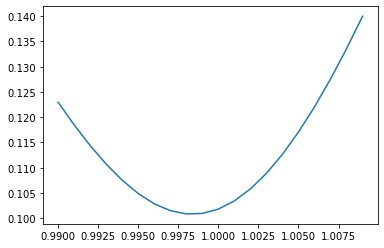

In [160]:
y_val_hat = gbm_tuned.predict(X_val)
# whole correlation by weight
print("weight correction")
W=[(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    error = rmspe(np.expm1(y_val), np.expm1(y_val_hat*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

In [162]:
pred_lgb_tuned = pd.DataFrame({'Id': test_store['Id'],
                     'Sales': np.exp(y_pred_lgb_tuned*0.998)})
pred_lgb.sort_values(by=['Id'], inplace=True)
pred_lgb.head()
pred_lgb.to_csv('submission_lgb_8.csv', index=False)

,Id,Sales
0,1,4209.436649
48,2,7138.424045
96,3,9175.155447
144,4,6756.778307
192,5,6675.427642


private score: 0.11959, publick score: 0.10937

## 5. Predicting on test set

###  5.1 Engineer the features of test set

In [106]:
test = pd.read_csv("./test.csv", parse_dates = True, low_memory = False, index_col = 'Date')
test.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,1,1,4,1.0,1,0,0
2015-09-17,2,3,4,1.0,1,0,0
2015-09-17,3,7,4,1.0,1,0,0
2015-09-17,4,8,4,1.0,1,0,0
2015-09-17,5,9,4,1.0,1,0,0


In [107]:
test['Year'] = test.index.year
test['Month'] = test.index.month
test['Day'] = test.index.day
test['WeekOfYear'] = test.index.weekofyear

/home/hzj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  after removing the cwd from sys.path.


In [108]:
test.StateHoliday.unique()

array(['0', 'a'], dtype=object)

In [109]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41088 entries, 2015-09-17 to 2015-08-01
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Open           41077 non-null  float64
 4   Promo          41088 non-null  int64  
 5   StateHoliday   41088 non-null  object 
 6   SchoolHoliday  41088 non-null  int64  
 7   Year           41088 non-null  int64  
 8   Month          41088 non-null  int64  
 9   Day            41088 non-null  int64  
 10  WeekOfYear     41088 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 3.8+ MB


In [110]:
test[test.Open.isnull()]

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,
2015-09-17,480,622,4,NaN,1,0,0,2015,9,17,38
2015-09-16,1336,622,3,NaN,1,0,0,2015,9,16,38
2015-09-15,2192,622,2,NaN,1,0,0,2015,9,15,38
2015-09-14,3048,622,1,NaN,1,0,0,2015,9,14,38
2015-09-12,4760,622,6,NaN,0,0,0,2015,9,12,37
2015-09-11,5616,622,5,NaN,0,0,0,2015,9,11,37
2015-09-10,6472,622,4,NaN,0,0,0,2015,9,10,37
2015-09-09,7328,622,3,NaN,0,0,0,2015,9,9,37
2015-09-08,8184,622,2,NaN,0,0,0,2015,9,8,37


we can see from the list that in `Open` there are 11 nulls. We assume the test set are all open, these Nulls should be replaced with 1.

In [111]:
test.fillna(1, inplace=True)
test.isnull().sum()

Id               0
Store            0
DayOfWeek        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
Year             0
Month            0
Day              0
WeekOfYear       0
dtype: int64

In [112]:
# Merging the store to test set
test_store = pd.merge(test, store, how = 'inner', on = 'Store')

test_store['CompetitionOpen'] = 12 * (test_store.Year - test_store.CompetitionOpenSinceYear) + (test_store.Month - test_store.CompetitionOpenSinceMonth)
test_store['PromoOpen'] = 12 * (test_store.Year - test_store.Promo2SinceYear) + (test_store.WeekOfYear - test_store.Promo2SinceWeek) / 4.0

test_store['CompetitionOpen'] = test_store.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
test_store['PromoOpen'] = test_store.PromoOpen.apply(lambda x: x if x > 0 else 0)

In [113]:
test_store['monthStr'] = test_store.Month.map(month2str)
test_store.loc[test_store.PromoInterval == 0, 'PromoInterval'] = ''
test_store['IsPromoMonth'] = 0
for interval in test_store.PromoInterval.unique():
    if interval != '':
        for month in interval.split(','):
            test_store.loc[(test_store.monthStr == month) & (test_store.PromoInterval == interval), \
                            'IsPromoMonth'] = 1

In [114]:
test_store.Assortment.replace(mappings, inplace = True)
test_store.StoreType.replace(mappings, inplace = True)
test_store.StateHoliday.replace(mappings, inplace = True)

In [115]:
test_store

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,1,4,1.0,1,0,0,2015,9,17,...,9.0,2008.0,0,0.0,0.0,,84.0,24189.50,Sept,0
1,857,1,3,1.0,1,0,0,2015,9,16,...,9.0,2008.0,0,0.0,0.0,,84.0,24189.50,Sept,0
2,1713,1,2,1.0,1,0,0,2015,9,15,...,9.0,2008.0,0,0.0,0.0,,84.0,24189.50,Sept,0
3,2569,1,1,1.0,1,0,0,2015,9,14,...,9.0,2008.0,0,0.0,0.0,,84.0,24189.50,Sept,0
4,3425,1,7,0.0,0,0,0,2015,9,13,...,9.0,2008.0,0,0.0,0.0,,84.0,24189.25,Sept,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,37664,1115,3,1.0,1,0,1,2015,8,5,...,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",23.0,38.50,Aug,0
41084,38520,1115,2,1.0,1,0,1,2015,8,4,...,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",23.0,38.50,Aug,0
41085,39376,1115,1,1.0,1,0,1,2015,8,3,...,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",23.0,38.50,Aug,0
41086,40232,1115,7,0.0,0,0,1,2015,8,2,...,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",23.0,38.25,Aug,0


Let's have a look of the structure of features between table __train_store__  (25 columns) and __test_store__ (24 columns)

### 5.2 Predicting

In [114]:
train_store.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpen', 'PromoOpen', 'monthStr', 'IsPromoMonth'],
      dtype='object')

In [115]:
test_store.columns

Index(['Id', 'Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'CompetitionOpen', 'PromoOpen',
       'monthStr', 'IsPromoMonth'],
      dtype='object')

In __train_store__ there are no `Sales` and `Customers`.
In __test_store__ there are no `Id`

In [116]:
X_test = test_store.drop(['Id', 'Open', 'monthStr', 'PromoInterval'], axis=1)

In [117]:
# check if the two tables have the same features
print(X_test.shape[1] == X.shape[1])
print(X_test.columns == X.columns)

True
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


## Submission

In [118]:
# XGboost
y_pred = xgb_model.predict(xgb.DMatrix(X_test))
pred = pd.DataFrame({'Id': test_store['Id'],
                     'Sales': np.exp(y_pred)})
pred.sort_values(by=['Id'], inplace=True)
pred.head()
pred.to_csv('submission_xgb.csv', index=False)

,Id,Sales
0,1,4260.734375
48,2,7525.554199
96,3,9298.076172
144,4,7221.335938
192,5,6783.383301


In [119]:
# LightGBM
y_pred_lgb = gbm_tuned.predict(X_test, num_iteration=gbm_tuned.best_iteration)
pred_lgb = pd.DataFrame({'Id': test_store['Id'],
                     'Sales': np.exp(y_pred_lgb)})
pred_lgb.sort_values(by=['Id'], inplace=True)
pred_lgb.head()
pred_lgb.to_csv('submission_lgb.csv', index=False)

## Conclusion

XGBoost: Private score: 0.12993, Public score: 0.11396
LightGBM: Private score: 0.12864, Publick score: 0.11477
LightGBM tuned with GridSearch: Private score: 0.12398, Publick score: 0.11309
LightGBM tuned and Weight correction: Private score: 0.11959, Publick score: 0.10937

In [23]:
df = pd.DataFrame([[0.12993, 0.11396], [0.12864, 0.11477], [0.12398, 0.11309], [0.11959, 0.10937]],
                 index=['XGBoost', 'LightGBM', 'LightGBM tuned with GridSearch', 'LightGBM tuned and Weight correction'],
                 columns=['Private Score', 'Public Score'])
df

,Private Score,Public Score
XGBoost,0.12993,0.11396
LightGBM,0.12864,0.11477
LightGBM tuned with GridSearch,0.12398,0.11309
LightGBM tuned and Weight correction,0.11959,0.10937
